# Project Overview

> This is an in-depth notebook which explores the King County Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, study of different models using different categorical methods (one-hot encoding vs target encoding) with extensive parameter tuning, an exploration of different feature selection methods, an evaluation of the final model, and visualizations.

* **Business Objective**


* **Notebook Preparation**
    * Importing our Modules


* **Preprocessing**
    * EDA and Cleaning
        * Scaling Time Series
        * Duplicates
        * Outlier Detection
        * Missing Data
        * Binary Data
        * Visualize Cleaned Data
        * Studying our Target Variable
    * Create Holdout Set
    * Feature Engineering
    * Correlations and Multicollinearity
    * EDA & Process Train Set
        * Categoricals
        * Continuous
            * Find Interactions
            * Transform and Standardize Continuous Data
            * Add Polynomial Features
    * Process Test Set
        * Categoricals
        * Continuous
    * Create Train/Test Split


* **Model Explorations**
    * Picking our Base Features
    * Linear Regressions
        * Basic LR with Top Features One-Hot Encoded
        * Basic LR with Top Features Target Encoded
        * LR with ALL model features
        * Linear Regression with various Feature Selection Methods
            * Forward-Backward Selector
            * Permutation Importance
            * RFECV
    * K-Nearest Neighbors
    * Support Vector Regression
    * XGBoost Model
        * One Hot Encoded
        * Target Encoded


* **Model Selection and Analysis**

* **Additional Visualizations**

* **APPENDIX**

# Objective

* Perform exhaustive and accurate data cleaning
* Explore different categorical handling methods
* Build a model that accurately predicts house prices in King County

# Notebook Preparation

In [1]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from math import sqrt
import itertools

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn import neighbors
import xgboost as xgb

# Visualization tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Preprocessing

In [2]:
# load and look at our king county housing data
df = pd.read_csv('kc_house_data.csv')
df

id             date     price  bedrooms  bathrooms  \
0      7129300520  20141013T000000  221900.0         3       1.00   
1      6414100192  20141209T000000  538000.0         3       2.25   
2      5631500400  20150225T000000  180000.0         2       1.00   
3      2487200875  20141209T000000  604000.0         4       3.00   
4      1954400510  20150218T000000  510000.0         3       2.00   
...           ...              ...       ...       ...        ...   
21608   263000018  20140521T000000  360000.0         3       2.50   
21609  6600060120  20150223T000000  400000.0         4       2.50   
21610  1523300141  20140623T000000  402101.0         2       0.75   
21611   291310100  20150116T000000  400000.0         3       2.50   
21612  1523300157  20141015T000000  325000.0         2       0.75   

       sqft_living  sqft_lot  floors  waterfront  view  condition  grade  \
0             1180      5650     1.0           0     0          3      7   
1             2570      7242     2.0           0     0          3      7   
2              770     10000     1.0           0     0          3      6   
3             1960      5000     1.0           0     0          5      7   
4             1680      8080     1.0           0     0          3      8   
...            ...       ...     ...         ...   ...        ...    ...   
21608         1530      1131     3.0           0     0          3      8   
21609         2310      5813     2.0           0     0          3      8   
21610         1020      1350     2.0           0     0          3      7   
21611         1600      2388     2.0           0     0          3      8   
21612         1020      1076     2.0           0     0          3      7   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0            1180              0      1955             0    98178  47.5112   
1            2170            400      1951          1991    98125  47.7210   
2             770              0      1933             0    98028  47.7379   
3            1050            910      1965             0    98136  47.5208   
4            1680              0      1987             0    98074  47.6168   
...           ...            ...       ...           ...      ...      ...   
21608        1530              0      2009             0    98103  47.6993   
21609        2310              0      2014             0    98146  47.5107   
21610        1020              0      2009             0    98144  47.5944   
21611        1600              0      2004             0    98027  47.5345   
21612        1020              0      2008             0    98144  47.5941   

          long  sqft_living15  sqft_lot15  
0     -122.257           1340        5650  
1     -122.319           1690        7639  
2     -122.233           2720        8062  
3     -122.393           1360        5000  
4     -122.045           1800        7503  
...        ...            ...         ...  
21608 -122.346           1530        1509  
21609 -122.362           1830        7200  
21610 -122.299           1020        2007  
21611 -122.069           1410        1287  
21612 -122.299           1020        1357  

[21613 rows x 21 columns]

In [3]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## EDA Cleaning

### Scale Time Series

In [4]:
# converting our date to a proper datetime
df['date'] = pd.to_datetime(df['date'])

In [5]:
# earliest date
df['date'].min()

Timestamp('2014-05-02 00:00:00')

In [6]:
# latest date
df['date'].max()

Timestamp('2015-05-27 00:00:00')

This data includes a TIME SERIES, and we need to bring our target prices to the same time scale. It's easy to ignore that these homes were sold over the space of a year, but a year is a long time for real estate. King County median prices increased 9.05% from May 2014 to May 2015, and we need to account for this kind of change in our model. We'll do this by appreciating all sale prices into May 2015 using an appreciation rate over the year of 9.05%, and dividing into months (more granularity is possible of course)

In [7]:
# We're applying a time series multiplier to our rows based on date sold. Our data spans from
# May 2014-May 2015 so we divide it into a 12 month time series.
df.loc[(df['date']>'2014-05-01') & (df['date']<'2014-06-01'), 'time_series'] = 12
df.loc[(df['date']>='2014-06-01') & (df['date']<'2014-07-01'), 'time_series'] = 11
df.loc[(df['date']>='2014-07-01') & (df['date']<'2014-08-01'), 'time_series'] = 10
df.loc[(df['date']>='2014-08-01') & (df['date']<'2014-09-01'), 'time_series'] = 9
df.loc[(df['date']>='2014-09-01') & (df['date']<'2014-10-01'), 'time_series'] = 8
df.loc[(df['date']>='2014-10-01') & (df['date']<'2014-11-01'), 'time_series'] = 7
df.loc[(df['date']>='2014-11-01') & (df['date']<'2014-12-01'), 'time_series'] = 6
df.loc[(df['date']>='2014-12-01') & (df['date']<'2015-01-01'), 'time_series'] = 5
df.loc[(df['date']>='2015-01-01') & (df['date']<'2015-02-01'), 'time_series'] = 4
df.loc[(df['date']>='2015-02-01') & (df['date']<'2015-03-01'), 'time_series'] = 3
df.loc[(df['date']>='2015-03-01') & (df['date']<'2015-04-01'), 'time_series'] = 2
df.loc[(df['date']>='2015-04-01') & (df['date']<'2015-05-01'), 'time_series'] = 1
df.loc[(df['date']>='2015-05-01') & (df['date']<'2015-06-01'), 'time_series'] = 0

# adjusting up our sale prices to account for appreciation using the yearly appreciation for home sales in King County
# from May 2014 to May 2015
monthly_appreciation = .0905/12
df['adj_price'] = round(df['price']*(1+((monthly_appreciation)*df['time_series'])), 0)

# we're renaming our adjusted price column to be price
df.rename(columns={'price': 'orig_price', "adj_price": "price"}, inplace=True)

# renumber our data
df.set_index('price', inplace=True)
df.reset_index(inplace=True)

# we're now going to extract just the month from our datetime, and store that in a new column
# we won't be using our entire date - we're interested in the month that houses are sold
df['month_sold'] = pd.DatetimeIndex(df['date']).month
df.drop('date', axis=1, inplace=True)

### Duplicate Data

In [8]:
# Look for duplicate data on lat/long

df[df.duplicated(subset=['lat','long'], keep=False)].sort_values('lat')

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
20925  267437.0  8141310040    246950.0         3       3.00         1670   
20686  276063.0  8141310030    256703.0         3       2.00         1670   
16535  473877.0  5595900345    460000.0         4       2.75         3460   
5147   238545.0  5595900280    235000.0         3       1.00         1050   
8429   331227.0  9432900180    307999.0         4       2.75         2420   
...         ...         ...         ...       ...        ...          ...   
16320  326060.0  7418700050    299000.0         3       1.00         1390   
10538  419788.0   253600160    384950.0         3       2.50         1860   
7532   405792.0   253600150    380000.0         2       2.50         1860   
747    487277.0   293720140    449950.0         3       2.50         2170   
8531   430649.0   293720180    415000.0         3       2.50         1980   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
20925      4440     1.0           0     0          3      7        1670   
20686      4441     1.0           0     0          3      7        1670   
16535     13168     2.0           0     0          4      8        3460   
5147       7670     1.5           0     0          5      7        1050   
8429       8438     2.0           0     0          3      8        2420   
...         ...     ...         ...   ...        ...    ...         ...   
16320      9624     1.5           0     0          4      7        1390   
10538      3690     2.0           0     0          3      7        1860   
7532       3504     2.0           0     0          3      7        1860   
747        4912     2.0           0     0          3      7        2170   
8531       4274     2.0           0     0          3      7        1980   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
20925              0      2014             0    98022  47.1948 -121.975   
20686              0      2014             0    98022  47.1948 -121.975   
16535              0      1932          1986    98022  47.2046 -121.996   
5147               0      1955             0    98022  47.2046 -121.996   
8429               0      1996             0    98022  47.2091 -122.009   
...              ...       ...           ...      ...      ...      ...   
16320              0      1954             0    98155  47.7758 -122.301   
10538              0      2000             0    98028  47.7760 -122.239   
7532               0      2000             0    98028  47.7760 -122.239   
747                0      2003             0    98028  47.7767 -122.239   
8531               0      2003             0    98028  47.7767 -122.239   

       sqft_living15  sqft_lot15  time_series  month_sold  
20925           1670        4622         11.0           6  
20686           1670        4622         10.0           7  
16535           1500        7670          4.0           1  
5147            1220        7670          2.0           3  
8429            2420        8580         10.0           7  
...              ...         ...          ...         ...  
16320           1440        9624         12.0           5  
10538           1870        4394         12.0           5  
7532            1860        4246          9.0           8  
747             2010        4395         11.0           6  
8531            2000        4394          5.0          12  

[1508 rows x 23 columns]

In [9]:
# We have a lot of duplicate entries. We're going to keep the later of these entries and hope that if it's an outlier,
# it's caught in our outlier processing later.

df.drop_duplicates(['lat','long'], keep='last', inplace=True)

### Outlier Detection

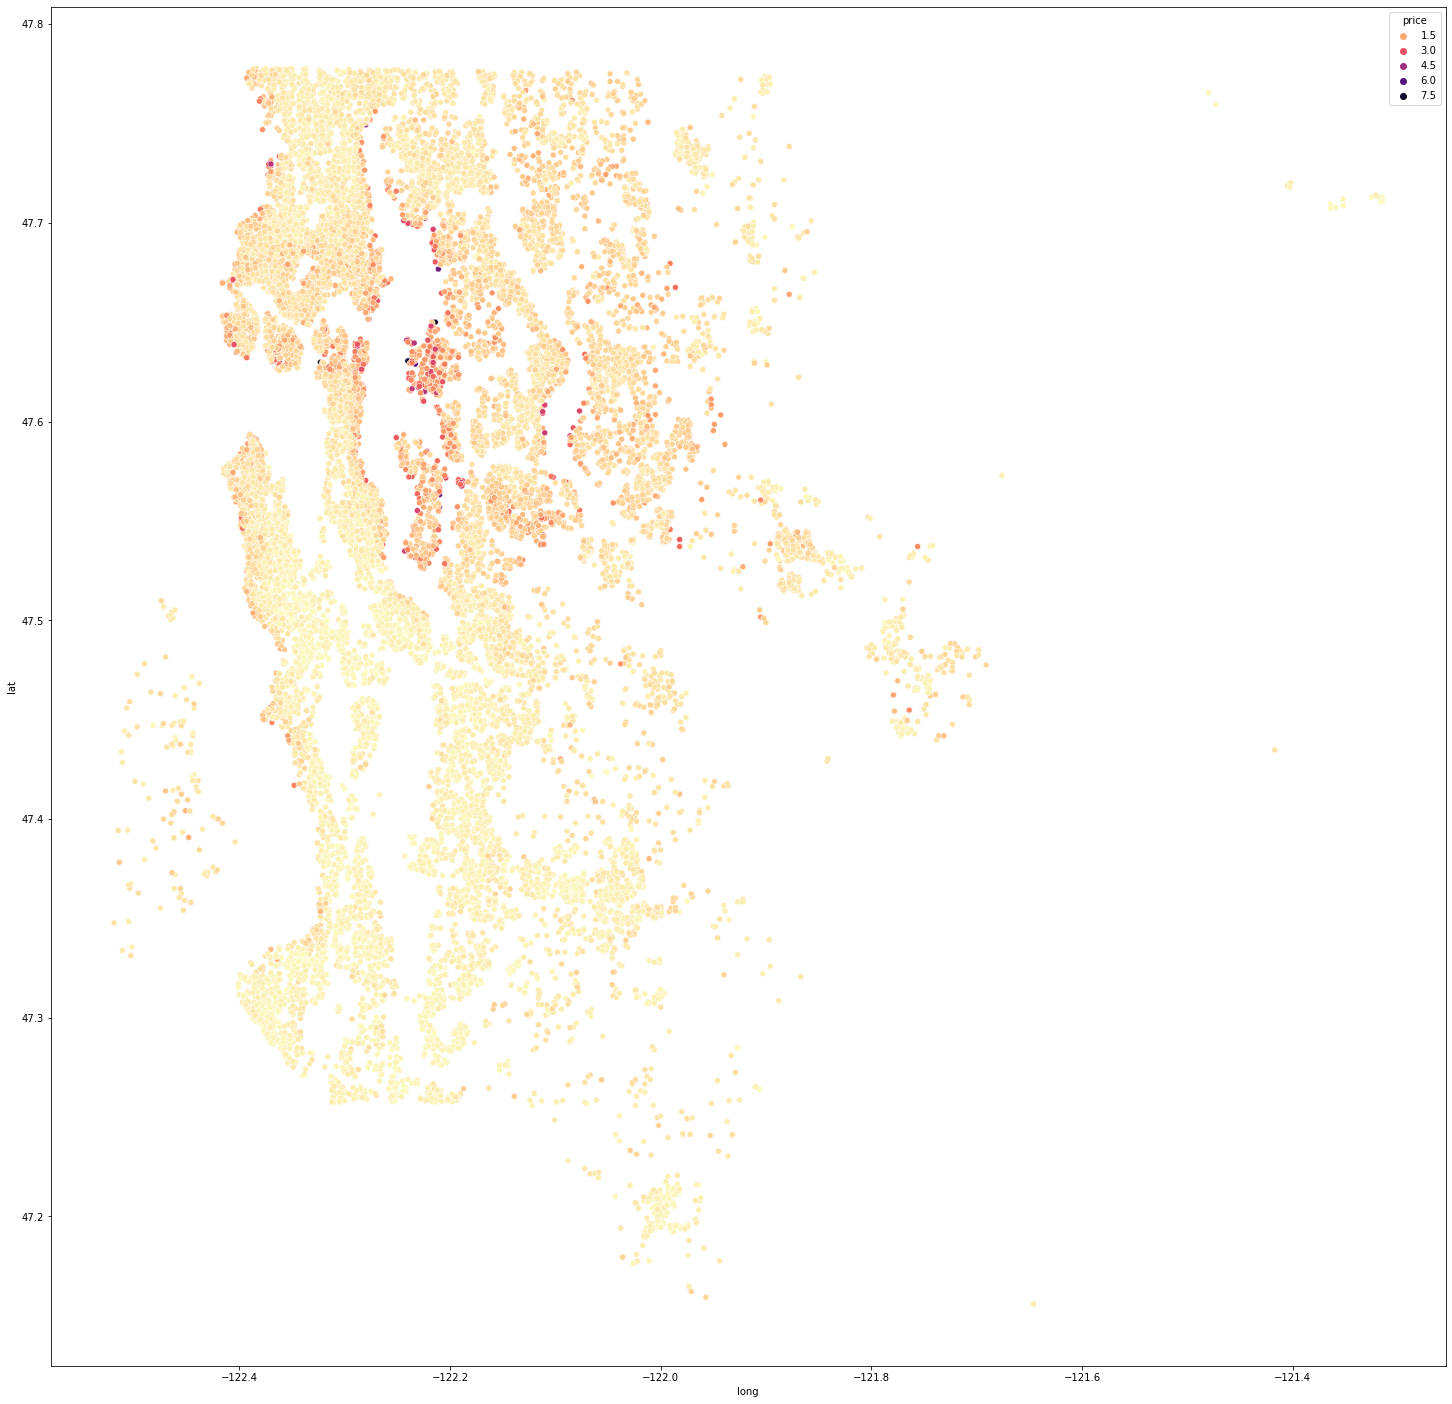

In [10]:
# plotting latitude and longitude as a visual scatter plot to look for location outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");

Using latitude and longitude, we make a visual map of the King County area that lets us see the map outliers. We can see that there are a few sales in locations that are outliers in some way - still in King County but very far away from the metro area on which we are focusing. Sales that are too far outside of our comparison area geographically may add noise to our model. So I'm going to drop the longitude outliers as well. 

This visualization suggests that location is very important to home price. We're going to check that out more directly.

In [11]:
# drop the properties east of the metropolitan area
df.drop(df[df['long'] > -121.7].index, inplace=True)

# looking for outliers in the percentiles
df.describe()

price            id    orig_price      bedrooms     bathrooms  \
count  2.080900e+04  2.080900e+04  2.080900e+04  20809.000000  20809.000000   
mean   5.703036e+05  4.577438e+09  5.434746e+05      3.380556      2.118482   
std    3.884515e+05  2.875639e+09  3.696620e+05      0.929549      0.771670   
min    7.669700e+04  1.000102e+06  7.500000e+04      0.000000      0.000000   
25%    3.375260e+05  2.123049e+09  3.240000e+05      3.000000      1.750000   
50%    4.765020e+05  3.904960e+09  4.520000e+05      3.000000      2.250000   
75%    6.794120e+05  7.305301e+09  6.500000e+05      4.000000      2.500000   
max    8.106496e+06  9.900000e+09  7.700000e+06     33.000000      8.000000   

        sqft_living      sqft_lot        floors    waterfront          view  \
count  20809.000000  2.080900e+04  20809.000000  20809.000000  20809.000000   
mean    2092.673651  1.540826e+04      1.487097      0.007737      0.238839   
std      922.394989  4.209881e+04      0.533516      0.087622      0.773236   
min      290.000000  5.200000e+02      1.000000      0.000000      0.000000   
25%     1430.000000  5.102000e+03      1.000000      0.000000      0.000000   
50%     1930.000000  7.680000e+03      1.500000      0.000000      0.000000   
75%     2560.000000  1.080000e+04      2.000000      0.000000      0.000000   
max    13540.000000  1.651359e+06      3.500000      1.000000      4.000000   

          condition         grade    sqft_above  sqft_basement      yr_built  \
count  20809.000000  20809.000000  20809.000000   20809.000000  20809.000000   
mean       3.413715      7.665097   1796.978183     295.695468   1970.862944   
std        0.651549      1.180244    832.229017     445.657536     29.223085   
min        1.000000      1.000000    290.000000       0.000000   1900.000000   
25%        3.000000      7.000000   1200.000000       0.000000   1951.000000   
50%        3.000000      7.000000   1570.000000       0.000000   1975.000000   
75%        4.000000      8.000000   2230.000000     580.000000   1996.000000   
max        5.000000     13.000000   9410.000000    4820.000000   2015.000000   

       yr_renovated       zipcode           lat          long  sqft_living15  \
count  20809.000000  20809.000000  20809.000000  20809.000000   20809.000000   
mean      85.459561  98077.644433     47.559213   -122.213780    1995.607285   
std      404.081343     53.598262      0.138948      0.138697     687.649367   
min        0.000000  98001.000000     47.159300   -122.519000     399.000000   
25%        0.000000  98033.000000     47.468600   -122.327000    1490.000000   
50%        0.000000  98065.000000     47.570900   -122.228000    1850.000000   
75%        0.000000  98117.000000     47.677600   -122.124000    2376.000000   
max     2015.000000  98199.000000     47.777600   -121.701000    6210.000000   

          sqft_lot15   time_series    month_sold  
count   20809.000000  20809.000000  20809.000000  
mean    12983.825652      6.533711      6.562209  
std     27690.839852      3.724901      3.117275  
min       659.000000      0.000000      1.000000  
25%      5160.000000      3.000000      4.000000  
50%      7670.000000      7.000000      6.000000  
75%     10133.000000     10.000000      9.000000  
max    871200.000000     12.000000     12.000000

We see potential outliers in price, sqft_lot, sqft_living, and bedrooms.

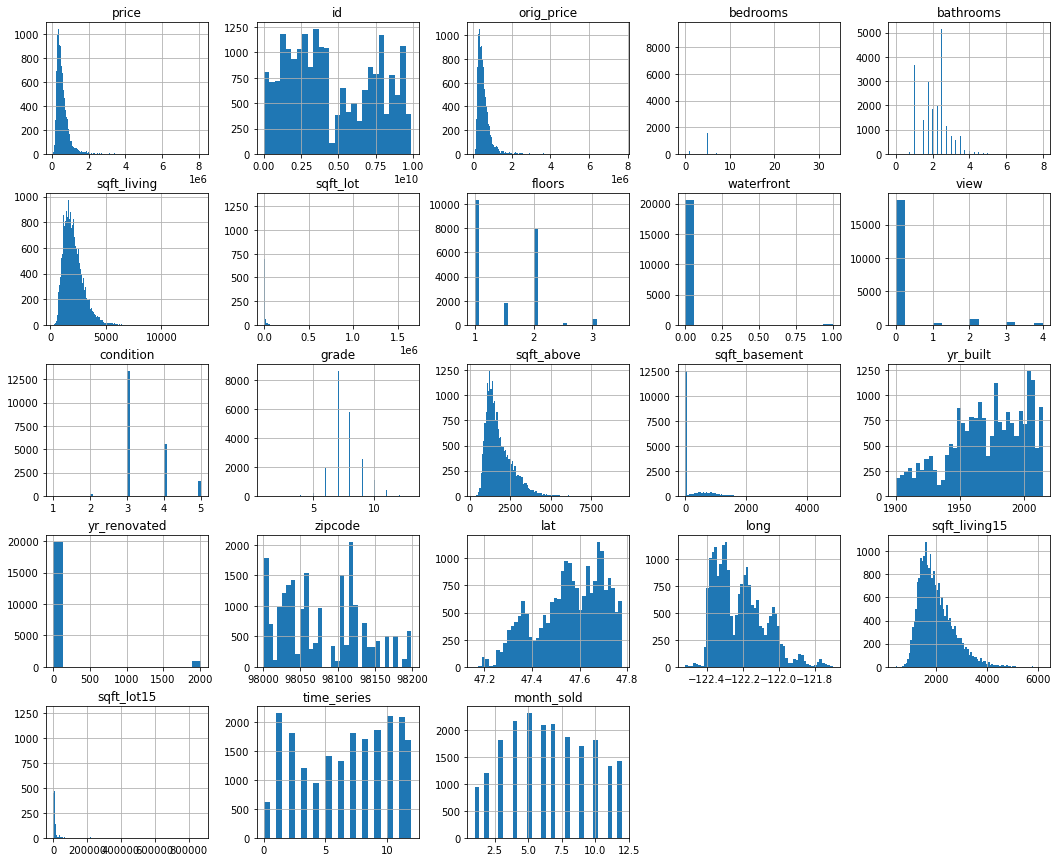

In [12]:
# check how our histograms are looking

df.hist(figsize=(18,15), bins='auto');

We should never remove outliers indiscriminately, especially if they contain real data. Ultimately I opt to remove via IQR on sqft_living and sqft_lot, with reservations. A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.

For the square footage variables, I ultimately concluded that extremely large houses and lots are so seriously under-represented in the dataset that we won't be able to reliably predict on them anyway and they are better left off.

In order to prevent a lot of data loss in this way, I kept IQR range of 1.6 instead of the standard 1.5

In [13]:
def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.6"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.6 * iqr)
    upper_range = Q3 + (1.6 * iqr)
    return lower_range,upper_range  

# determing our IQR ranges for lot size, sq footage
lotlower,lotupper = iqr_outliers(df.sqft_lot)
sqftlower, sqftupper = iqr_outliers(df.sqft_living)

# dropping the things outside of our lower and upper range
df.drop(df[ (df.sqft_lot > lotupper) | (df.sqft_lot < lotlower) ].index , inplace=True)
df.drop(df[ (df.sqft_living > sqftupper) | (df.sqft_living < sqftlower) ].index , inplace=True)

In [14]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code importance

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# rank each zip code and assign rank to new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    '''Takes in a line, a lookup table, and a target column
    returns value of target column
    ARGUMENTS:
    line from dataframe x
    lookup table frame
    column to return rank'''
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

''

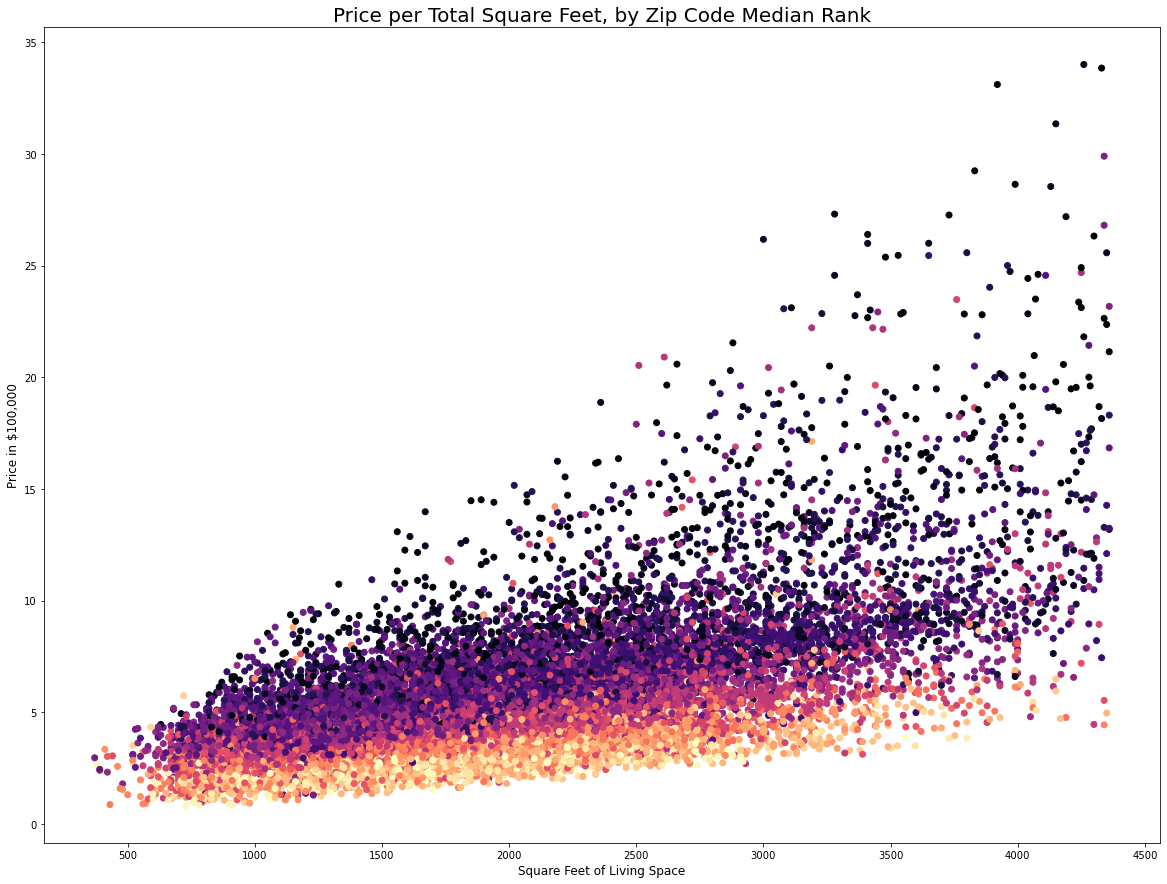

In [15]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)
;

This plot of price per total square feet of living space, colored by the zip code median rank, visually shows the importance of location. Let's look at that closer.

''

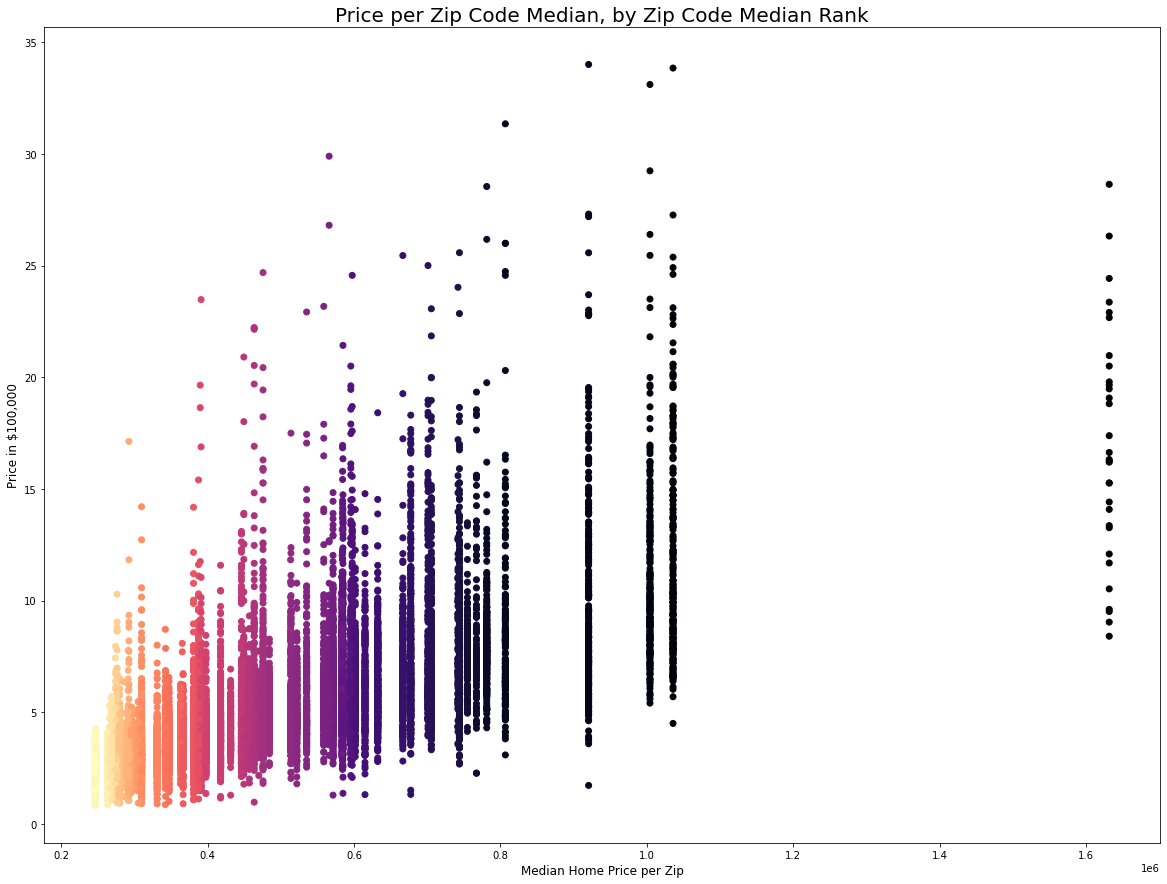

In [16]:
# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;

Looking at our price per zip code in a different way, we can see a potential issue with our data. Most of our data set is fairly normal and expected. Then we have three zip codes giving us very strong right tails. Then we have ONE zip code way off yonder which may cause problems with our model. 

I'll be eliminating price outliers on a per-zipcode basis using the same IQR range. My goal here is not to strip usable data, but to identify and excise any rogue non-standard sales. If I were to do this dataset-wide, many zipcodes would retain their own outliers. We can see in the visualizations just above that zipcodes each have their own price distribution. So we keep our price outlier detection within zipcode.

In [17]:
# Eliminating outliers on a per-zipcode basis

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)


#### Manually locating zip/price outliers

One thing this data set lacks is *type of sale*. We want a model that properly describes the open market, but this dataset definitely includes sales that are outside the market, such as inter-family sales or other sales that don't properly reflect market value. The best way I can think of to find these outliers is to find suspiciously low sales based on location, because we can see in the lat/long scatter that location makes a difference. We will hunt these down manually even though that takes some time.

In [18]:
# check price stats by zip code and displaying top 30 zip codes by mean
# I'm looking for suspiciously low "min" values

find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)

# very suspicious values in many zip codes for min
# 98112, 98109, 98033, 98115, 98027, 98116, 98122, 98117, 98136, 98065, 98144, 98072, 98028

count          mean            std       min         25%        50%  \
zipcode                                                                        
98039     31.0  1.696580e+06  527135.064658  840952.0  1331322.00  1631827.0   
98004    228.0  1.179899e+06  444203.069610  450642.0   833869.50  1034311.5   
98040    219.0  1.062392e+06  313783.466602  541479.0   831267.50   989706.0   
98112    231.0  9.866290e+05  383385.730693  173148.0   695586.00   886977.0   
98109     97.0  8.299721e+05  304542.249557  228087.0   626700.00   752837.0   
98105    203.0  8.150396e+05  325079.639034  395000.0   574075.00   695265.0   
98119    163.0  8.117765e+05  269093.045311  309589.0   624424.00   761312.0   
98102     90.0  8.063466e+05  268892.500266  357376.0   620403.75   739164.0   
98075    244.0  7.776592e+05  144090.967601  430951.0   693140.75   776258.5   
98199    291.0  7.654154e+05  276591.400402  332744.0   552467.00   693093.0   
98006    386.0  7.620099e+05  243966.109245  268574.0   567554.00   738364.0   
98005    117.0  7.468577e+05  152529.462791  415083.0   617450.00   742218.0   
98033    355.0  7.158296e+05  245070.507704  132941.0   532998.50   659804.0   
98074    360.0  6.737029e+05  169668.471020  282112.0   552293.00   664977.0   
98052    498.0  6.491712e+05  163291.773712  280181.0   519985.25   629740.5   
98053    233.0  6.197415e+05  183479.658687  302262.0   469317.00   583183.0   
98115    528.0  6.160263e+05  174865.237280  209050.0   482550.50   588605.0   
98027    226.0  6.101331e+05  188366.265152  131961.0   466945.75   610489.5   
98029    280.0  6.101215e+05  137300.432419  302195.0   510200.50   599730.5   
98007    123.0  6.097046e+05  156157.541037  315023.0   484989.50   579336.0   
98122    261.0  6.045843e+05  175464.983742  217234.0   460257.00   580725.0   
98077     44.0  6.040074e+05  270019.723422  270740.0   343976.75   513353.5   
98116    299.0  6.005260e+05  171122.404754  137843.0   480290.00   575928.0   
98103    531.0  5.998994e+05  182483.281298  245000.0   458349.00   581236.0   
98117    500.0  5.854116e+05  154814.173734  268997.0   477997.75   565484.5   
98107    233.0  5.802665e+05  117052.654304  307497.0   494812.00   559217.0   
98008    244.0  5.692257e+05  123957.291223  278625.0   480165.00   557504.0   
98177    203.0  5.673825e+05  176926.573296  254820.0   440125.00   523922.0   
98136    241.0  5.492641e+05  181386.400083  204525.0   412124.00   507370.0   
98144    296.0  5.365983e+05  206500.578098  182365.0   388133.25   468589.0   
98065    259.0  5.356142e+05  132065.920547  180257.0   449929.00   521539.0   
98011    179.0  5.007143e+05  101051.814388  262163.0   427239.00   483620.0   
98072    140.0  4.716648e+05   92526.005170  217526.0   402786.75   465290.0   
98028    244.0  4.692830e+05  115992.111283  184072.0   400400.75   455933.5   
98034    465.0  4.636397e+05   94745.767465  240355.0   400453.00   458010.0   

                75%        max  
zipcode                         
98039    2014776.00  2863593.0  
98004    1471871.00  2490804.0  
98040    1279455.00  1999232.0  
98112    1251888.50  1954035.0  
98109     962498.00  1561690.0  
98105    1006013.50  1722990.0  
98119     942897.00  1543079.0  
98102     988545.50  1559460.0  
98075     866396.75  1176019.0  
98199     916962.00  1516142.0  
98006     915231.75  1493985.0  
98005     853232.00  1184391.0  
98033     857662.00  1430709.0  
98074     779974.25  1177740.0  
98052     774590.25  1158071.0  
98053     752852.00  1105431.0  
98115     717651.00  1158071.0  
98027     726086.75  1121269.0  
98029     705865.75  1043154.0  
98007     699503.00  1035975.0  
98122     710137.00  1083107.0  
98077     854446.25  1183192.0  
98116     699239.50  1078554.0  
98103     719201.00  1115447.0  
98117     677284.00  1046880.0  
98107     642812.00   912760.0  
98008     642332.50   940516.0  
98177     680212.50  1066594.0  
98136     629352.00  1081675.0  
98144     648491.75  1146

In [19]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98109)]
# There are two listings in this zip code selling for under 250k. We're going to consider this an outlier sale.
# worth noting these are both the exact same property. These are both bad listings.

# It looks like we missed a dupe due to a slight mismatch in lat. Since this is a dupe AND an anomalous price, we are going to dump it.

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
3844   228087.0  2734100734    216650.0         3        3.5         1540   
11436  228087.0  2734100732    216650.0         3        3.5         1480   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
3844       1427     2.0           0     0          3      7        1360   
11436      1077     2.0           0     0          3      7        1300   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
3844             180      2007             0    98109  47.5420 -122.322   
11436            180      2007             0    98109  47.5421 -122.322   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
3844            1220        4000          7.0          10        64   
11436           1140        2003          7.0          10        64   

       median_zip  
3844     767264.0  
11436    767264.0

In [20]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98033)]
#We're going to consider these outlier sales.

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
1222   132941.0  1238500451    130000.0         3        1.0         1110   
12823  151561.0  2870000040    145000.0         2        1.0          800   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
1222       7520     1.0           0     0          4      7        1110   
12823      8125     1.0           0     0          3      6         800   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
1222               0      1960             0    98033  47.6830 -122.176   
12823              0      1964             0    98033  47.6836 -122.174   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
1222            1440        8400          3.0           2        58   
12823           2390        8125          6.0          11        58   

       median_zip  
1222     677512.0  
12823    677512.0

In [21]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98115)]
#We're going to consider these outlier sales.

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
1975  209050.0  5101404170    200000.0         1       0.75          680   

      sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
1975      9600     1.0           0     0          3      5         680   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
1975              0      1947             0    98115  47.6964 -122.306   

      sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  median_zip  
1975           1580        6624          6.0          11        53    597497.0

In [22]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98027)]
# listings under 250k in this zip. We'll drop them.

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
3885   249870.0  5279100625    248000.0         2        1.0          770   
14001  131961.0  2354300456    130000.0         2        1.0          600   
18897  224254.0  2354300845    210000.0         3        1.0         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
3885       8600     1.0           0     0          4      4         770   
14001      1500     1.0           0     0          4      4         600   
18897      6000     1.0           0     0          3      5        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
3885               0      1914             0    98027  47.5325 -122.031   
14001              0      1900             0    98027  47.5289 -122.033   
18897              0      1900             0    98027  47.5281 -122.031   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
3885            1420        6960          1.0           4        55   
14001           1130        6000          2.0           3        55   
18897           2070        7200          9.0           8        55   

       median_zip  
3885     614993.0  
14001    614993.0  
18897    614993.0

In [23]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98116)]
# suspicious but in bad condition. We will drop though.

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
3975   210000.0  6324000090    210000.0         2        1.0          990   
18332  137843.0  9272202260    130000.0         3        1.0         1200   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
3975       8140     1.0           0     0          1      6         990   
18332      7000     2.0           0     0          1      7        1200   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
3975               0      1910             0    98116  47.5828 -122.382   
18332              0      1908             0    98116  47.5883 -122.384   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
3975            2150        5000          0.0           5        51   
18332           3290        6000          8.0           9        51   

       median_zip  
3975     584888.0  
18332    584888.0

In [24]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98122)]
# suspicious but VERY tiny. We will leave.

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
3987  217234.0  6840700165    202000.0         1        1.0          590   

      sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
3987       833     1.0           0     0          4      7         590   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
3987              0      1926             0    98122  47.6082 -122.299   

      sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  median_zip  
3987            780        1617         10.0           7        52    595627.0

In [25]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98136)]
# Drop

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
881    204525.0  2349300060    200000.0         4        2.0         1920   
11500  232505.0  4322200105    229050.0         1        1.0          420   
17578  228910.0  7625702616    219000.0         2        2.5          809   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
881        4822     1.0           0     0          2      6         920   
11500      3298     1.0           0     0          4      4         420   
17578       940     2.0           0     0          3      7         809   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
881             1000      1914             0    98136  47.5507 -122.381   
11500              0      1949             0    98136  47.5375 -122.391   
17578              0      2003             0    98136  47.5499 -122.384   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
881             1120        4822          3.0           2        42   
11500           1460        4975          2.0           3        42   
17578           1260        4240          6.0          11        42   

       median_zip  
881      513846.0  
11500    513846.0  
17578    513846.0

In [26]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98065)]
# Drop

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
8133   180257.0  7849202585    170000.0         1        1.0          480   
9854   243861.0  7849202190    235000.0         0        0.0         1470   
18338  211137.0  7606200090    208000.0         2        1.0         1160   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
8133       4560     1.0           0     0          3      5         480   
9854       4800     2.0           0     0          3      7        1470   
18338      5750     1.0           0     0          4      6        1160   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
8133               0      1922             0    98065  47.5253 -121.826   
9854               0      1996             0    98065  47.5265 -121.828   
18338              0      1924             0    98065  47.5322 -121.829   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
8133             890        4803          8.0           9        43   
9854            1060        7200          5.0          12        43   
18338           1160        8250          2.0           3        43   

       median_zip  
8133     521835.0  
9854     521835.0  
18338    521835.0

In [27]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98144)]
# Dropping most

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
1457   250000.0  1596600060    250000.0         1        1.0          660   
5573   182365.0  3080000005    181000.0         2        1.0         1310   
5885   242142.0  1250200345    230000.0         3        1.0          680   
8911   193373.0  8728100775    190500.0         3        1.5         1110   
20963  247346.0  6058600220    230000.0         3        1.5         1040   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
1457       2600     1.0           0     0          3      6         660   
5573       4000     1.0           0     0          3      7         950   
5885       2400     1.0           0     0          4      6         680   
8911       1150     2.0           0     0          3      8         940   
20963      1264     2.0           0     0          3      9         900   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
1457               0      1919             0    98144  47.5723 -122.304   
5573             360      1942             0    98144  47.5798 -122.306   
5885               0      1903             0    98144  47.5982 -122.299   
8911             170      2007             0    98144  47.5929 -122.306   
20963            140      2015             0    98144  47.5951 -122.301   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
1457            1560        5445          0.0           5        39   
5573            1310        4000          1.0           4        39   
5885            1470        3600          7.0          10        39   
8911            1380        1751          2.0           3        39   
20963           1350        3000         10.0           7        39   

       median_zip  
1457     475647.0  
5573     475647.0  
5885     475647.0  
8911     475647.0  
20963    475647.0

In [28]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98072)]
# Dropping

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
11298  217526.0  9518100059    203700.0         2        1.0          770   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
11298      2500     1.0           0     0          3      6         770   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
11298              0      1913          1960    98072  47.7534 -122.172   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
11298           1500        8286          9.0           8        38   

       median_zip  
11298    469865.0

In [29]:
df.loc[(df['price'] <= 250000) & (df['zipcode'] == 98028)]
# Dropping

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
2      184072.0  5631500400    180000.0         2       1.00          770   
1922   247346.0  4027701275    230000.0         3       1.00         1240   
9231   247346.0   114100763    230000.0         3       0.75         1040   
12306  201913.0  2570600140    196000.0         3       2.25         1510   
17644  245379.0  9406500600    239950.0         2       1.50         1068   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
2         10000     1.0           0     0          3      6         770   
1922       6195     1.0           0     0          3      6        1240   
9231      15000     1.0           0     0          3      6        1040   
12306      9600     1.0           0     0          1      7        1090   
17644      1452     2.0           0     0          3      7        1068   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
2                  0      1933             0    98028  47.7379 -122.233   
1922               0      1948             0    98028  47.7681 -122.266   
9231               0      1941             0    98028  47.7639 -122.234   
12306            420      1966             0    98028  47.7758 -122.238   
17644              0      1990             0    98028  47.7530 -122.244   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
2               2720        8062          3.0           2        36   
1922            1760       11080         10.0           7        36   
9231            1410       19000         10.0           7        36   
12306           1870       10681          4.0           1        36   
17644           1078        1357          3.0           2        36   

       median_zip  
2        456982.0  
1922     456982.0  
9231     456982.0  
12306    456982.0  
17644    456982.0

In [30]:
df.drop(index=[3844, 11436, 1222, 12823, 1975, 3885, 14001, 18897, 3975, 18332, 3987, 881, 11500, 17578, 8133, 9854, 18338, 5573, 5885, 8911, 11298, 2, 1922, 9231, 12306], inplace=True) #16879, 7088,  

Why should we spend the time excising just a few outliers from thousands of rows of data? Because it's the right thing to do to clean well and improve our data quality.

#### Other outlier detection

Now we'll look for bad data in other categories. This is easy to do using describe.

In [31]:
# looking again at our percentile outliers

df.describe()

price            id    orig_price      bedrooms     bathrooms  \
count  1.756800e+04  1.756800e+04  1.756800e+04  17568.000000  17568.000000   
mean   5.079862e+05  4.728592e+09  4.842303e+05      3.325820      2.030353   
std    2.599409e+05  2.871563e+09  2.473917e+05      0.909743      0.702194   
min    8.222200e+04  1.000102e+06  7.800000e+04      0.000000      0.000000   
25%    3.251660e+05  2.287550e+09  3.100000e+05      3.000000      1.500000   
50%    4.494280e+05  4.051150e+09  4.290000e+05      3.000000      2.000000   
75%    6.256185e+05  7.504011e+09  5.985000e+05      4.000000      2.500000   
max    2.863593e+06  9.900000e+09  2.720000e+06     33.000000      7.500000   

        sqft_living      sqft_lot        floors    waterfront          view  \
count  17568.000000  17568.000000  17568.000000  17568.000000  17568.000000   
mean    1921.126594   7379.642020      1.465762      0.001195      0.149419   
std      719.635542   3601.421497      0.535428      0.034554      0.584850   
min      370.000000    520.000000      1.000000      0.000000      0.000000   
25%     1380.000000   4945.000000      1.000000      0.000000      0.000000   
50%     1820.000000   7200.000000      1.000000      0.000000      0.000000   
75%     2360.000000   9353.250000      2.000000      0.000000      0.000000   
max     4360.000000  19901.000000      3.500000      1.000000      4.000000   

          condition         grade    sqft_above  sqft_basement      yr_built  \
count  17568.000000  17568.000000  17568.000000   17568.000000  17568.000000   
mean       3.419911      7.484062   1653.808288     267.318306   1969.615551   
std        0.650843      0.989025    676.471640     398.820535     29.696046   
min        1.000000      3.000000    370.000000       0.000000   1900.000000   
25%        3.000000      7.000000   1160.000000       0.000000   1950.000000   
50%        3.000000      7.000000   1480.000000       0.000000   1970.000000   
75%        4.000000      8.000000   2020.000000     520.000000   1996.000000   
max        5.000000     12.000000   4360.000000    2170.000000   2015.000000   

       yr_renovated       zipcode           lat          long  sqft_living15  \
count  17568.000000  17568.000000  17568.000000  17568.000000   17568.000000   
mean      73.967953  98080.591701     47.561069   -122.227168    1878.609973   
std      377.087488     54.109656      0.137186      0.131024     586.557490   
min        0.000000  98001.000000     47.177500   -122.512000     460.000000   
25%        0.000000  98033.000000     47.476000   -122.334000    1450.000000   
50%        0.000000  98074.000000     47.572000   -122.261000    1760.000000   
75%        0.000000  98118.000000     47.678600   -122.150000    2200.000000   
max     2015.000000  98199.000000     47.777600   -121.730000    4950.000000   

          sqft_lot15   time_series    month_sold      zip_rank    median_zip  
count   17568.000000  17568.000000  17568.000000  17568.000000  1.756800e+04  
mean     7378.794968      6.502448      6.555612     36.301969  4.908972e+05  
std      4429.078596      3.720189      3.125883     18.930785  1.859707e+05  
min       659.000000      0.000000      1.000000      1.000000  2.456340e+05  
25%      5000.000000      3.000000      4.000000     21.000000  3.425300e+05  
50%      7245.000000      7.000000      6.000000     36.000000  4.569820e+05  
75%      9003.500000     10.000000      9.000000     53.000000  5.974970e+05  
max    196591.000000     12.000000     12.000000     70.000000  1.631827e+06

In [32]:
#check what is going on with the sqft_lot15 outliers by sorting descending
df.sort_values('sqft_lot15', ascending=False).head(5)

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
9445   312679.0  3523029077    297000.0         3        1.0         1340   
4611   194650.0  3523029059    181000.0         2        1.5         1560   
8119   308643.0  1923039089    285000.0         2        2.0         1651   
7093   315991.0  8656800020    309000.0         3        2.5         1450   
13166  414259.0  1523069197    379880.0         3        2.5         1650   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
9445      18000     1.0           0     0          4      7        1340   
4611      10807     1.0           0     0          2      7        1560   
8119      18200     1.0           0     0          3      6        1651   
7093      11480     2.0           0     0          3      7        1450   
13166     14054     1.0           0     0          4      7        1130   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
9445               0      1924             0    98070  47.4443 -122.509   
4611               0      1949             0    98070  47.4444 -122.509   
8119               0      1946             0    98070  47.4621 -122.461   
7093               0      1990             0    98014  47.6720 -121.864   
13166            520      1986             0    98027  47.4821 -122.017   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
9445            1660      196591          7.0          10        28   
4611            1660      196591         10.0           7        28   
8119            1510       89595         11.0           6        28   
7093            2080       87991          3.0           2        20   
13166           1940       87555         12.0           5        55   

       median_zip  
9445     389000.0  
4611     389000.0  
8119     389000.0  
7093     342157.0  
13166    614993.0

In [33]:
# there is something off about these two large and nearly identical entries at the top of the list. We are going to drop these two rows.

df.drop(index=[4611, 9445], inplace=True)

In [34]:
#check what is going on with the weird bedroom value by sorting descending

df.sort_values('bedrooms', ascending=False).head(5)

price          id  orig_price  bedrooms  bathrooms  sqft_living  \
15870  693093.0  2402100895    640000.0        33       1.75         1620   
19254  684887.0  8812401450    660000.0        10       3.00         2920   
15161  684315.0  5566100170    650000.0        10       2.00         3610   
4235   721117.0  2902200015    700000.0         9       3.00         3680   
4096   654299.0  1997200215    599999.0         9       4.50         3830   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
15870      6000     1.0           0     0          5      7        1040   
19254      3745     2.0           0     0          4      7        1860   
15161     11914     2.0           0     0          4      7        3010   
4235       4400     2.0           0     0          3      7        2830   
4096       6988     2.5           0     0          3      7        2450   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15870            580      1947             0    98103  47.6878 -122.331   
19254           1060      1913             0    98105  47.6635 -122.320   
15161            600      1958             0    98006  47.5705 -122.175   
4235             850      1908             0    98102  47.6374 -122.324   
4096            1380      1938             0    98103  47.6927 -122.338   

       sqft_living15  sqft_lot15  time_series  month_sold  zip_rank  \
15870           1330        4700         11.0           6        50   
19254           1810        3745          5.0          12        59   
15161           2040       11914          7.0          10        62   
4235            1960        2450          4.0           1        61   
4096            1460        6291         12.0           5        50   

       median_zip  
15870    584374.0  
19254    701069.0  
15161    744009.0  
4235     742038.0  
4096     584374.0

In [35]:
# this value of 33 in 1620 square feet is obviously a mistake. We're going to impute the mean into this field.

# 11 bedrooms in 3000sf, 10 bedrooms in 2920sf, 10 bedrooms in 3610sf are also obviously mistakes
# We're going to impute the mean into the fields for 10 and 11 bedrooms as well.

# we'll also impute the mean into the few bedroom listings with 0 bedrooms

bedroom_mean = round(df['bedrooms'].mean(), 0)
bedroom_mean
df.loc[df['bedrooms'] == 33.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 11.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 10.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 0, 'bedrooms'] = bedroom_mean
df.loc[df['bathrooms'] == 0, 'bathrooms'] = 2

# I remain suspicious of the 9-bedroom entries, but we'll decline from manipulating them further

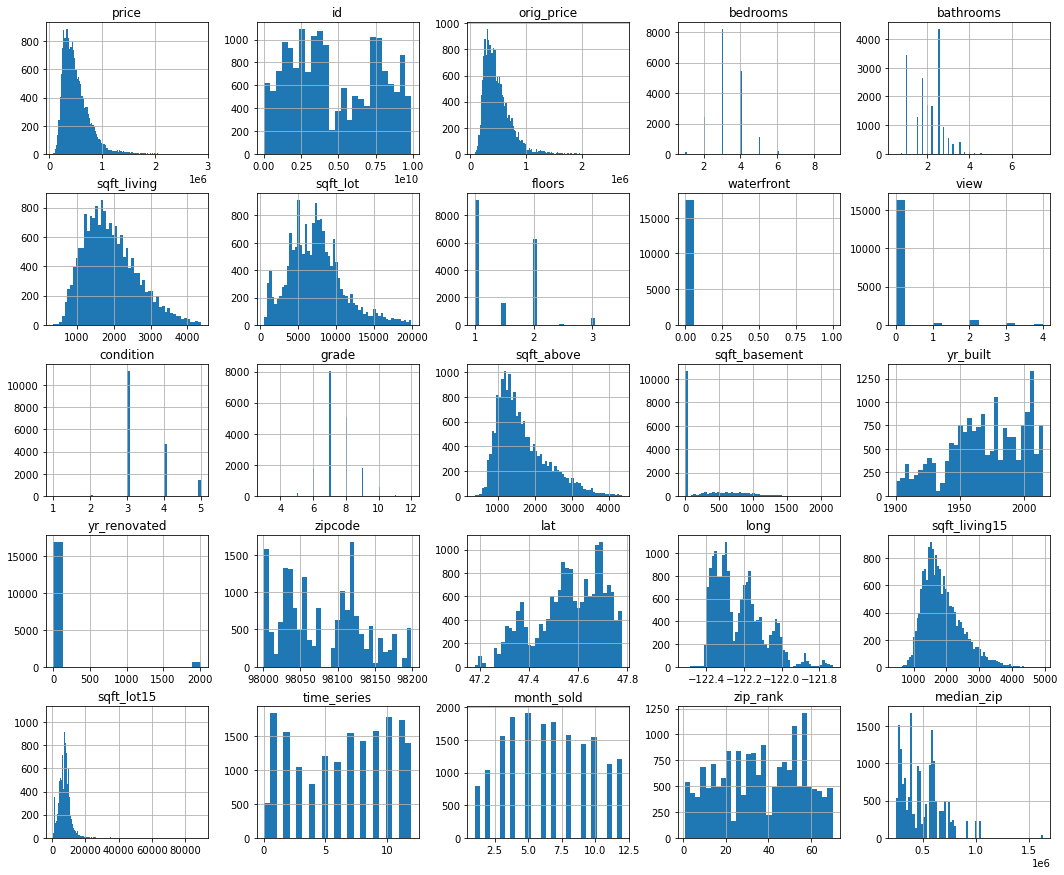

In [36]:
# check how our histograms are looking

df.hist(figsize=(18,15), bins='auto');

#Our histograms have improved a lot.

### Missing Data

In [37]:
# look for missing data
df.isna().sum()

# no missing values

price            0
id               0
orig_price       0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
time_series      0
month_sold       0
zip_rank         0
median_zip       0
dtype: int64

### Binary data

There are a few columns that I might want to be binary flags. I need to see what value choices are in these columns.

In [38]:
df['yr_renovated'].value_counts(normalize=True).head(10)
# 96% of houses have not been renovated, so we will turn this into a binary flag

0       0.962940
2014    0.004611
2013    0.001708
2007    0.001480
2000    0.001366
2005    0.001309
2003    0.001252
2004    0.001139
2006    0.000968
2009    0.000968
Name: yr_renovated, dtype: float64

In [39]:
df['waterfront'].value_counts(normalize=True).head(10)
# Hardly any homes on the waterfront, and it's already a binary flag

0    0.998805
1    0.001195
Name: waterfront, dtype: float64

In [40]:
df['view'].value_counts(normalize=True).head(10)
# most houses don't have a view, but we have a few distinct choices, so we will KEEP this categorical 

0    0.930149
2    0.037117
3    0.014574
1    0.013720
4    0.004440
Name: view, dtype: float64

In [41]:
df['sqft_basement'].value_counts(normalize=True).head(10)
#Many properties don't have basements, but enough do to keep this as a continuous

0       0.610839
500     0.010816
700     0.010759
600     0.010475
800     0.009905
400     0.009222
300     0.007230
900     0.006376
1000    0.005921
720     0.005408
Name: sqft_basement, dtype: float64

In [42]:
#So, will change all values > 0 in those columns to 1
# this will turn renovated into dichotomous choice flags
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

# now anything that is not a 1 becomes a 0, just in case we missed something weird
df.loc[df['yr_renovated'] != 1, 'yr_renovated'] = 0

# since we're making it a binary flag, we'll rename yr_renovated to renovated
df.rename(columns={'yr_renovated' : 'renovated'}, inplace=True)

In [43]:
# We're trying out engineering a feature that penalizes or rewards being the smallest or biggest
# property in the neighborhood, as generally you don't want to be either. This is attempting 
# to impose a categorical relationship on how the property relates to its neighbors

df['comparative_sf'] = 0
df.loc[df['sqft_living'] <= (df['sqft_living15']*.75), 'comparative_sf'] = '1'
df.loc[(df['sqft_living'] > (df['sqft_living15']*.75)) & (df['sqft_living'] < (df['sqft_living15']*1.25)), 'comparative_sf'] = '2'
df.loc[df['sqft_living'] >= (df['sqft_living15']*1.25), 'comparative_sf'] = '3'

In [44]:
# We're making all 0 basement values 1, and 0 view values .01, so that we can log transform this column ( cannot log 0)
df.loc[df['sqft_basement'] == 0, 'sqft_basement'] = 1
df.loc[df['view'] == 0, 'view'] = .01

### Visualize Cleaned Data

In [45]:
# redo our zip code medians and rankings after data cleaning for visualizations
# this is a repeat of the task we did further up

# apply the median home price per zip code to the data frame again after outlier removal
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

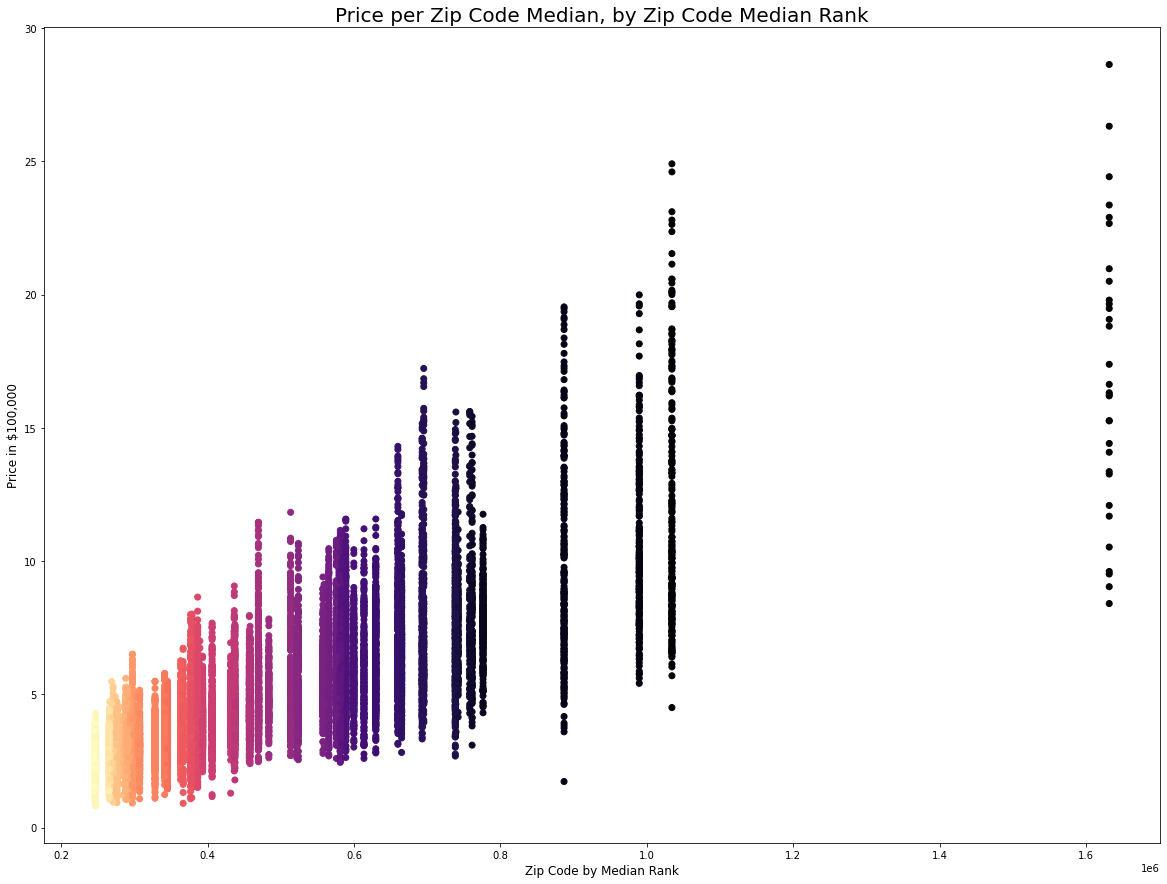

In [46]:
# re-visualize zip code as a color function, using the median zip after outlier removal. 

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')

''

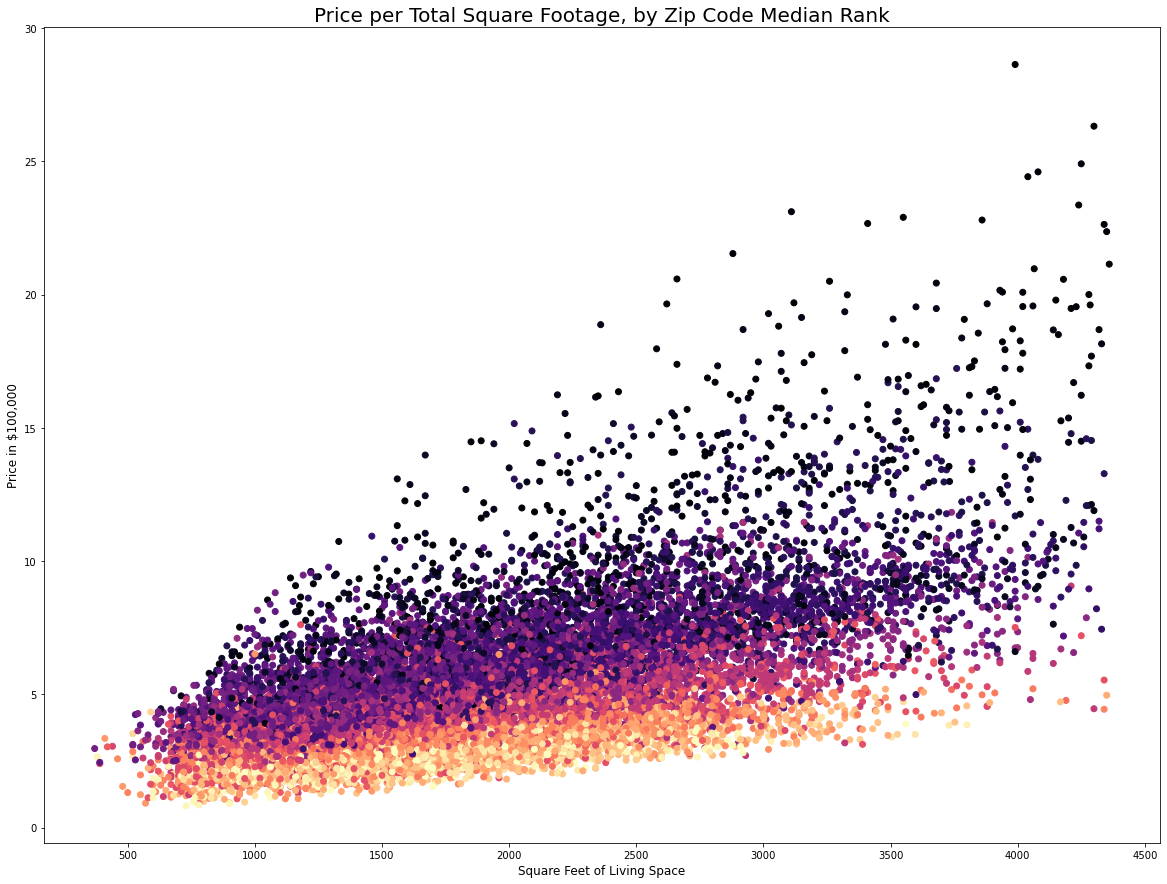

In [47]:
# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['sqft_living'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)
;

Here's a fun way to see the improvements to our data quality after we clean outliers! A much deeper color map.

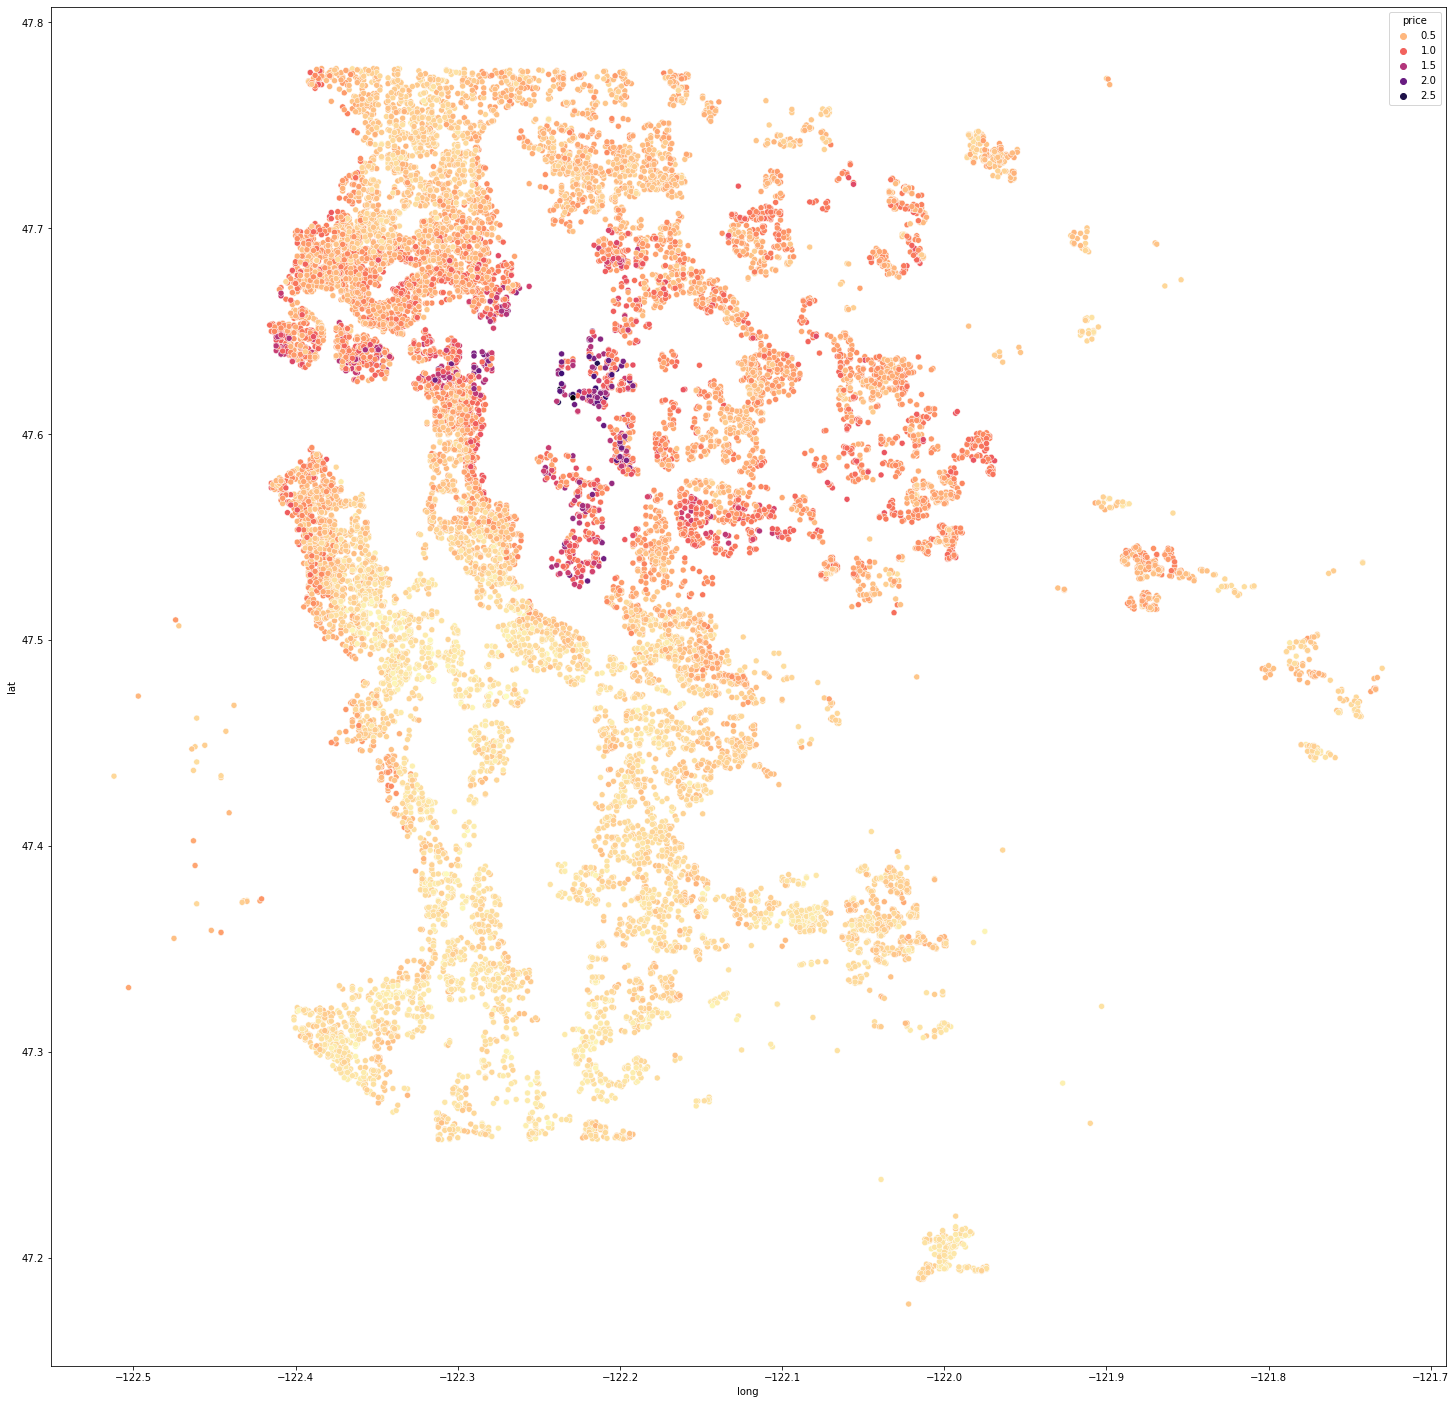

In [48]:
# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates
# the removal of extreme price outliers.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");

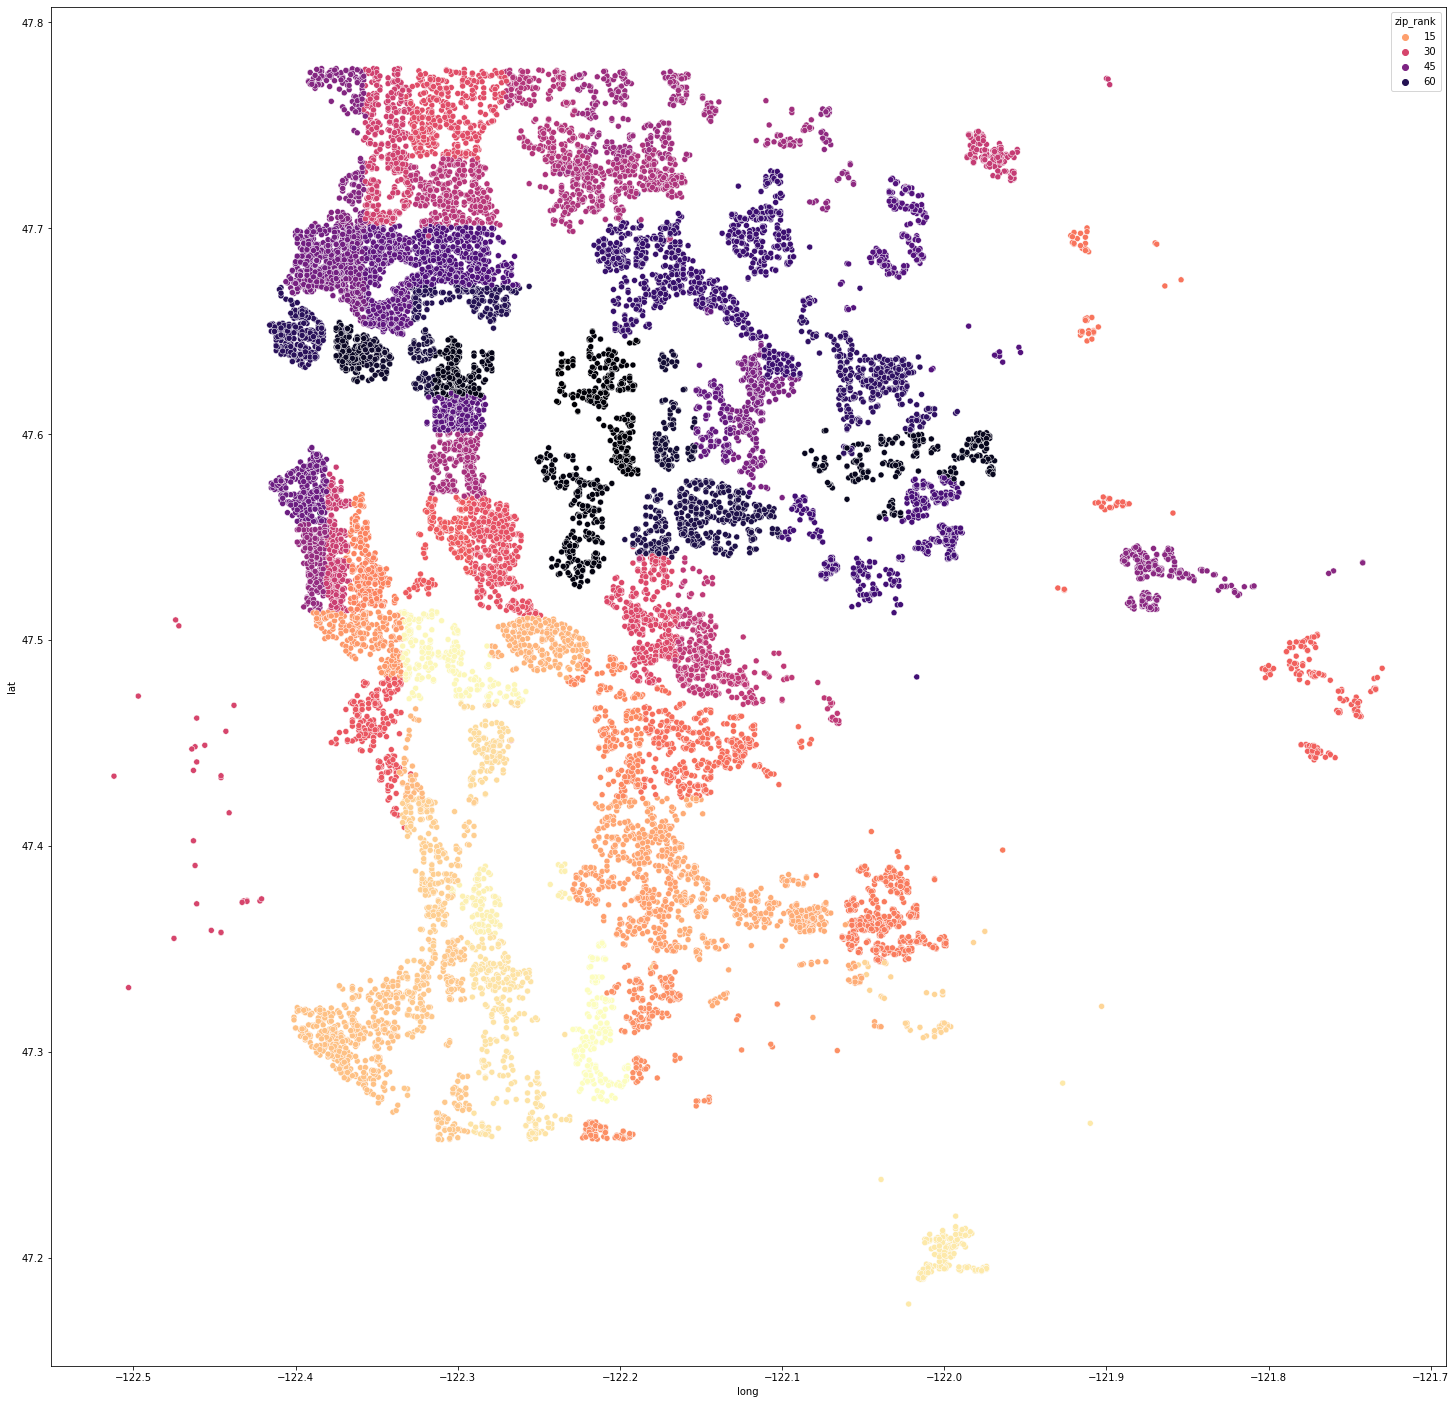

In [49]:
# We can also use our scatter to see the zip codes by rank! Pretty cool.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="zip_rank", palette="magma_r");

### Study Target Variable

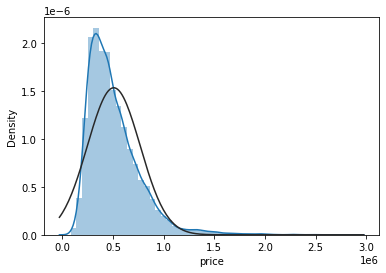

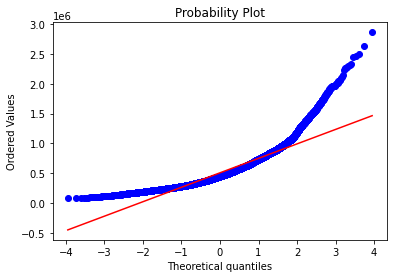

In [50]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [51]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in the right skew.

Skewness: 1.825966
Kurtosis: 5.926294


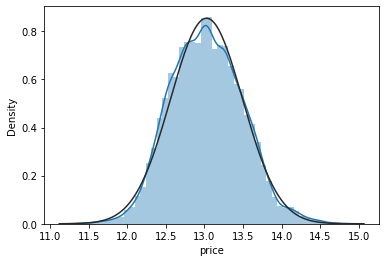

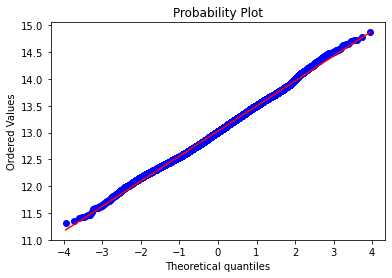

In [52]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that


## Create Holdout Set

We need to separate our holdout data before any further processing.

The reasons for this are:

    * We will standardize our continuous variables, and you should standardize only on your train set and apply that to your test set.
    * We will be feature engineering on our train set, and applying that later to our test set. We cannot have our test set data leak into our engineered features.

In [53]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 4

# creating our train/validation sets and our test sets
y = pd.DataFrame(df['price'])
train_data, holdout, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=randomstate)

# reset indices to prevent any index mismatches
train_data.reset_index(inplace=True)
train_data.drop('index', axis=1, inplace=True)

holdout.reset_index(inplace=True)
holdout.drop('index', axis=1, inplace=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Feature Engineering

We're going to do some target-encoded feature engineering on our data set, using additive smoothing based on this article by Max Halford https://maxhalford.github.io/blog/target-encoding/

Using this method we'll add features for:
   * smoothed zip code
   * smoothed year
   * smoothed month sold
   * smoothed latitude
   * smoothed longitude
   * lat/long zone as function of smoothed lat and smoothed long

This feature engineering is the primary reason that we chose to separate our holdout set before any other processing. We cannot, under any circumstances, use the test data to inform our train set features!

In [54]:
# Adding target encoding, which we will opt to try instead of one-hot with a few models

# this function is by Max Halford at the address noted above
def calc_smooth_mean(df, by, on, m, target_df):
    '''input a pandas.DataFrame, a categorical column name, the name of the target column, and a weight .'''
    # Compute the global mean
    mean = df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 

# get size of training data
num_of_samples = train_data.shape[0]

# determining minimum number of samples for zip and month to use their
# own mean rather than expanding into the full data set mean 
zip_samples = num_of_samples/train_data['zipcode'].unique().shape[0]
month_samples = num_of_samples/train_data['month_sold'].unique().shape[0]

# create smooth additive encoded variables for zipcode, year built, and monthsold
train_data['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, train_data)
train_data['year_smooth'] = calc_smooth_mean(train_data, 'yr_built', 'price', 300, train_data)
train_data['month_smooth'] = calc_smooth_mean(train_data, 'month_sold', 'price', month_samples, train_data)

# Create a wider lat and long zone to calculate an area mean
train_data['lat_zone'] = round(train_data['lat'], 2)
train_data['long_zone'] = round(train_data['long'], 2)

# determing min number samples for lat and long mean
lat_samples = num_of_samples/train_data['lat_zone'].unique().shape[0]
long_samples = num_of_samples/train_data['long_zone'].unique().shape[0]

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
train_data['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, train_data)
train_data['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, train_data)
train_data['lat_long'] = (np.sqrt(train_data['lat_smooth']) + np.sqrt(train_data['long_smooth']))

## Correlations/Multicollinearity

Time to check and remove any features with high collinearity.

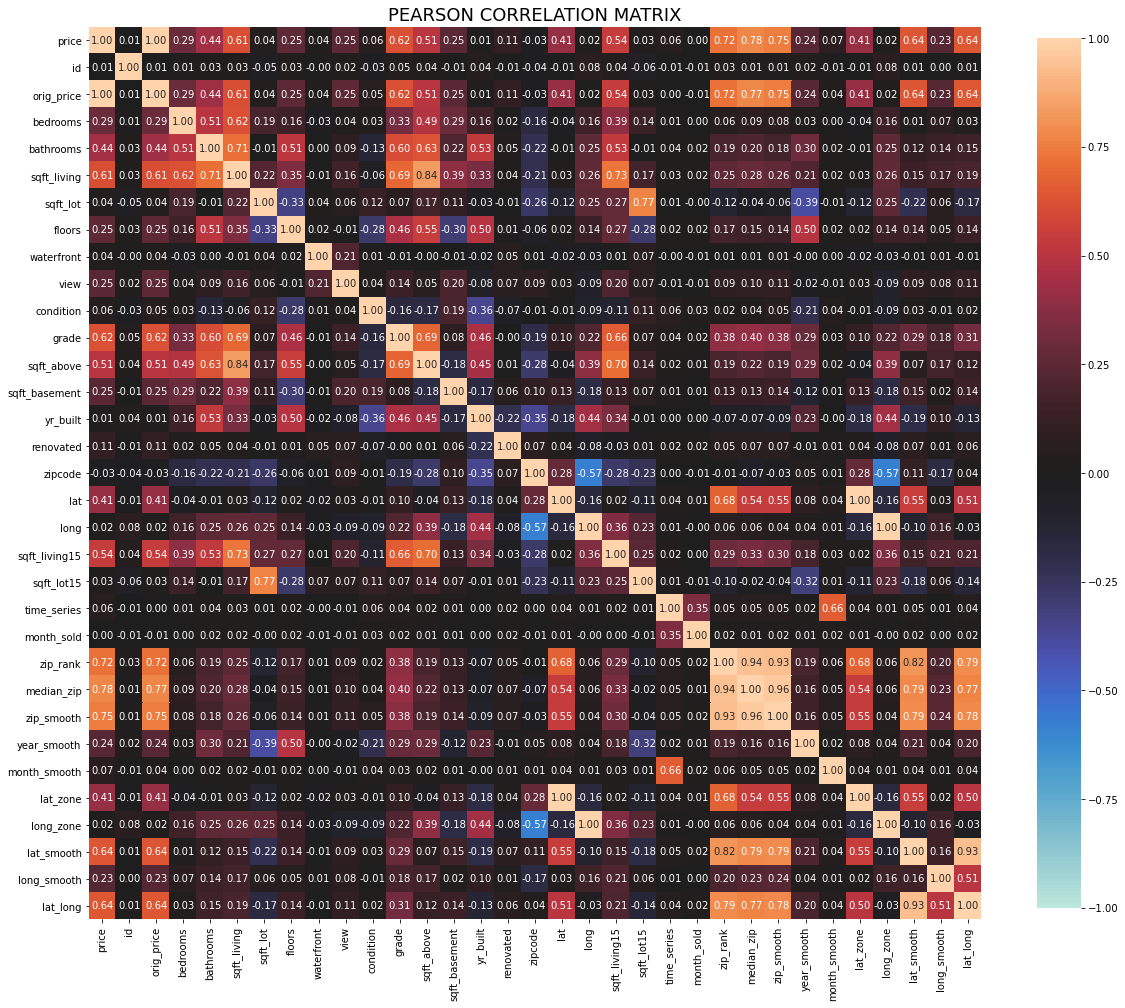

In [55]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(train_data.corr(), center=0, annot=True, fmt=".2f", 
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [56]:
train_data.corr()

price        id  orig_price  bedrooms  bathrooms  \
price          1.000000  0.006547    0.998228  0.294011   0.438381   
id             0.006547  1.000000    0.007156  0.011939   0.032180   
orig_price     0.998228  0.007156    1.000000  0.293944   0.437201   
bedrooms       0.294011  0.011939    0.293944  1.000000   0.506511   
bathrooms      0.438381  0.032180    0.437201  0.506511   1.000000   
sqft_living    0.613302  0.033513    0.612224  0.619782   0.712416   
sqft_lot       0.039641 -0.052238    0.039137  0.193486  -0.008665   
floors         0.253583  0.028118    0.252607  0.162228   0.511323   
waterfront     0.037157 -0.001991    0.038047 -0.026878   0.000709   
view           0.249568  0.023807    0.250270  0.036626   0.091211   
condition      0.058191 -0.031853    0.054602  0.031674  -0.134622   
grade          0.624418  0.045814    0.622826  0.327534   0.602796   
sqft_above     0.507703  0.039042    0.506662  0.489117   0.631341   
sqft_basement  0.246940 -0.005617    0.246759  0.290124   0.216522   
yr_built       0.008215  0.042334    0.008477  0.156776   0.529858   
renovated      0.108059 -0.014606    0.106835  0.015337   0.045191   
zipcode       -0.034468 -0.036132   -0.034284 -0.164580  -0.217217   
lat            0.411013 -0.005851    0.410198 -0.036181  -0.008085   
long           0.016940  0.077730    0.016027  0.156966   0.252315   
sqft_living15  0.541659  0.040068    0.540606  0.390471   0.525240   
sqft_lot15     0.032417 -0.058166    0.031688  0.138407  -0.009660   
time_series    0.057739 -0.009457    0.004678  0.008481   0.035753   
month_sold     0.004790 -0.011986   -0.013604  0.001787   0.017651   
zip_rank       0.722859  0.032214    0.721540  0.062371   0.191047   
median_zip     0.775287  0.014725    0.774382  0.087478   0.204020   
zip_smooth     0.751461  0.013117    0.750107  0.075647   0.179426   
year_smooth    0.240917  0.024812    0.240303  0.029794   0.300636   
month_smooth   0.072627 -0.006318    0.038241  0.004801   0.024502   
lat_zone       0.410987 -0.005640    0.410163 -0.035908  -0.008043   
long_zone      0.017020  0.077528    0.016109  0.156835   0.252540   
lat_smooth     0.638481  0.005409    0.637386  0.011006   0.115051   
long_smooth    0.233020  0.003954    0.232814  0.071192   0.137197   
lat_long       0.642772  0.008096    0.641732  0.033900   0.149696   

               sqft_living  sqft_lot    floors  waterfront      view  \
price             0.613302  0.039641  0.253583    0.037157  0.249568   
id                0.033513 -0.052238  0.028118   -0.001991  0.023807   
orig_price        0.612224  0.039137  0.252607    0.038047  0.250270   
bedrooms          0.619782  0.193486  0.162228   -0.026878  0.036626   
bathrooms         0.712416 -0.008665  0.511323    0.000709  0.091211   
sqft_living       1.000000  0.222249  0.346500   -0.007986  0.162202   
sqft_lot          0.222249  1.000000 -0.333928    0.035140  0.061578   
floors            0.346500 -0.333928  1.000000    0.015479 -0.013793   
waterfront       -0.007986  0.035140  0.015479    1.000000  0.214660   
view              0.162202  0.061578 -0.013793    0.214660  1.000000   
condition        -0.055052  0.124586 -0.277270    0.009022  0.037328   
grade             0.687914  0.071461  0.461130   -0.006502  0.144914   
sqft_above        0.837992  0.174355  0.548332   -0.004679  0.053097   
sqft_basement     0.385525  0.105880 -0.302666   -0.006485  0.202600   
yr_built          0.329534 -0.029987  0.497689   -0.024067 -0.081308   
renovated         0.035385 -0.014311  0.007875    0.047063  0.067109   
zipcode          -0.208070 -0.262600 -0.063995    0.006767  0.093458   
lat               0.028740 -0.124716  0.022666   -0.020920  0.030881   
long              0.262072  0.254625  0.141254   -0.031088 -0.085833   
sqft_living15     0.731447  0.268831  0.272436    0.007546  0.204042   
sqft_lot15        0.168299  0.769360 -0.277323    0.070092  0.067364   
time_series       0.031186  0.005095  0.023698   -0.0

In [57]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 70% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


level_0      level_1  correlation
pairs                                                           
(zip_rank, median_zip)        zip_rank   median_zip     0.943143
(median_zip, zip_rank)      median_zip     zip_rank     0.943143
(zip_smooth, zip_rank)      zip_smooth     zip_rank     0.934948
(zip_rank, zip_smooth)        zip_rank   zip_smooth     0.934948
(lat_long, lat_smooth)        lat_long   lat_smooth     0.932996
(lat_smooth, lat_long)      lat_smooth     lat_long     0.932996
(sqft_living, sqft_above)  sqft_living   sqft_above     0.837992
(sqft_above, sqft_living)   sqft_above  sqft_living     0.837992
(lat_smooth, zip_rank)      lat_smooth     zip_rank     0.816590
(zip_rank, lat_smooth)        zip_rank   lat_smooth     0.816590
(zip_smooth, lat_smooth)    zip_smooth   lat_smooth     0.792476
(lat_smooth, zip_smooth)    lat_smooth   zip_smooth     0.792476
(lat_long, zip_rank)          lat_long     zip_rank     0.790566
(zip_rank, lat_long)          zip_rank     lat_long     0.790566
(median_zip, lat_smooth)    median_zip   lat_smooth     0.786015
(lat_smooth, median_zip)    lat_smooth   median_zip     0.786015
(lat_long, zip_smooth)        lat_long   zip_smooth     0.783171
(zip_smooth, lat_long)      zip_smooth     lat_long     0.783171
(median_zip, price)         median_zip        price     0.775287
(price, median_zip)              price   median_zip     0.775287
(median_zip, orig_price)    median_zip   orig_price     0.774382
(orig_price, median_zip)    orig_price   median_zip     0.774382
(lat_long, median_zip)        lat_long   median_zip     0.772724
(median_zip, lat_long)      median_zip     lat_long     0.772724
(sqft_lot15, sqft_lot)      sqft_lot15     sqft_lot     0.769360
(sqft_lot, sqft_lot15)        sqft_lot   sqft_lot15     0.769360
(price, zip_smooth)              price   zip_smooth     0.751461
(zip_smooth, price)         zip_smooth        price     0.751461
(zip_smooth, orig_price)    zip_smooth   orig_price     0.750107
(orig_price, zip_smooth)    orig_price   zip_smooth     0.750107

median_zip, zip_rank and orig_price are dummy variables that we won't be using, so we can ignore correlations using those for now.

We drop sqft_above and sqft_lot15

In [58]:
# drop multicollinear features and unneeded features
train_data.drop(['id', 'zip_rank', 'median_zip', 'sqft_above', 'sqft_lot15'], axis=1, inplace=True)

In [59]:
# Check out our variables correlationg with price
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

level_0        level_1         0
0    price          price  1.000000
1    price     orig_price  0.998228
20   price     zip_smooth  0.751461
27   price       lat_long  0.642772
25   price     lat_smooth  0.638481
10   price          grade  0.624418
4    price    sqft_living  0.613302
17   price  sqft_living15  0.541659
3    price      bathrooms  0.438381
15   price            lat  0.411013
23   price       lat_zone  0.410987
2    price       bedrooms  0.294011
6    price         floors  0.253583
8    price           view  0.249568
11   price  sqft_basement  0.246940
21   price    year_smooth  0.240917
26   price    long_smooth  0.233020
13   price      renovated  0.108059
22   price   month_smooth  0.072627
9    price      condition  0.058191
18   price    time_series  0.057739
5    price       sqft_lot  0.039641
7    price     waterfront  0.037157
14   price        zipcode  0.034468
24   price      long_zone  0.017020
16   price           long  0.016940
12   price       yr_built  0.008215
19   price     month_sold  0.004790

It looks like zip code works better than the lat/long zones I made. We should also note here that zip and lat/long descriptors are all highly correlated, so we should consider if we need to include all of them in our model or just the best one (zipcode)

We can get a sense of the most important features to our price from our correlation table. Zipcode as a plain variable does not correlate, which makes sense, because without some sort of transformation it is an arbitrary unordered number. We can see how transformed as zip_smooth, median_zip, or zip_rank it becomes the MOST important contributor to price. We can see here that big contributors to price include:
    
    * zip code (in some altered form, not as arbitrary number)
    * grade
    * sqft_living
    * bathrooms

## EDA and Process Train Set

### Categoricals

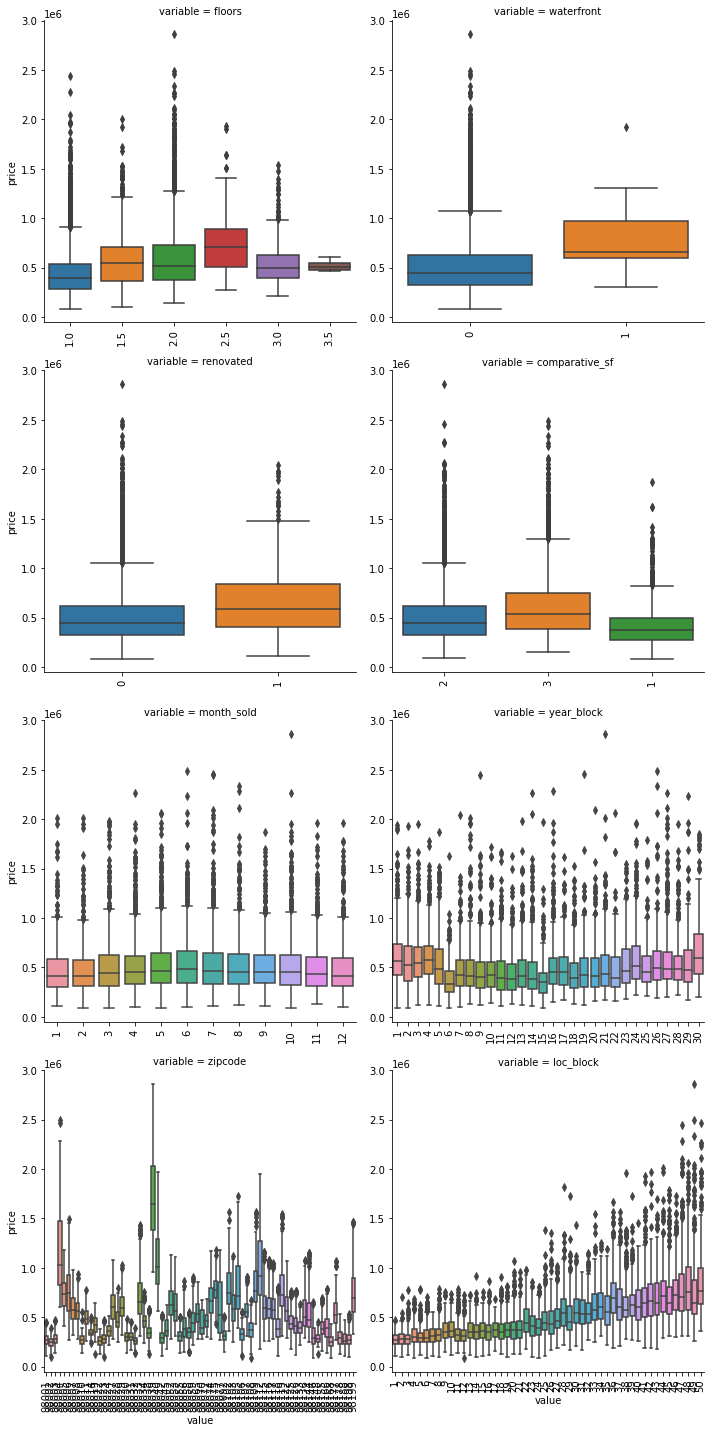

In [60]:
categoricals = ['floors', 'waterfront', 'renovated', 'comparative_sf', 'month_sold', 'yr_built', 'zipcode', 'lat_long'] #

# make our categorical data frame to work with
df_categoricals = train_data[categoricals]

# binning our year built bins
df_categoricals["year_block"] = pd.qcut(df_categoricals['yr_built'], q=30, labels=np.array(range(1,30+1)))

# binning our latitude bins
df_categoricals["loc_block"] = pd.qcut(df_categoricals['lat_long'], q=50, labels=np.array(range(1,50+1)))

# dropping the original categories we just binned
df_categoricals.drop(['yr_built', 'lat_long'], axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in df_categoricals.columns:
    df_categoricals[item] = df_categoricals[item].astype('category')

# temporarily adding price to our dataframe so that we can do some visualizations    
df_categoricals['price'] = train_data['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

    #visualization categories
categorical=['floors', 'waterfront', 'renovated', 'comparative_sf', 'month_sold', 'year_block', 'zipcode', 'loc_block']
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

df_categoricals.drop('price', axis=1, inplace=True)

In [61]:
# make a processed bins file for use with linear regression
# We're making TWO categorical sets. One is high one hot encoding. One is low one hot encoding, and the 
# categoricals in that one will be target encoded as continuous instead

high_one_hot_cat =  ['floors', 'waterfront', 'renovated','comparative_sf', 'zipcode', 'month_sold', 'year_block', 'loc_block']
low_one_hot_cat =  ['floors', 'waterfront', 'renovated','comparative_sf']

df_cats_high_one_hot = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Continuous

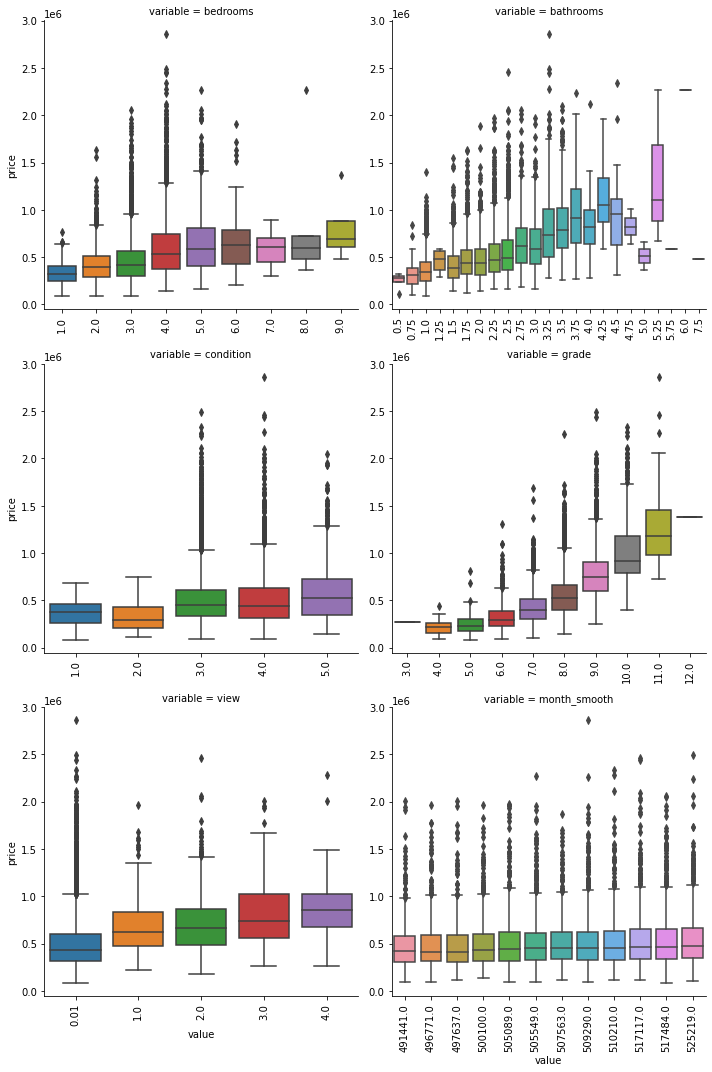

In [62]:
continuous = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'condition', 'grade', 'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long'] #'floors',  

# make our continuous frame to work with
x_continuous = train_data[continuous]
x_continuous['price'] = train_data['price']

# plot our smaller choice continuous as box plots vs price
small_cont = ['bedrooms', 'bathrooms', 'condition', 'grade', 'view', 'month_smooth'] 

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(x_continuous, id_vars=['price'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

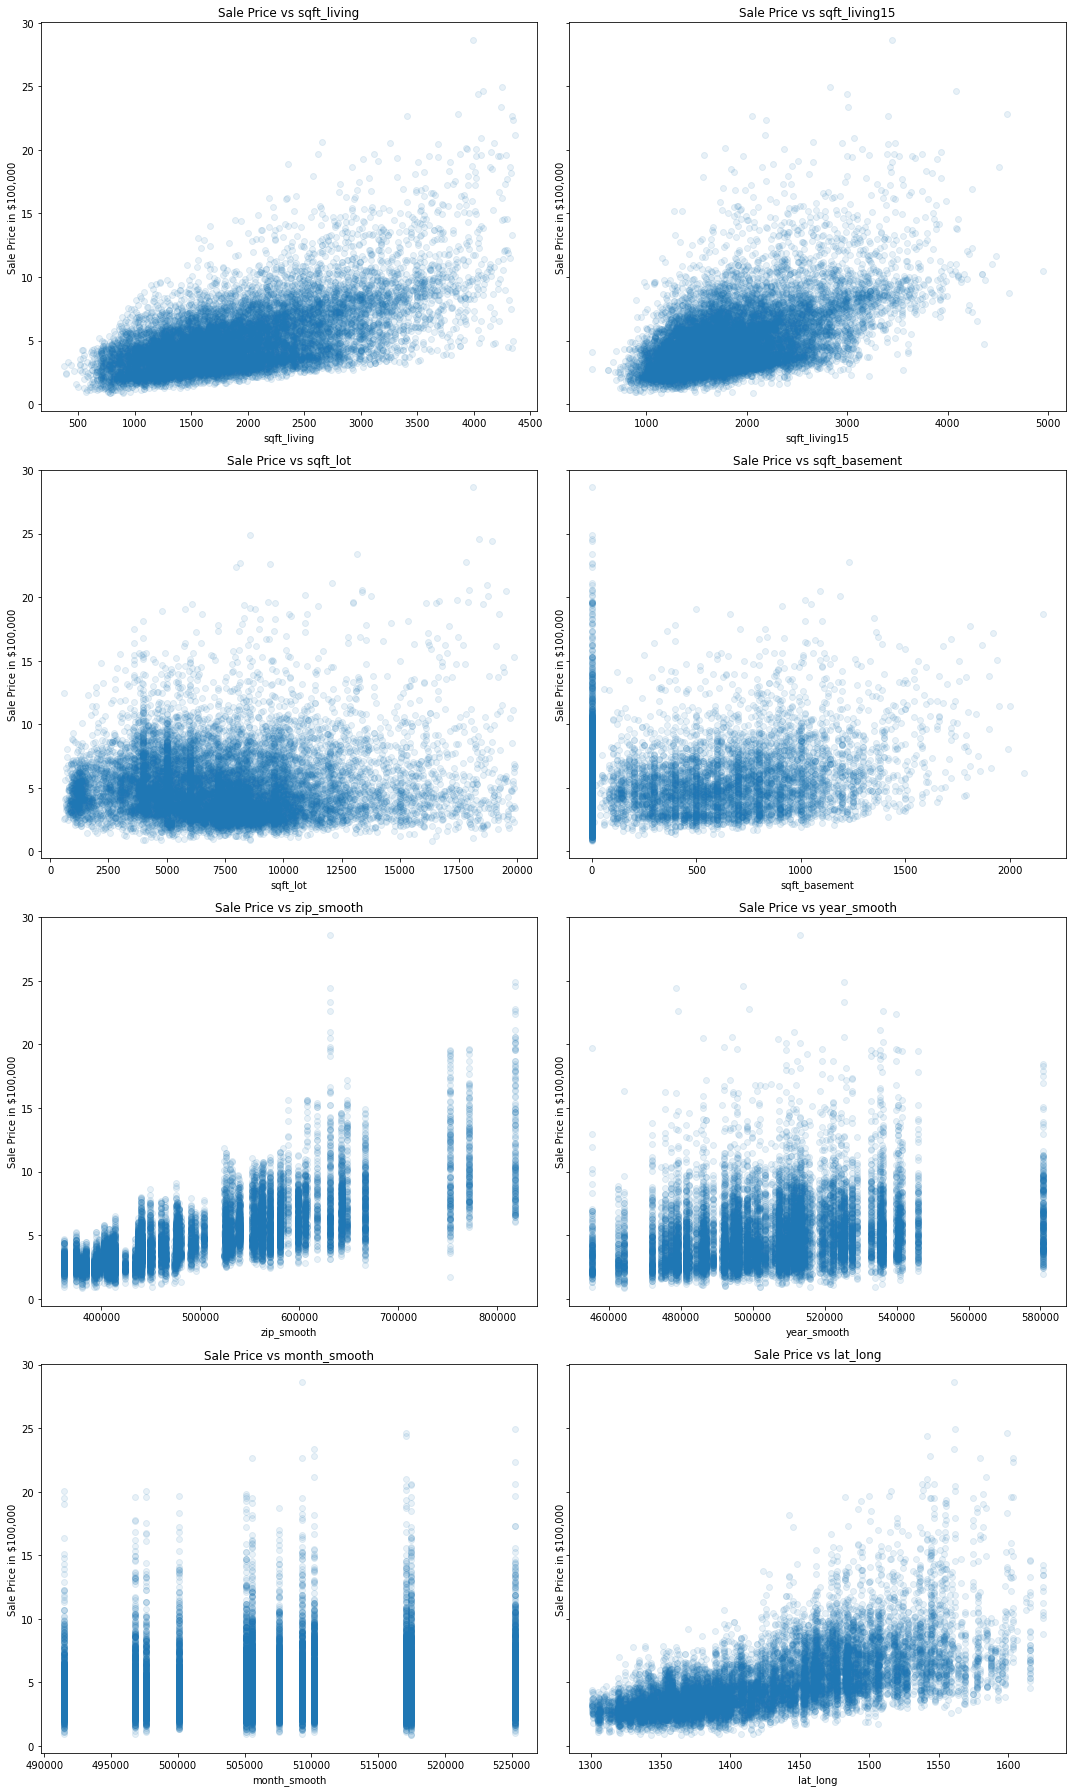

In [63]:
# plot our larger continuous as scatter plots vs price
large_cont = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), large_cont):
    ax.scatter(x_continuous[column], x_continuous['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

x_continuous.drop('price', axis=1, inplace=True)

    * sqft_living, sqft_living15, zip_smooth, lat_long, sqft_basement(when present) have a very strong visual relationship with price
    * sqft_lot do not appear to have a strong relationship with price
    * year_smooth and month_smooth are unclear, we will investigate further

Fun fact - "grade" was not well defined in the features list. I looked it up and found that grade is "	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value." So, it's the quality of building materials, and DEFINITELY worth keeping in our model.

#### Looking for polynomial relationships

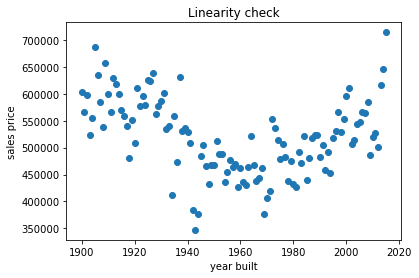

In [64]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = train_data.groupby('yr_built')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()

Seems like year built might have a polynomial relationship with price

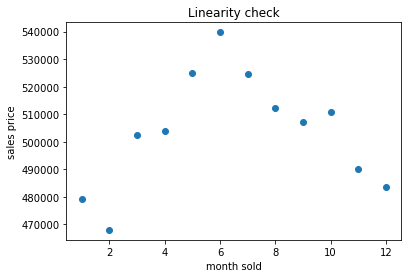

In [65]:
# Checking out our mean sales price for month sold scattered versus price shows a polynomial relationship
monthly_prices = train_data.groupby('month_sold')['price'].mean()

plt.scatter(monthly_prices.index, monthly_prices)
plt.title("Linearity check")
plt.xlabel('month sold')
plt.ylabel('sales price')
plt.show()

Month sold may also have a polynomial relationship

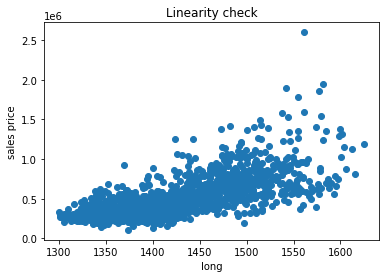

In [66]:
# Checking out our mean sales price for longitude does not show a polynomial relationship
long_prices = train_data.groupby('lat_long')['price'].mean()

plt.scatter(long_prices.index, long_prices)
plt.title("Linearity check")
plt.xlabel('long')
plt.ylabel('sales price')
plt.show()

There does not appear to be a polynomial relationship

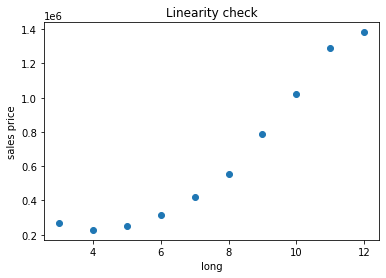

In [67]:
# Checking out our mean sales price for grade shows a polynomial relationship
grade_prices = train_data.groupby('grade')['price'].mean()

plt.scatter(grade_prices.index, grade_prices)
plt.title("Linearity check")
plt.xlabel('long')
plt.ylabel('sales price')
plt.show()

Grade appears to have a polynomial relationship

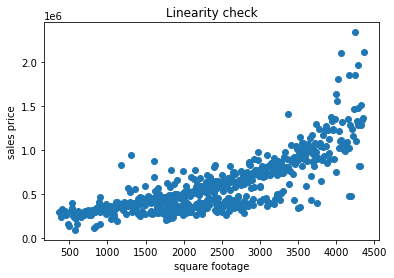

In [68]:
# Checking out our mean sales price for grade shows a polynomial relationship
grade_prices = train_data.groupby('sqft_living')['price'].mean()

plt.scatter(grade_prices.index, grade_prices)
plt.title("Linearity check")
plt.xlabel('square footage')
plt.ylabel('sales price')
plt.show()

Square foot living may have a polynomial relationship

#### Finding Interactions

I wrote a function which finds all of the feature combinations possible in our dataset. Then for each combination, the function runs a linear regression with cross validation on 5 folds and gets the r^2 score for the regression including that feature combination. All scores are recorded and r^2 score improvement is assessed, with the resulting table giving the increase in model improvement from a feature combo. 

In [69]:
def test_feature_combinations(price, variables):
    
    """Function takes in target price and a dataframe of independent variables, and 
    tests model improvement for each combination of variables
    ARGUMENTS:
    Y of target values
    X-dataframe of continuous features
    Returns dataframe of score improvements over base score for each interaction combination"""
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df

In [70]:
# running our function on our continuous variables to look for improvement
# our R2 is much lower for model base score because we aren't including our categorical variables in this improvement assessment

scoring_df = test_feature_combinations(y_train, x_continuous)

Model base score is  0.7911
sqft_living sqft_living15 0.7926
sqft_living sqft_lot 0.7909
sqft_living sqft_basement 0.7922
sqft_living view 0.7912
sqft_living bedrooms 0.7919
sqft_living bathrooms 0.7989
sqft_living condition 0.7918
sqft_living grade 0.8022
sqft_living zip_smooth 0.8151
sqft_living year_smooth 0.7939
sqft_living month_smooth 0.7914
sqft_living lat_long 0.8085
sqft_living15 sqft_lot 0.7914
sqft_living15 sqft_basement 0.7937
sqft_living15 view 0.7922
sqft_living15 bedrooms 0.7913
sqft_living15 bathrooms 0.7931
sqft_living15 condition 0.7941
sqft_living15 grade 0.7935
sqft_living15 zip_smooth 0.801
sqft_living15 year_smooth 0.791
sqft_living15 month_smooth 0.7913
sqft_living15 lat_long 0.798
sqft_lot sqft_basement 0.792
sqft_lot view 0.7907
sqft_lot bedrooms 0.7917
sqft_lot bathrooms 0.7914
sqft_lot condition 0.7915
sqft_lot grade 0.7912
sqft_lot zip_smooth 0.7917
sqft_lot year_smooth 0.7917
sqft_lot month_smooth 0.791
sqft_lot lat_long 0.791
sqft_basement view 0.791
sqft_

In [71]:
# showing our improvement scores for our interactions

scoring_df.sort_values('improvement', ascending=False)

feature1      feature2  scores  improvement
8     sqft_living    zip_smooth  0.8151       0.0240
11    sqft_living      lat_long  0.8085       0.0174
68          grade    zip_smooth  0.8065       0.0154
59      bathrooms    zip_smooth  0.8058       0.0147
7     sqft_living         grade  0.8022       0.0111
..            ...           ...     ...          ...
31       sqft_lot  month_smooth  0.7910      -0.0001
55       bedrooms  month_smooth  0.7910      -0.0001
1     sqft_living      sqft_lot  0.7909      -0.0002
34  sqft_basement      bedrooms  0.7909      -0.0002
24       sqft_lot          view  0.7907      -0.0004

[78 rows x 4 columns]

We see there might be a relationship between square footage and our zip code. This makes sense because the size of the house is differently priced depending on location, as we saw in our visualizations earlier.

In [72]:
x_continuous['sqft-zip'] = np.sqrt(x_continuous['sqft_living'] * x_continuous['zip_smooth'])

#### Standardize and Transform

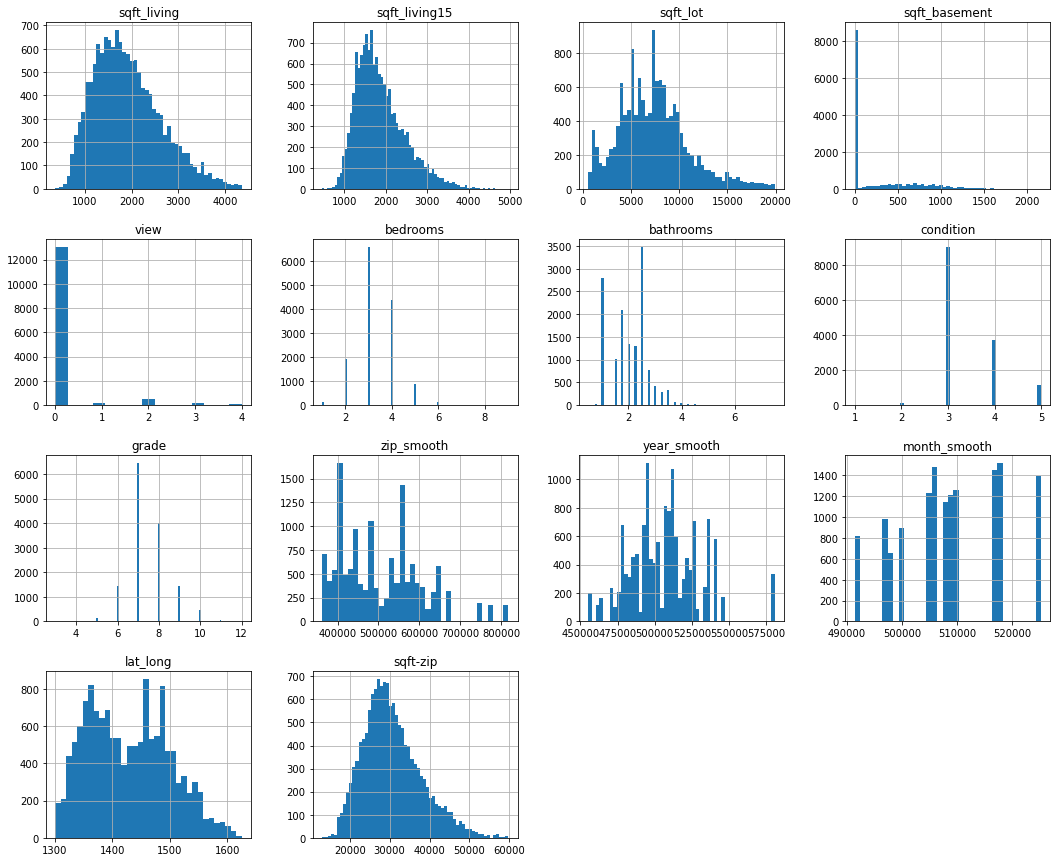

In [73]:
# check out our histograms to see if we should transform our data before scaling

x_continuous.hist(figsize=(18,15), bins='auto');

We will log transform our data, and standardize our continuous inputs.

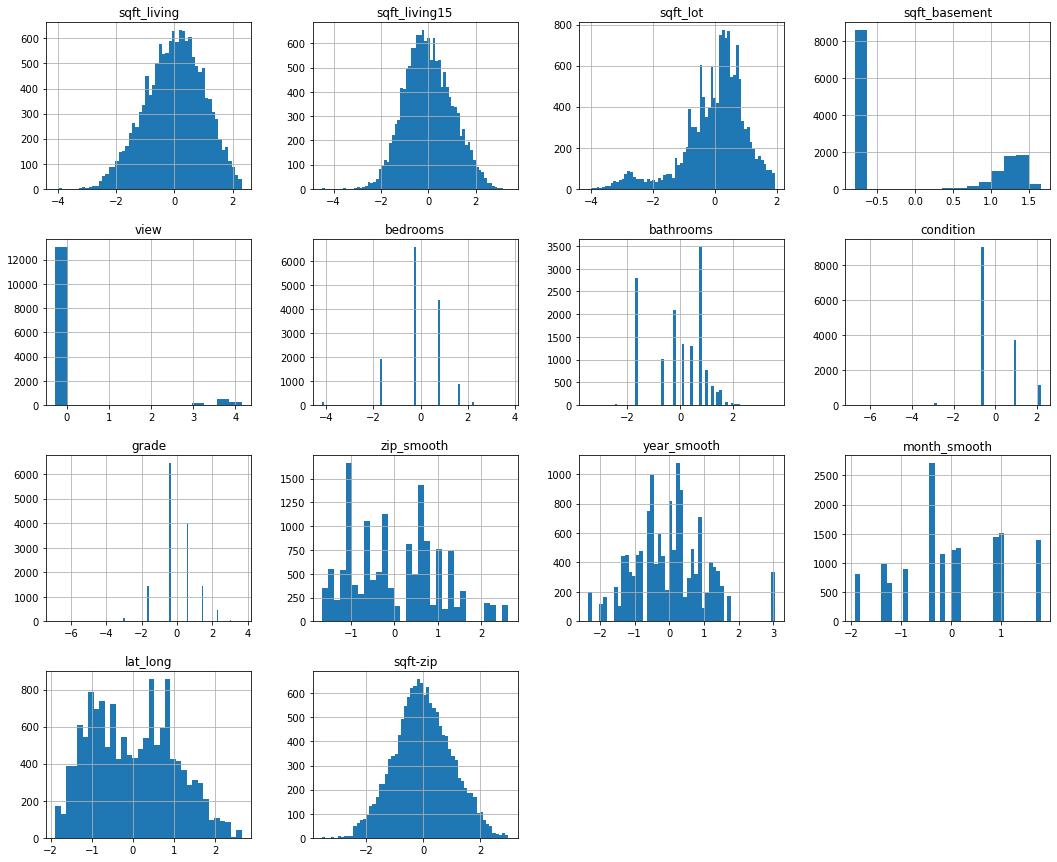

In [74]:
# log transform
log_continuous = np.log(x_continuous)

# standardize all of our values with scikit-learn StandardScaler
scaler = StandardScaler()

scaled_continuous = pd.DataFrame(scaler.fit_transform(log_continuous),columns = log_continuous.columns)
scaled_continuous.head(5)

# Our scaled and transformed continuous features

scaled_continuous.hist(figsize=(18,15), bins='auto');

We're ready to make our final continuous data set. At this point we will make TWO continuous sets, because one of the objectives of this notebook is to study *one-hot encoding* versus *mean target encoding*. So we have one data set for our high one-hot encoding features, and one data set for our mean target encoding features. Later in the notebook we will compare these two features sets in models.

In [75]:
# make a processed bins file for use with linear regression

# our categories for high one-hot encoding and low one-hot encoding
high_one_hot_cont =  ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'grade', 'condition', 'sqft-zip']
low_one_hot_cont =  ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_basement', 'view', 'bedrooms', 'bathrooms', 'grade', 'condition', 'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long', 'sqft-zip']  

df_cont_high_one_hot = scaled_continuous[high_one_hot_cont]
df_cont_low_one_hot = scaled_continuous[low_one_hot_cont]

#### Add polynomial features

Now we will add our polynomial features on our low-one-hot set (in the high-one-hot set, these are categoricals)

In [76]:
def plot_polys(y, xlabel, title):
    '''Takes in a y-axis, x-axis label, and title and plots with various polynomial levels
    ARGUMENTS:
    y axis variable values
    x-axis label
    visualization title'''
    x = y.index
    
    # express numbers as arrays and reshape
    y = np.array(y)
    x = np.array(x)
    x = x.reshape(-1, 1)
    
    # make sure indices match up
    y = y[x[:,0].argsort()]
    x = x[x[:, 0].argsort()]

    # plot figure
    plt.figure(figsize=(16, 8))

    # standard linear regression
    linreg = LinearRegression()
    linreg.fit(x, y)

    # 2nd degree polynomial regression
    poly2 = PolynomialFeatures(degree=2)
    x_poly2 = poly2.fit_transform(x)
    poly_reg2 = LinearRegression()
    poly_reg2.fit(x_poly2, y)

    # third degree polynomial regression 
    poly3 = PolynomialFeatures(degree=3)
    x_poly3 = poly3.fit_transform(x)
    poly_reg3 = LinearRegression()
    poly_reg3.fit(x_poly3, y)

    # predict on x values
    pred = linreg.predict(x)
    pred2 = poly_reg2.predict(x_poly2)
    pred3 = poly_reg3.predict(x_poly3)

    # plot regression lines
    plt.scatter(x, y)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average')
    plt.plot(x, pred, c='red', label='Linear regression line')
    plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
    plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

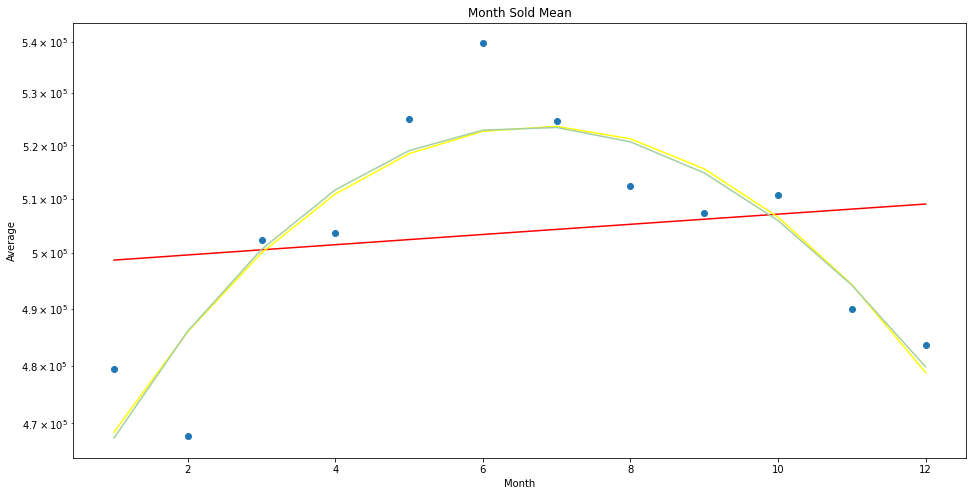

In [77]:
# group by average month sold mean to see relationship
y = train_data.groupby('month_sold')['price'].mean()
plot_polys(y, "Month", "Month Sold Mean")

We'll add month sold as a second degree polynomial.

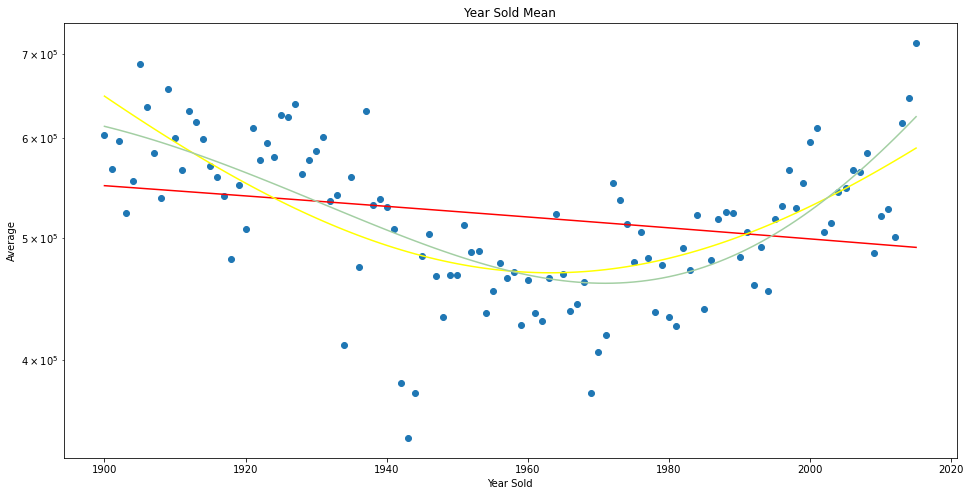

In [78]:
# group by average year built mean to see relationship
y = train_data.groupby('yr_built')['price'].mean()
plot_polys(y, "Year Sold", "Year Sold Mean")

We'll add year built as a second degree polynomial.

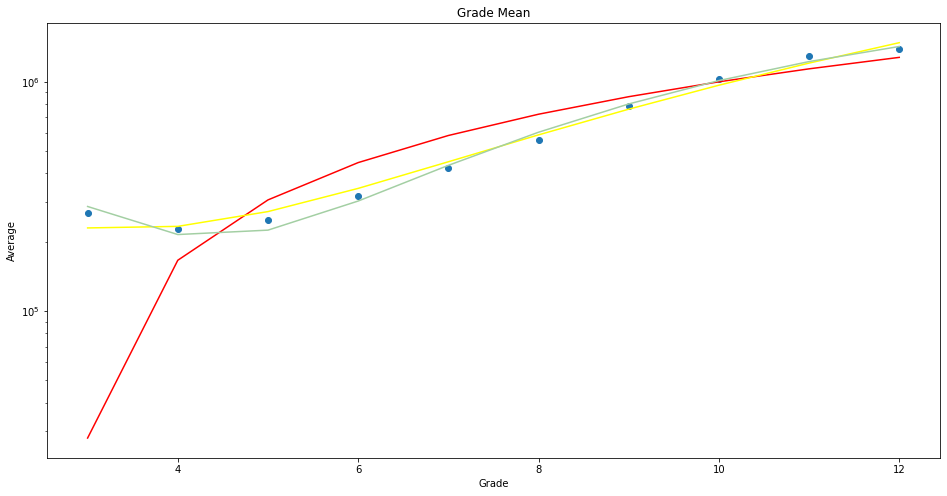

In [79]:
# group by grade mean to see relationship
y = train_data.groupby('grade')['price'].mean()
plot_polys(y,'Grade', "Grade Mean")

We will express this as a second degree polynomial.

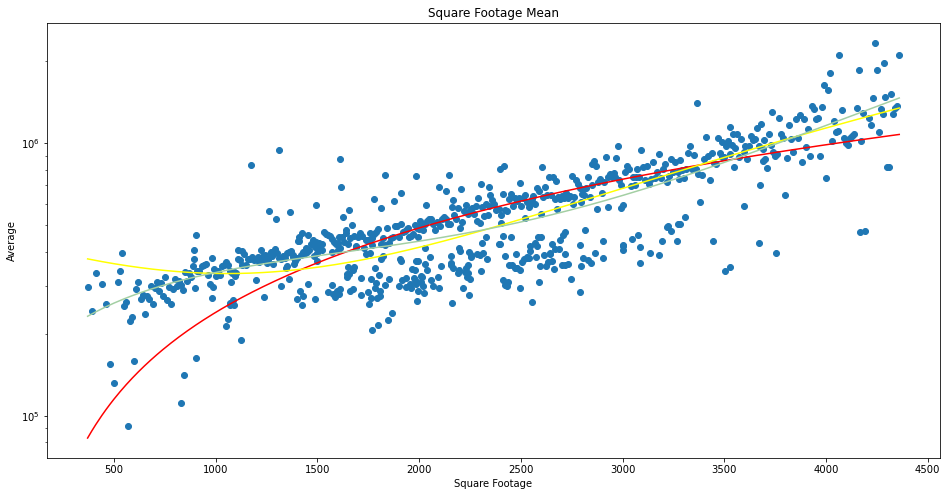

In [80]:
# group by grade mean to see relationship
y = train_data.groupby('sqft_living')['price'].mean()
plot_polys(y,'Square Footage', "Square Footage Mean")

This looks better expressed with a third degree polynomial

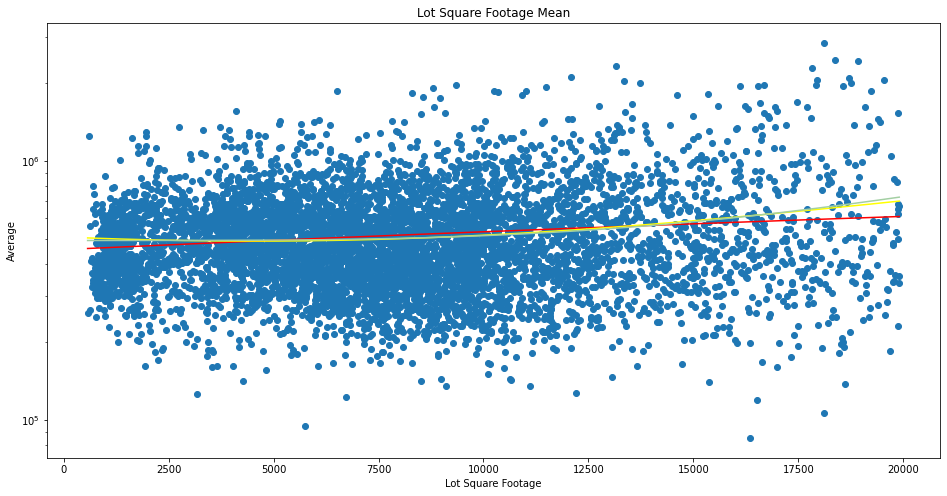

In [81]:
# group by grade mean to see relationship
y = train_data.groupby('sqft_lot')['price'].mean()
plot_polys(y,'Lot Square Footage', "Lot Square Footage Mean")

No clear relationship

In [82]:
# adding our chosen polynomial features

def create_polynomial_array(data, column, num_features):
    values = data[column]
    poly_array = np.array(values)
    poly_array = poly_array.reshape(-1,1)
    poly_fit = PolynomialFeatures(degree=num_features, include_bias=False)
    fit_features = poly_fit.fit_transform(poly_array)
    poly_df = pd.DataFrame(fit_features)
    return poly_df

month_poly = create_polynomial_array(df_cont_low_one_hot, 'month_smooth',2)
year_poly = create_polynomial_array(df_cont_low_one_hot, 'year_smooth', 2)
grade_poly = create_polynomial_array(df_cont_low_one_hot, 'grade', 2)
sq_ft_poly = create_polynomial_array(df_cont_low_one_hot, 'sqft_living', 3)

df_cont_low_one_hot['month1'] = month_poly[1]
df_cont_low_one_hot['grade1'] = grade_poly[1]
df_cont_high_one_hot['grade1'] = grade_poly[1]
df_cont_low_one_hot['year1'] = year_poly[1]
df_cont_low_one_hot['sqft_living2'] = sq_ft_poly[1]
df_cont_high_one_hot['sqft_living2'] = sq_ft_poly[1]
df_cont_low_one_hot['sqft_living3'] = sq_ft_poly[2]
df_cont_high_one_hot['sqft_living3'] = sq_ft_poly[2]

## Process Test Set

We now need to process our holdout in the same way we processed our training set.

In [83]:
# apply target encoding to test data, using train data to map

# create smooth additive encoded variables for zipcode, year built, and monthsold
holdout['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, holdout)
holdout['year_smooth'] = calc_smooth_mean(train_data, 'yr_built', 'price', 300, holdout)
holdout['month_smooth'] = calc_smooth_mean(train_data, 'month_sold', 'price', month_samples, holdout)

# Create a wider lat and long zone to calculate an area mean
holdout['lat_zone'] = round(holdout['lat'], 2)
holdout['long_zone'] = round(holdout['long'], 2)

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
holdout['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, holdout)
holdout['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, holdout)
holdout['lat_long'] = (np.sqrt(holdout['lat_smooth']) + np.sqrt(holdout['long_smooth']))

### Process Categoricals

In [84]:
holdout_categoricals = holdout[categoricals]

# binning our year built bins
holdout_categoricals["year_block"] = pd.qcut(holdout_categoricals['yr_built'], q=30, labels=np.array(range(1,30+1)))

# binning our latitude bins
holdout_categoricals["loc_block"] = pd.qcut(holdout_categoricals['lat_long'], q=50, labels=np.array(range(1,50+1)))

holdout_categoricals.drop(['yr_built'], axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in holdout_categoricals.columns:
    holdout_categoricals[item] = holdout_categoricals[item].astype('category')

# make a processed bins file for use with linear regression
df_cats_high_one_hot_holdout = pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot_holdout = pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Process Continuous

In [85]:
holdout_continuous = holdout[continuous]

# add feature interaction
holdout_continuous['sqft-zip'] = np.sqrt(holdout_continuous['sqft_living'] * holdout_continuous['zip_smooth'])

# log transform
log_holdout = np.log(holdout_continuous)

# standard scaler
scaled_holdout_continuous = pd.DataFrame(scaler.transform(log_holdout),columns = log_holdout.columns)

# making our two continuous sets
df_cont_high_one_hot_holdout = scaled_holdout_continuous[high_one_hot_cont]
df_cont_low_one_hot_holdout = scaled_holdout_continuous[low_one_hot_cont]

# adding polynomial features

month_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'month_smooth',2)
year_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'year_smooth', 2)
grade_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'grade', 2)
sq_ft_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'sqft_living', 3)


df_cont_low_one_hot_holdout['month1'] = month_poly[1]
df_cont_low_one_hot_holdout['grade1'] = grade_poly[1]
df_cont_high_one_hot_holdout['grade1'] = grade_poly[1]
df_cont_low_one_hot_holdout['year1'] = year_poly[1]
df_cont_low_one_hot_holdout['sqft_living3'] = sq_ft_poly[2]
df_cont_high_one_hot_holdout['sqft_living3'] = sq_ft_poly[2]
df_cont_low_one_hot_holdout['sqft_living2'] = sq_ft_poly[1]
df_cont_high_one_hot_holdout['sqft_living2'] = sq_ft_poly[1]

## Create Train/Test Final Set

In [86]:
# make our train sets for one-hot encoded and target-encoded categoricals
X_train_onehot = pd.concat([df_cont_high_one_hot, df_cats_high_one_hot], axis=1)
X_train_encoded = pd.concat([df_cont_low_one_hot, df_cats_low_one_hot], axis=1)

# make our test sets for one-hot encoded and target-encoded categoricals
X_test_onehot = pd.concat([df_cont_high_one_hot_holdout, df_cats_high_one_hot_holdout], axis=1)
X_test_encoded = pd.concat([df_cont_low_one_hot_holdout, df_cats_low_one_hot_holdout], axis=1)

# make our target variable train and test sets, after log transforming our target variable
target = 'price' # target variable
y = np.log(df[target]) # our log-transformed target variable

y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate) #

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
test_actual = np.exp(y_test)

### Data Sets Reference

Our final data sets include:

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* y - log transformed price
* test_actual - exponentiated y_test prices

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [87]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

Our final data sets include:

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* test_actual - exponentiated y_test prices

## Picking our Base Features

We can use residuals plots to determine if features are important enough to add to our model. If we regress our target on a predictor, and then plot those residuals against a DIFFERENT predictor, our plot will tell us if the new feature might add to our model.

We're going to add features in order of their correlation with price on our correlation heat map, so our base feature is a transformed zip code because it has the strongest correlation.

We regress our target on zip code (we'll use zip_smooth), then we plot our residuals against total square footage.

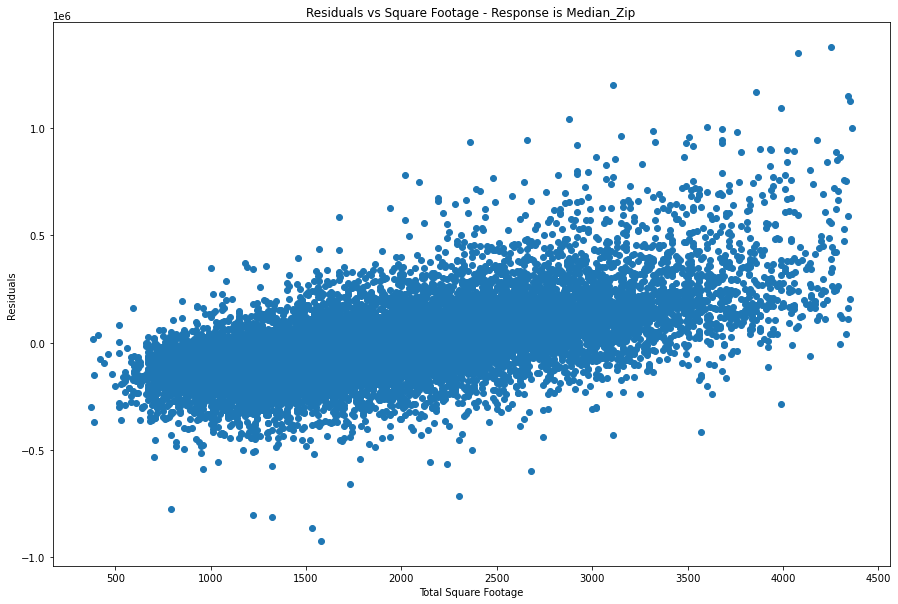

In [88]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['sqft_living']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Total Square Footage')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Square Footage - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

We can see a clear pattern in our residuals, which tells us that adding square footage will add to our model. Now we know this already from our correlation map, but this visual reinforces that information.

We'll do the same regression on zip code again, this time residuals plotted against grade. Again a relationship can be seen.

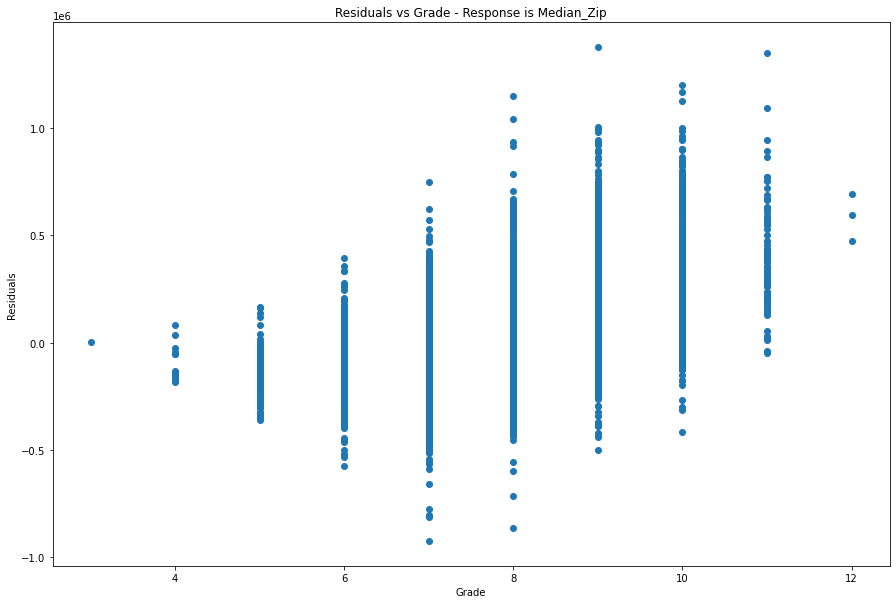

In [89]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['grade']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Grade')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Grade - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

We can see from this graph that Grade has relevance to our model, because the data show a clear pattern. 

Contrast this with yr_built, our lowest correlated feature before we encoded it.

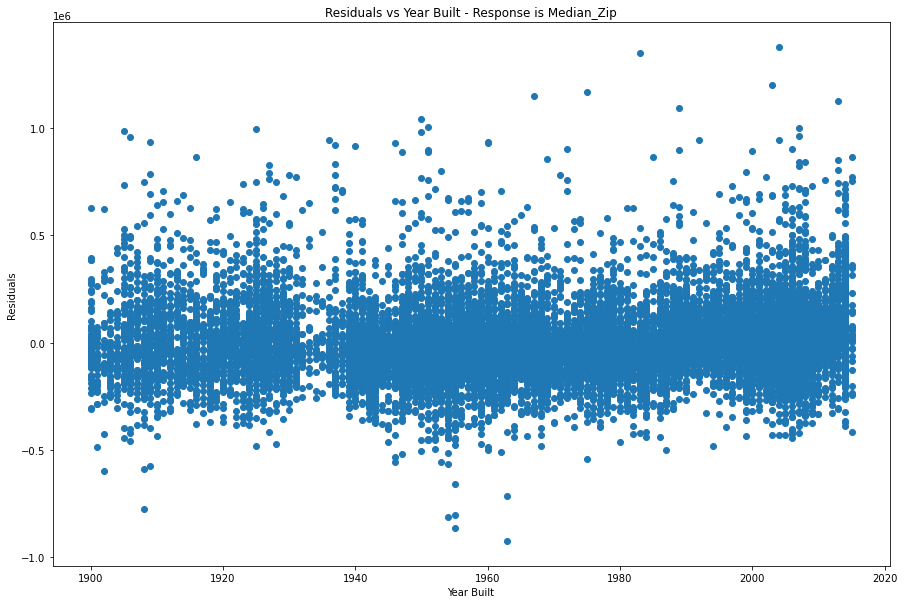

In [90]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['yr_built']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Year Built')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Year Built - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

Our scatter looks like a normal residuals plot, implying that the year built does not add much to our model. There's no strong trend exhibited here. If we can see a pattern when we plot residuals vs a different predictor, it can tell us if a feature might add value to our model.

## Linear Regressions

### Basic Model Top Features Only

We're going to build our most baseline model using only the top three features -
    
    * Zip code
    * Grade
    * sqft_living
    * bathrooms

#### One-Hot Encoded Zip Code

In this model we will one-hot encode our 70 zip codes.

In [91]:
# put together our basic feature set and preprocess

# one-hot encode categorical
base_cat = pd.DataFrame()
base_cat['zipcode'] = df['zipcode']
base_cat['zipcode'] = base_cat['zipcode'].astype('category')
base_cat_processed = pd.get_dummies(base_cat['zipcode'], prefix='zipcode', drop_first=True)
base_cat_processed.reset_index(inplace=True)
base_cat_processed.drop('index', axis=1, inplace=True)

# log transform and standard scale our continuous
base_cont = df[['sqft_living', 'grade', 'bathrooms']]

scaler = StandardScaler()
base_cont_processed = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)

# our log-transformed target variable
y = np.log(df['price'])

#join cat and cont into predictor data frame
#x_base_set = pd.concat([base_cont_processed, base_cat_processed], axis=1)
x_base_set = base_cont_processed.join([base_cat_processed], how='inner') 

# train/test split
x_base_train, x_base_test, y_base_train, y_base_test = train_test_split(x_base_set, y, test_size=0.2, random_state=randomstate)

In [92]:
# run model for R^2 score

model = LinearRegression()
model.fit(x_base_train, y_base_train)
cv_5 = cross_val_score(model, x_base_train, y_base_train, cv=5)
r2 = cv_5.mean()
r2

0.8563261964174025

Our R-squared of 85.6% indicates that 85.6% of the variance in price can be explained by our features. 

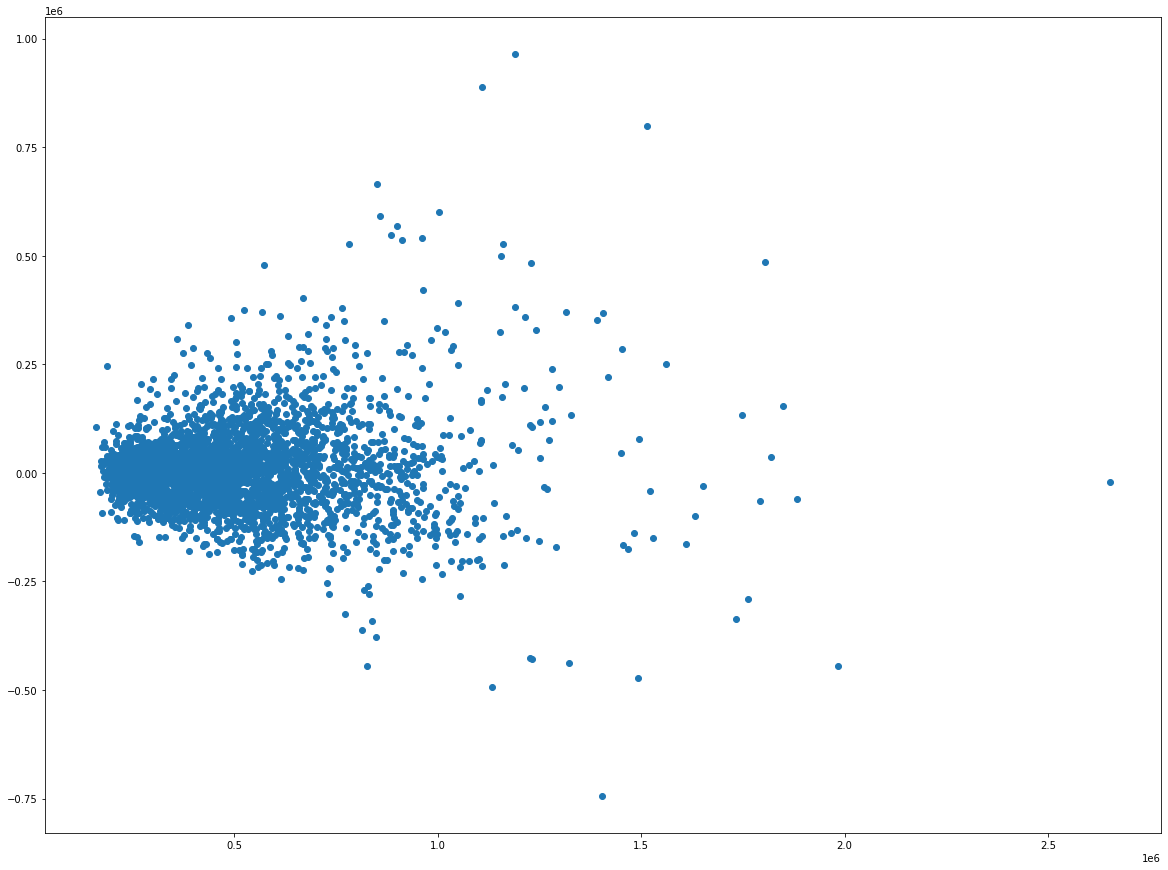

In [93]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(x_base_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions).astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);
# Residuals plot

In [94]:
# Calculate our mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists
models['Models'].append('Bare Bones Features LR - One-Hot Zip')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 65748.47


Our baseline model has an R^2 of 85.6% which isn't awful, on only a few features. Our MAE is pretty high. We will see if we can improve on that with some other feature selection methods, and even some other model types. But FIRST we will try the same model but using our target encoded zipcode instead.

#### Target Encoded Zip Code

In this model we will use our target encoded  zip codes using zip_smooth.

In [95]:
# put together our basic feature set and preprocess

x_base_train = X_train_encoded[['sqft_living', 'grade', 'bathrooms', 'zip_smooth']]
x_base_test = X_test_encoded[['sqft_living', 'grade', 'bathrooms', 'zip_smooth']]

In [96]:
# run model for R^2 score

model = LinearRegression()
model.fit(x_base_train, y_base_train)
cv_5 = cross_val_score(model, x_base_train, y_base_train, cv=5)
r2 = cv_5.mean()
r2

0.8003850370773055

Our R-squared of 78.3% is much lower than when we used our zip code as categoricals. 

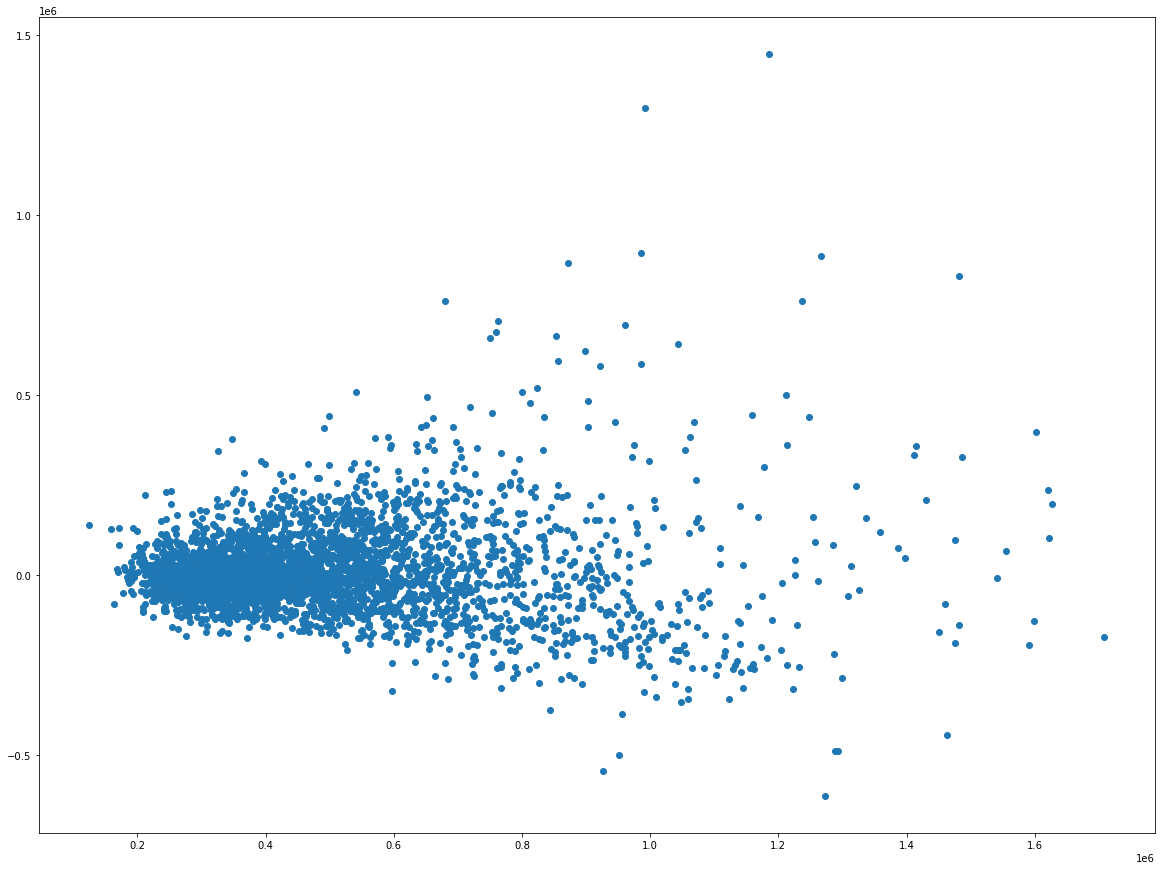

In [97]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(x_base_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions).astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);
# Residuals plot

In [98]:
# Calculate our mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists
models['Models'].append('Bare Bones Features LR - Encoded Zip')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 82792.53


### Linear Regression Model - ALL Features

#### One-hot set

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're going to use our one-hot encoded set which performed better in our first test.

In [99]:
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     643.5
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        09:43:31   Log-Likelihood:                 6426.8
No. Observations:               14052   AIC:                        -1.249e+04
Df Residuals:                   13872   BIC:                        -1.113e+04
Df Model:                         179                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.6962      0.016    772.697      0.000      12.664      12.728
sqft_living         -0.2433      0.013    -19.292      0.000      -0.268      -0.219
sqft_living15        0.0376      0.003     11.050      0.000       0.031       0.044
sqft_lot             0.0473      0.003     18.582      0.000       0.042       0.052
sqft_basement       -0.0162      0.002     -8.531      0.000      -0.020      -0.012
view                 0.0259      0.001     17.876      0.000       0.023       0.029
bedrooms            -0.0012      0.002     -0.629      0.530      -0.005       0.003
bathrooms            0.0188      0.002      7.663      0.000       0.014       0.024
grade                0.0807      0.002     34.417      0.000       0.076       0.085
condition            0.0351      0.002     22.845      0.000       0.032       0.038
sqft-zip             0.4730      0.014     33.757      0.000       0.446       0.500
grade1               0.0056      0.001      5.771      0.000       0.004       0.007
sqft_living2         0.0053      0.001      3.794      0.000       0.003       0.008
sqft_living3        -0.0020      0.001     -2.754      0.006      -0.003      -0.001
floors_1.5           0.0035      0.006      0.614      0.539      -0.008       0.015
floors_2.0          -0.0170      0.005     -3.317      0.001      -0.027      -0.007
floors_2.5          -0.0294      0.018     -1.659      0.097      -0.064       0.005
floors_3.0          -0.0782      0.011     -7.126      0.000      -0.100      -0.057
floors_3.5          -0.0929      0.078     -1.192      0.233      -0.246       0.060
waterfront_1         0.3826      0.040      9.522      0.000       0.304       0.461
renovated_1          0.0706      0.008      9.406      0.000       0.056       0.085
comparative_sf_2     0.0035      0.006      0.562      0.574      -0.009       0.016
comparative_sf_3     0.0010      0.010      0.097      0.923      -0.019       0.020
zipcode_98002       -0.0380      0.017     -2.262      0.024      -0.071      -0.005
zipcode_98003        0.0210      0.015      1.399      0.162      -0.008       0.050
zipcode_98004        0.2022      0.016     13.035      0.000       0.172       0.233
zipcode_98005        0.2346      0.016     14.401      0.000       0.203       0.267
zipcode_98006        0.0160      0.010      1.540      0.124      -0.004       0.036
zipcode_98007        0.1812      0.016     11.030      0.000       0.149       0.213
zipcode_98008        0.1613      0.012     12.957      0.000       0.137       0.186
zipcode_98010       -0.0934      0.027     -3.445      0.001      -0.147      -0.040
zipcode_98011        0.1501      0.014     10.761      0.000       0.123       0.177
zipcode_98014       -0.0046      0.030     -0.152      0.879      -0.064       0.055
zipcode_98019        0.

There are a good number of features included in this model with a p-value over .05, meaning there is a greater than 5% chance that the results are due to randomness of the sample rather than the feature. A lot of our features have a very low p-value which indicates a very low chance that these results are not affected by the feature. 

Now we perform cross-validation with our base model over 5 splits and get our mean R^2.

In [100]:
model = LinearRegression()
model.fit(X_train_onehot, y_train)
cv_5 = cross_val_score(model, X_train_onehot, y_train, cv=5)
r2 = cv_5.mean()
r2

0.8887119852745933

Using all of our predictors we get an R^2 of 88.4% which is decent. This indicates that 88.4% of the variance in price can be explained by our features. 

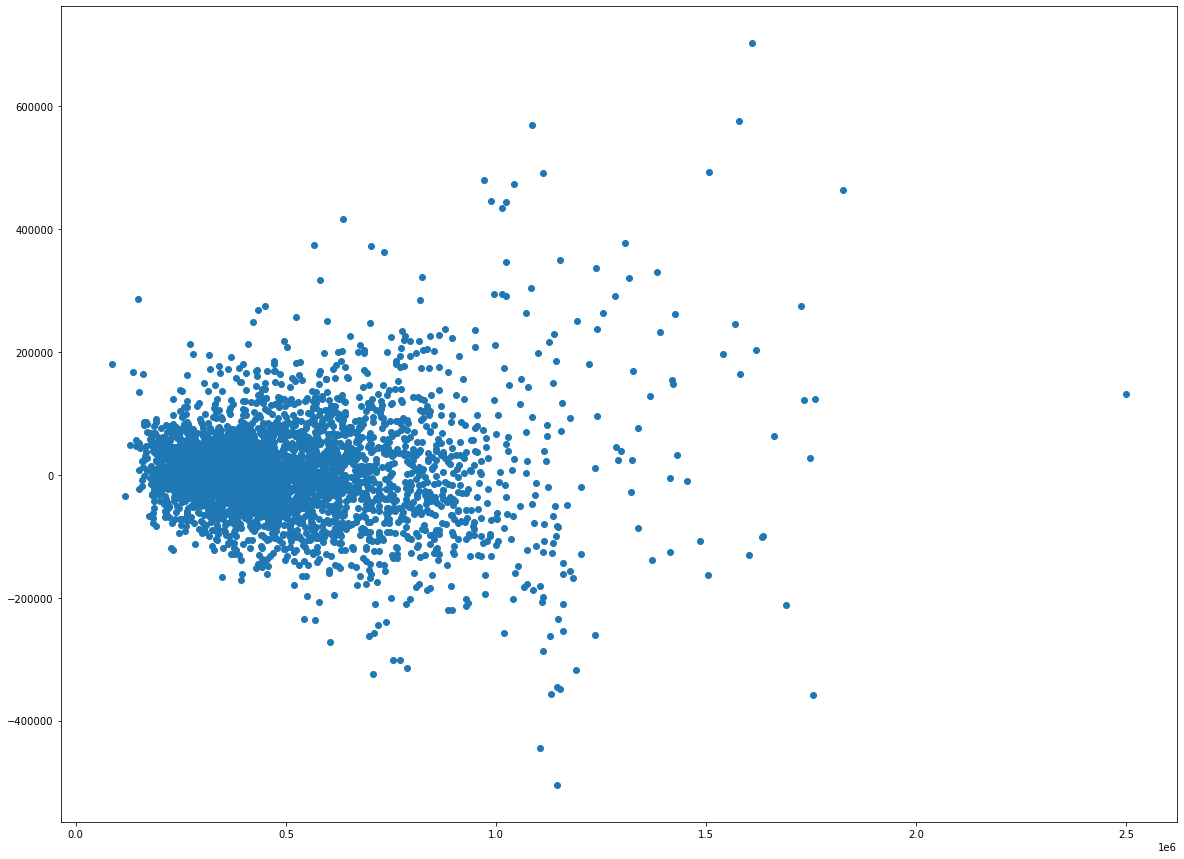

In [101]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test_onehot)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot


In [102]:
# Calculate our mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists
models['Models'].append('Basic LR - One-Hot')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 56286.25


##### Study Residuals

In [103]:
# We need our statsmodels model again to plot residuals
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()

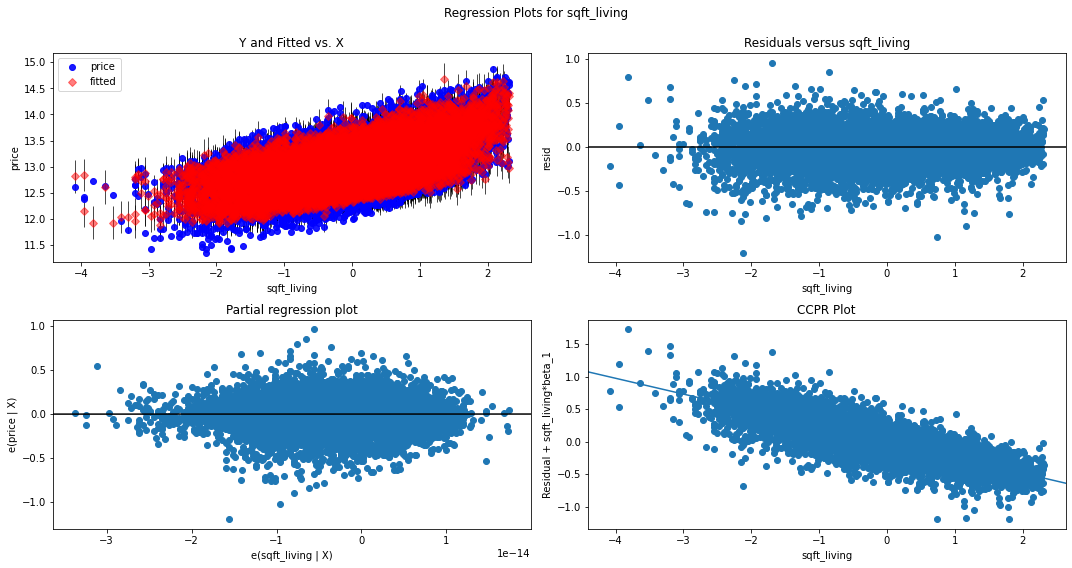

In [104]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

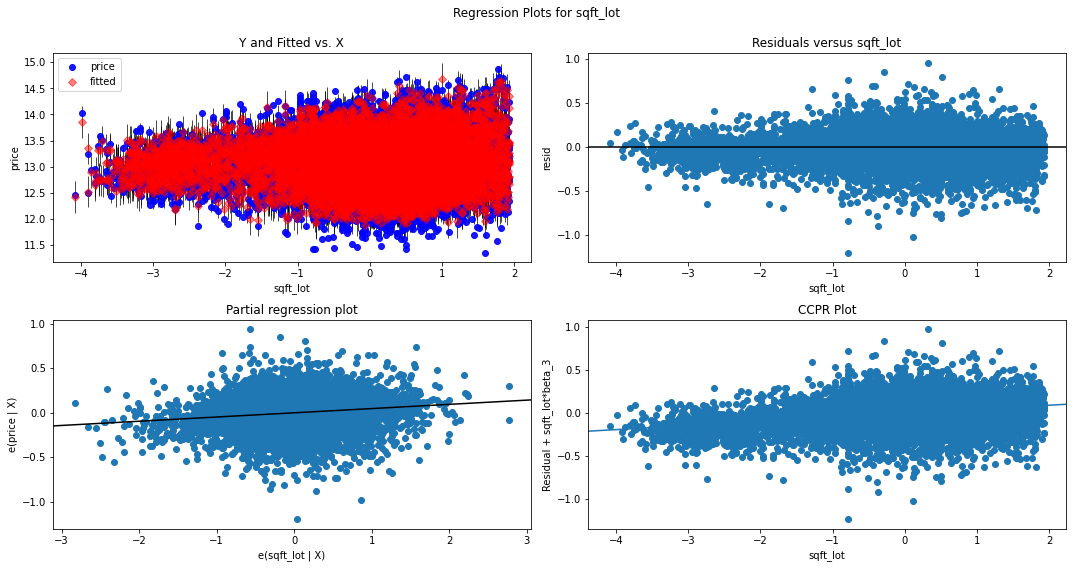

In [105]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_lot", fig=fig)
plt.show()

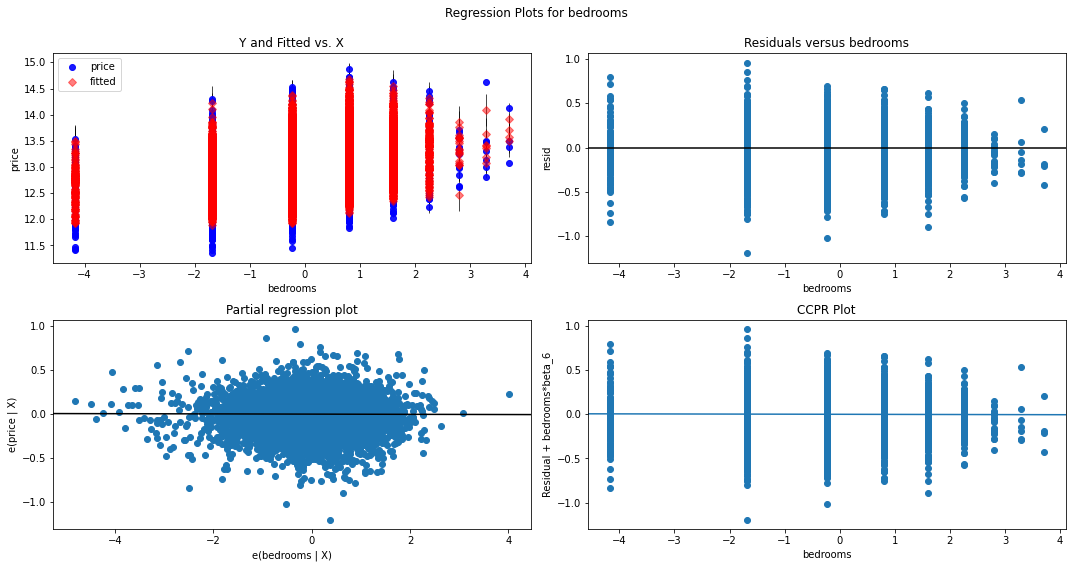

In [106]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bedrooms", fig=fig)
plt.show()

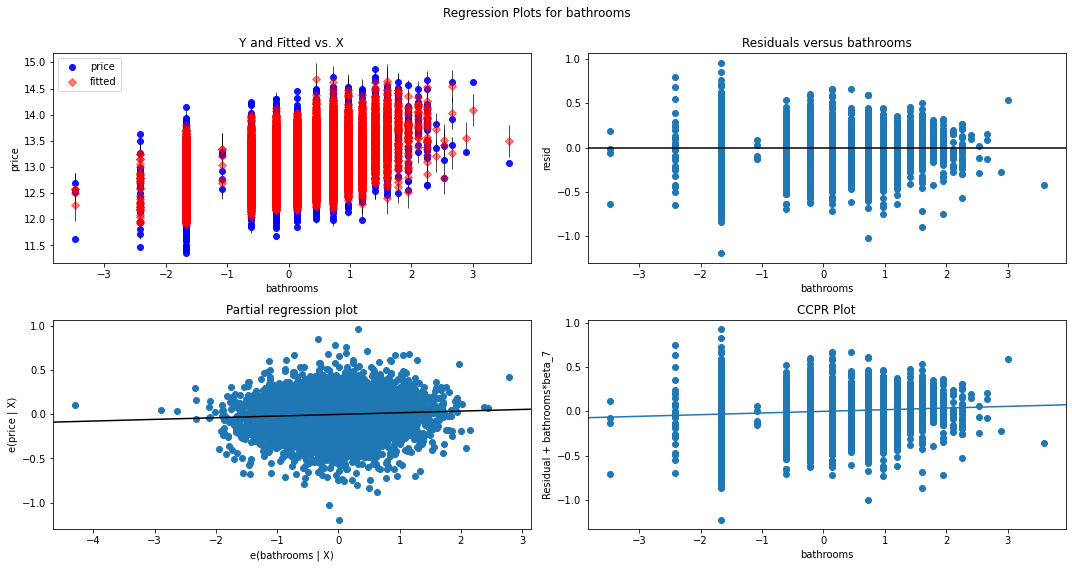

In [107]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

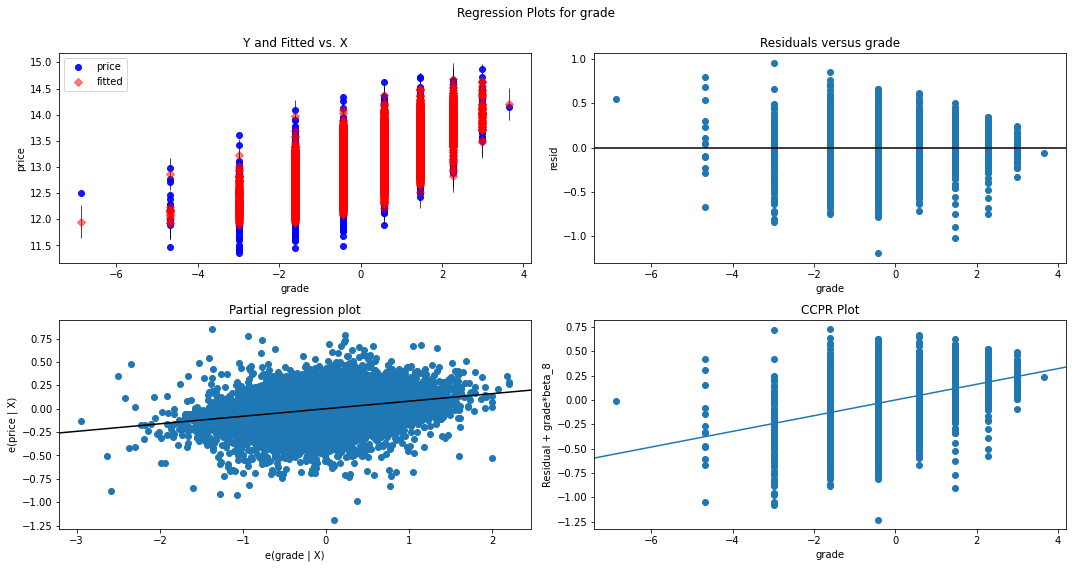

In [108]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

#### Target Encoded Set

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're using our target categorical encoded set which performed worse in our first test.

In [109]:
predictors_train = sm.add_constant(X_train_encoded)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     2639.
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        09:43:38   Log-Likelihood:                 3438.5
No. Observations:               14052   AIC:                            -6821.
Df Residuals:                   14024   BIC:                            -6610.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.0311      0.008   1574.189      0.000      13.015      13.047
sqft_living          0.0586      0.004     15.223      0.000       0.051       0.066
sqft_living15        0.0205      0.004      5.023      0.000       0.012       0.028
sqft_lot            -0.0032      0.003     -1.265      0.206      -0.008       0.002
sqft_basement        0.0046      0.002      2.111      0.035       0.000       0.009
view                 0.0335      0.002     19.758      0.000       0.030       0.037
bedrooms            -0.0041      0.002     -1.818      0.069      -0.009       0.000
bathrooms           -0.0016      0.003     -0.573      0.566      -0.007       0.004
grade                0.0790      0.003     29.990      0.000       0.074       0.084
condition            0.0313      0.002     18.124      0.000       0.028       0.035
zip_smooth           0.1709      0.003     62.361      0.000       0.165       0.176
year_smooth          0.0283      0.002     13.710      0.000       0.024       0.032
month_smooth         0.0149      0.002      9.300      0.000       0.012       0.018
lat_long             0.0782      0.003     28.491      0.000       0.073       0.084
sqft-zip             0.1181      0.003     42.511      0.000       0.113       0.124
month1              -0.0002      0.001     -0.130      0.896      -0.003       0.003
grade1               0.0009      0.001      0.806      0.420      -0.001       0.003
year1                0.0019      0.001      1.831      0.067      -0.000       0.004
sqft_living2         0.0090      0.002      5.311      0.000       0.006       0.012
sqft_living3        -0.0038      0.001     -4.282      0.000      -0.005      -0.002
floors_1.5           0.0666      0.006     10.343      0.000       0.054       0.079
floors_2.0          -0.0184      0.006     -3.181      0.001      -0.030      -0.007
floors_2.5           0.0077      0.021      0.357      0.721      -0.034       0.050
floors_3.0          -0.0168      0.013     -1.335      0.182      -0.042       0.008
floors_3.5          -0.0241      0.095     -0.252      0.801      -0.211       0.163
waterfront_1         0.2458      0.047      5.257      0.000       0.154       0.337
renovated_1          0.0989      0.009     11.516      0.000       0.082       0.116
comparative_sf_2    -0.0276      0.008     -3.625      0.000      -0.042      -0.013
comparative_sf_3    -0.0030      0.012     -0.245      0.807      -0.027       0.021
==============================================================================
Omnibus:                      335.650   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.386
Skew:                          -0.138   Prob(JB):                    3.30e-150
Kurtosis:                       4.049   Cond. N

There are a good number of features included in this model with a p-value over .05, meaning there is a greater than 5% chance that the results are due to randomness of the sample rather than the feature. A lot of our features have a very low p-value which indicates a very low chance that these results are not affected by the feature. 

Now we perform cross-validation with our base model over 5 splits and get our mean R^2.

In [110]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)
cv_5 = cross_val_score(model, X_train_encoded, y_train, cv=5)
r2 = cv_5.mean()
r2

0.8346748053927946

Using all of our predictors we get an R^2 of 82.3% which is less than when we use our zip code and month as categoricals. So in our linear models, we will use our one-hot encoded data set.

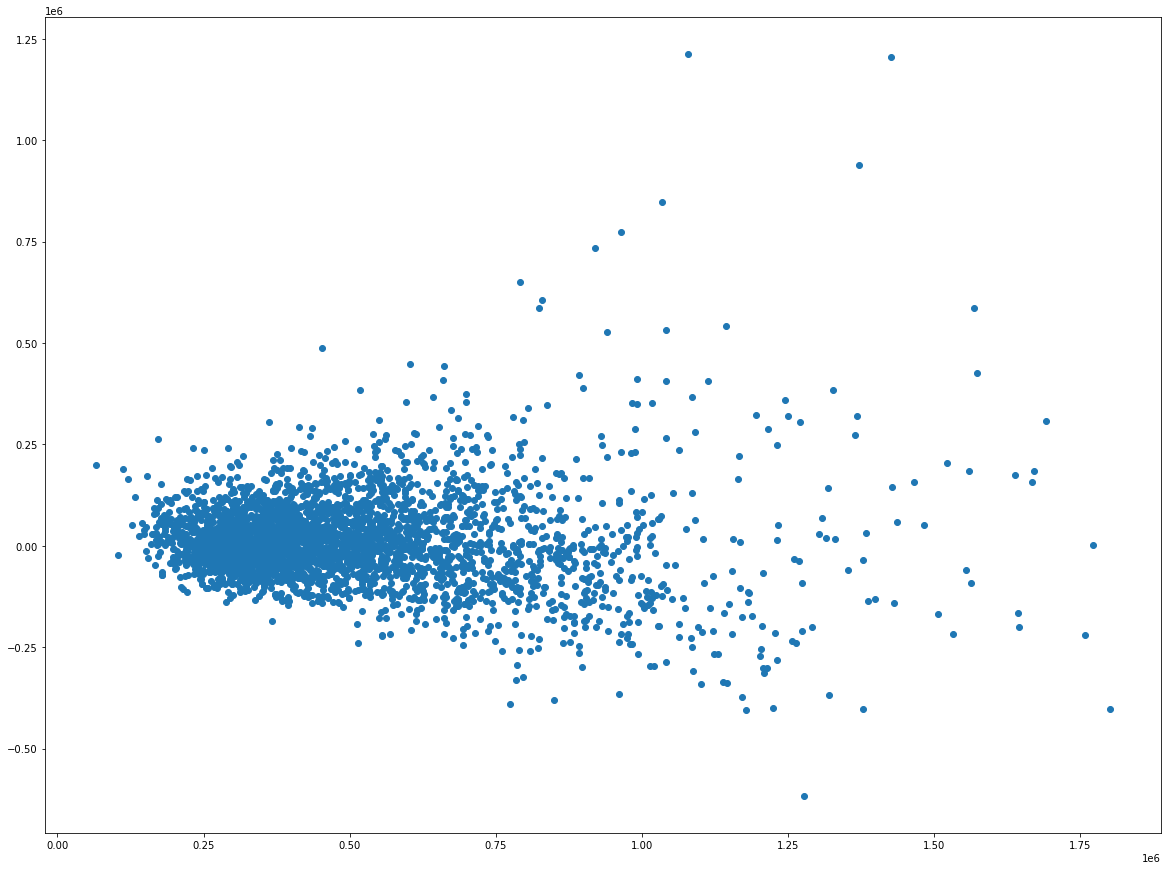

In [111]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test_encoded)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot


In [112]:
# Calculate our mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

# append our results to our lists
models['Models'].append('Basic LR - Encoded')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 74030.89


### Linear Regression - Feature Selectors

Feature selectors are different methods to help us pick which features we want to use in our model. In our example above where we used ALL predictors in our linear regression, several of our features had a p-value over .05, which indicates that there is more than a 5% chance that the changes attributed to that feature were actually by random chance. We want features where our p-value is below a threshold that we specify where we are reasonably confident that the feature is contributing to the model and not by random chance.

We're going to use our one-hot encoded set for this because it performs better than our target encoding set.

#### Forward-Backward Selector

First we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model. This selector starts with zero features, internally runs the model for each feature individually, and adds the lowest p-value feature to its list to include. It then runs the model again with the original feature included and tries adding each other feature individually. It will either add the next best feature under the threshold or remove an existing feature if it is no longer within the threshold. This process iterates until all features in the model are under the p-value threshold.

This selector was written by David Dale: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

In [113]:
'''def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


result = stepwise_selection(X_train_onehot, y_train, verbose=True)

print('resulting features:', result)
'''

result = ['sqft_living15', 'grade', 'sqft-zip', 'sqft_living2', 'view', 'zipcode_98117', 'zipcode_98103', 'zipcode_98115', 'zipcode_98107', 'zipcode_98075', 'condition', 'zipcode_98002', 'zipcode_98032', 'zipcode_98092', 'zipcode_98023', 'zipcode_98022', 'zipcode_98039', 'zipcode_98038', 'zipcode_98109', 'zipcode_98119', 'zipcode_98122', 'zipcode_98102', 'zipcode_98116', 'zipcode_98105', 'zipcode_98136', 'renovated_1', 'zipcode_98125', 'zipcode_98126', 'zipcode_98199', 'zipcode_98034', 'zipcode_98144', 'zipcode_98008', 'zipcode_98033', 'zipcode_98053', 'zipcode_98133', 'zipcode_98118', 'zipcode_98112', 'sqft_basement', 'zipcode_98005', 'zipcode_98004', 'zipcode_98007', 'zipcode_98052', 'zipcode_98177', 'zipcode_98029', 'zipcode_98027', 'zipcode_98155', 'floors_3.0', 'zipcode_98040', 'zipcode_98006', 'zipcode_98074', 'zipcode_98072', 'zipcode_98011', 'zipcode_98028', 'sqft_living', 'year_block_30', 'waterfront_1', 'zipcode_98065', 'zipcode_98077', 'zipcode_98106', 'zipcode_98108', 'zipcode_98056', 'zipcode_98059', 'zipcode_98045', 'zipcode_98166', 'zipcode_98019', 'zipcode_98146', 'zipcode_98014', 'zipcode_98024', 'month_sold_6', 'month_sold_5', 'year_block_29', 'sqft_lot', 'bathrooms', 'month_sold_4', 'year_block_3', 'year_block_5', 'zipcode_98058', 'zipcode_98178', 'zipcode_98055', 'zipcode_98070', 'year_block_4', 'floors_2.0', 'loc_block_46', 'month_sold_7', 'month_sold_3', 'year_block_18', 'year_block_13', 'loc_block_47', 'month_sold_8', 'loc_block_37', 'loc_block_33', 'zipcode_98148', 'floors_2.5', 'year_block_11', 'loc_block_31', 'loc_block_36', 'loc_block_34', 'loc_block_2', 'loc_block_40', 'loc_block_45', 'loc_block_50', 'loc_block_49', 'loc_block_41', 'loc_block_48', 'loc_block_38', 'loc_block_44', 'loc_block_39', 'loc_block_42', 'loc_block_35', 'loc_block_43', 'loc_block_29', 'loc_block_28', 'loc_block_30', 'loc_block_27', 'loc_block_32', 'loc_block_25', 'year_block_15', 'loc_block_26', 'year_block_12', 'year_block_14', 'year_block_16', 'year_block_17', 'year_block_10', 'loc_block_10', 'year_block_9', 'zipcode_98198', 'year_block_27', 'loc_block_3', 'month_sold_9', 'grade1', 'zipcode_98168']

In [114]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train_onehot[result]
X_test_refined = X_test_onehot[result]

predictors_int = sm.add_constant(X_train_refined)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     868.1
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        09:43:38   Log-Likelihood:                 6325.6
No. Observations:               14052   AIC:                        -1.239e+04
Df Residuals:                   13920   BIC:                        -1.139e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6073      0.019    652.225      0.000      12.569      12.645
sqft_living15     0.0403      0.002     18.067      0.000       0.036       0.045
grade             0.0810      0.002     36.859      0.000       0.077       0.085
sqft-zip          0.1203      0.038      3.156      0.002       0.046       0.195
sqft_living2      0.0074      0.001      6.014      0.000       0.005       0.010
view              0.0250      0.001     17.317      0.000       0.022       0.028
zipcode_98117     0.5779      0.031     18.877      0.000       0.518       0.638
zipcode_98103     0.6295      0.031     20.026      0.000       0.568       0.691
zipcode_98115     0.5793      0.033     17.744      0.000       0.515       0.643
zipcode_98107     0.5963      0.029     20.386      0.000       0.539       0.654
zipcode_98075     0.2727      0.042      6.506      0.000       0.191       0.355
condition         0.0341      0.001     23.235      0.000       0.031       0.037
zipcode_98002    -0.0592      0.013     -4.413      0.000      -0.086      -0.033
zipcode_98032    -0.0600      0.019     -3.197      0.001      -0.097      -0.023
zipcode_98092    -0.0610      0.012     -4.937      0.000      -0.085      -0.037
zipcode_98023    -0.0258      0.012     -2.147      0.032      -0.049      -0.002
zipcode_98022    -0.0594      0.017     -3.536      0.000      -0.092      -0.026
zipcode_98039     0.9482      0.052     18.402      0.000       0.847       1.049
zipcode_98038     0.0961      0.009     10.154      0.000       0.078       0.115
zipcode_98109     0.7212      0.040     17.947      0.000       0.642       0.800
zipcode_98119     0.6906      0.040     17.133      0.000       0.612       0.770
zipcode_98122     0.5811      0.031     19.004      0.000       0.521       0.641
zipcode_98102     0.6967      0.038     18.222      0.000       0.622       0.772
zipcode_98116     0.4908      0.032     15.522      0.000       0.429       0.553
zipcode_98105     0.6662      0.043     15.553      0.000       0.582       0.750
zipcode_98136     0.5117      0.027     18.664      0.000       0.458       0.565
renovated_1       0.0664      0.007      9.306      0.000       0.052       0.080
zipcode_98125     0.4689      0.018     25.790      0.000       0.433       0.505
zipcode_98126     0.4155      0.017     24.533      0.000       0.382       0.449
zipcode_98199     0.5373      0.042     12.766      0.000       0.455       0.620
zipcode_98034     0.4118      0.018     22.544      0.000       0.376       0.448
zipcode_98144     0.4272      0.027     16.016      0.000       0.375       0.480
zipcode_98008     0.3851      0.029     13.341      0.000       0.328       0.442
zipcode_98033     0.5210      0.040     13.183      0.000       0.444       0.598
zipcode_98053     0.4200      0.030     13.817   

Same score, but no features above our threshold.

In [115]:
print("{} predictors used".format(len(result)))

131 predictors used


In [116]:
model = LinearRegression()
model.fit(X_train_refined, y_train)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train, cv=cv)
r2 = cv_5.mean()
r2

0.8881368983215164

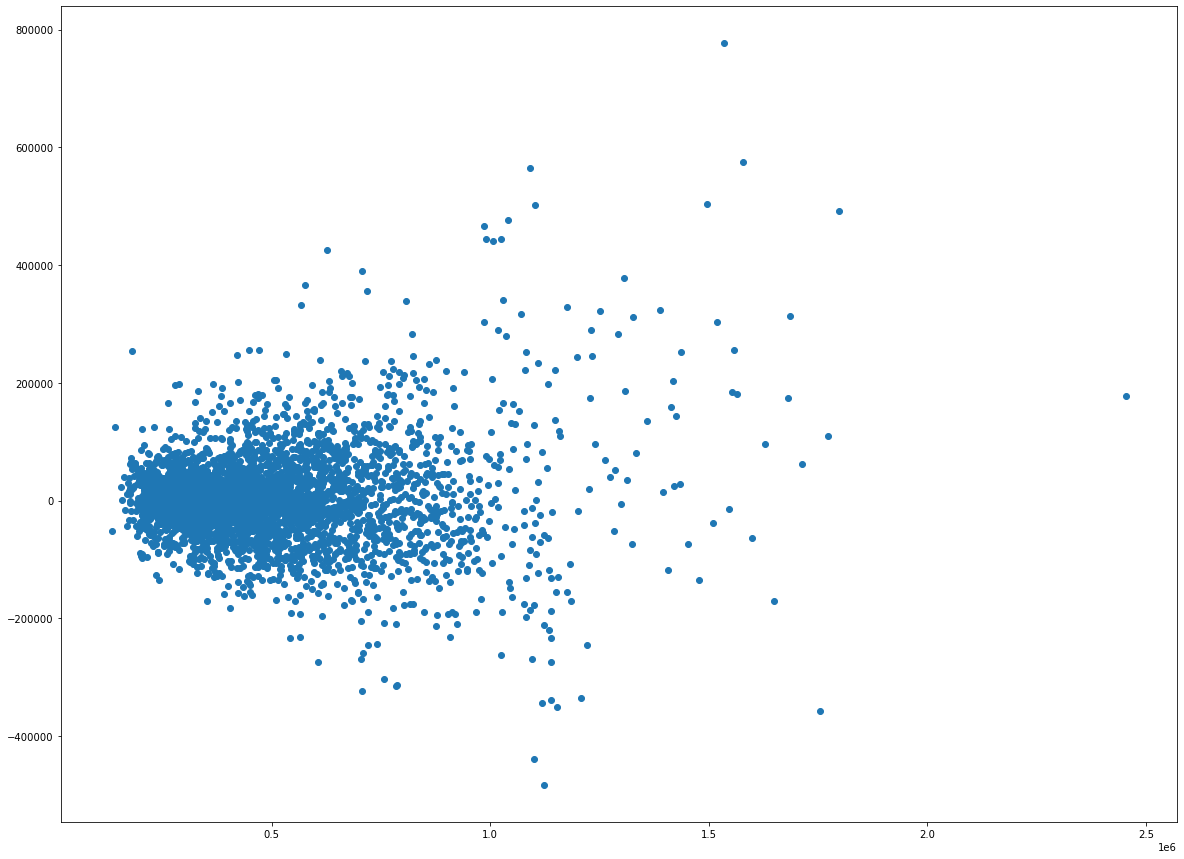

In [117]:
# apply our model to our test set and get predicted values
test_predictions_refined = model.predict(X_test_refined)

# reverse log transform our predicted values
test_predictions_refined_unscaled = np.exp(test_predictions_refined)
test_predictions_refined_unscaled=test_predictions_refined_unscaled.flatten()

# get residuals
residuals = test_actual - test_predictions_refined_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_refined_unscaled, residuals)

In [118]:
# get mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_refined_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_refined_unscaled)), 2)

# append our results to our lists
models['Models'].append('Forw-Back Selector')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 55719.79


#### Permutation Importance

Next we're going to select features using a method called permutation importance. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/
The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [119]:
'''model = LinearRegression()
model.fit(X_train_onehot, y_train)


r = permutation_importance(model, X_train_onehot, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[X_train_onehot.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features = list(importances.keys())
important_features  '''

'model = LinearRegression()\nmodel.fit(X_train_onehot, y_train)\n\n\nr = permutation_importance(model, X_train_onehot, y_train,\n                           n_repeats=15,\n                            random_state=0,\n                          n_jobs=-1)\n\nimportances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        importances[X_train_onehot.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportances\n\nimportant_features = list(importances.keys())\nimportant_features  '

In [120]:
important_features = ['sqft_living','zipcode_98103','zipcode_98115','zipcode_98117','zipcode_98004',
                      'zipcode_98112','zipcode_98033','zipcode_98199','zipcode_98105','grade','zipcode_98052',
                      'zipcode_98122','zipcode_98107','zipcode_98034','zipcode_98125','zipcode_98040','zipcode_98116',
                      'zipcode_98133','zipcode_98006','zipcode_98119','zipcode_98136','sqft-zip','zipcode_98144',
                      'zipcode_98155','zipcode_98126','zipcode_98118','zipcode_98109','zipcode_98027','zipcode_98008',
                      'zipcode_98177','zipcode_98102','zipcode_98029','zipcode_98053','zipcode_98074','zipcode_98005',
                      'zipcode_98056','zipcode_98059','sqft_living2','zipcode_98028','zipcode_98075','zipcode_98039',
                      'zipcode_98072','zipcode_98007','zipcode_98065','sqft_living15','zipcode_98011','loc_block_46',
                      'loc_block_47','loc_block_50','zipcode_98106','loc_block_49','condition','loc_block_45',
                      'loc_block_48','loc_block_41','loc_block_36','sqft_basement','zipcode_98146','zipcode_98166',
                      'loc_block_38','loc_block_44','loc_block_33','loc_block_37','loc_block_40','loc_block_42',
                      'loc_block_39','view','loc_block_31','loc_block_43','loc_block_34','zipcode_98045','zipcode_98108',
                      'loc_block_35','zipcode_98019','zipcode_98058','loc_block_29','zipcode_98038','floors_2.0',
                      'floors_3.0','zipcode_98077','loc_block_30','loc_block_32','loc_block_27','loc_block_28',
                      'zipcode_98178','bathrooms','month_sold_6','month_sold_5','zipcode_98055','sqft_lot','month_sold_4',
                      'loc_block_25','year_block_18','year_block_13','loc_block_26','month_sold_7','loc_block_22',
                      'loc_block_24','month_sold_3','loc_block_10','renovated_1','year_block_11','loc_block_18',
                      'year_block_30','loc_block_23','year_block_14','waterfront_1','year_block_12','loc_block_21',
                      'year_block_16','loc_block_16','zipcode_98168','loc_block_20']

In [121]:
# set the features recommended by our feature selector

X_train_perm = X_train_onehot[important_features]
X_test_perm = X_test_onehot[important_features]

predictors_int = sm.add_constant(X_train_perm)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     973.3
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        09:43:39   Log-Likelihood:                 6108.3
No. Observations:               14052   AIC:                        -1.199e+04
Df Residuals:                   13938   BIC:                        -1.113e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6413      0.011   1109.671      0.000      12.619      12.664
sqft_living      -0.0379      0.018     -2.119      0.034      -0.073      -0.003
zipcode_98103     0.5574      0.019     29.362      0.000       0.520       0.595
zipcode_98115     0.5038      0.019     25.970      0.000       0.466       0.542
zipcode_98117     0.5131      0.019     27.365      0.000       0.476       0.550
zipcode_98004     0.5690      0.036     15.985      0.000       0.499       0.639
zipcode_98112     0.5704      0.032     17.700      0.000       0.507       0.634
zipcode_98033     0.4164      0.023     17.888      0.000       0.371       0.462
zipcode_98199     0.4364      0.026     16.771      0.000       0.385       0.487
zipcode_98105     0.5703      0.026     21.703      0.000       0.519       0.622
grade             0.0770      0.002     35.173      0.000       0.073       0.081
zipcode_98052     0.2756      0.021     13.107      0.000       0.234       0.317
zipcode_98122     0.5062      0.020     25.511      0.000       0.467       0.545
zipcode_98107     0.5310      0.020     26.730      0.000       0.492       0.570
zipcode_98034     0.3618      0.013     28.699      0.000       0.337       0.386
zipcode_98125     0.4333      0.013     33.304      0.000       0.408       0.459
zipcode_98040     0.4264      0.033     12.958      0.000       0.362       0.491
zipcode_98116     0.4189      0.020     20.691      0.000       0.379       0.459
zipcode_98133     0.3958      0.010     39.913      0.000       0.376       0.415
zipcode_98006     0.2719      0.025     10.664      0.000       0.222       0.322
zipcode_98119     0.5987      0.026     22.745      0.000       0.547       0.650
zipcode_98136     0.4469      0.018     24.252      0.000       0.411       0.483
sqft-zip          0.2227      0.021     10.427      0.000       0.181       0.265
zipcode_98144     0.3679      0.018     20.527      0.000       0.333       0.403
zipcode_98155     0.3409      0.011     31.841      0.000       0.320       0.362
zipcode_98126     0.3932      0.014     29.119      0.000       0.367       0.420
zipcode_98118     0.3175      0.011     29.693      0.000       0.297       0.338
zipcode_98109     0.6370      0.028     23.161      0.000       0.583       0.691
zipcode_98027     0.3733      0.020     18.717      0.000       0.334       0.412
zipcode_98008     0.3058      0.019     15.684      0.000       0.268       0.344
zipcode_98177     0.4024      0.019     21.487      0.000       0.366       0.439
zipcode_98102     0.6160      0.027     22.914      0.000       0.563       0.669
zipcode_98029     0.2867      0.020     14.277      0.000       0.247       0.326
zipcode_98053     0.3479      0.020     17.479      0.000       0.309       0.387
zipcode_98074     0.1632      0.023      7.211   

In [122]:
print("{} predictors used".format(len(important_features)))

113 predictors used


In [123]:
model = LinearRegression()
model.fit(X_train_perm, y_train)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_perm, y_train, cv=cv)
r2 = cv_5.mean()
r2

0.8851875898930123

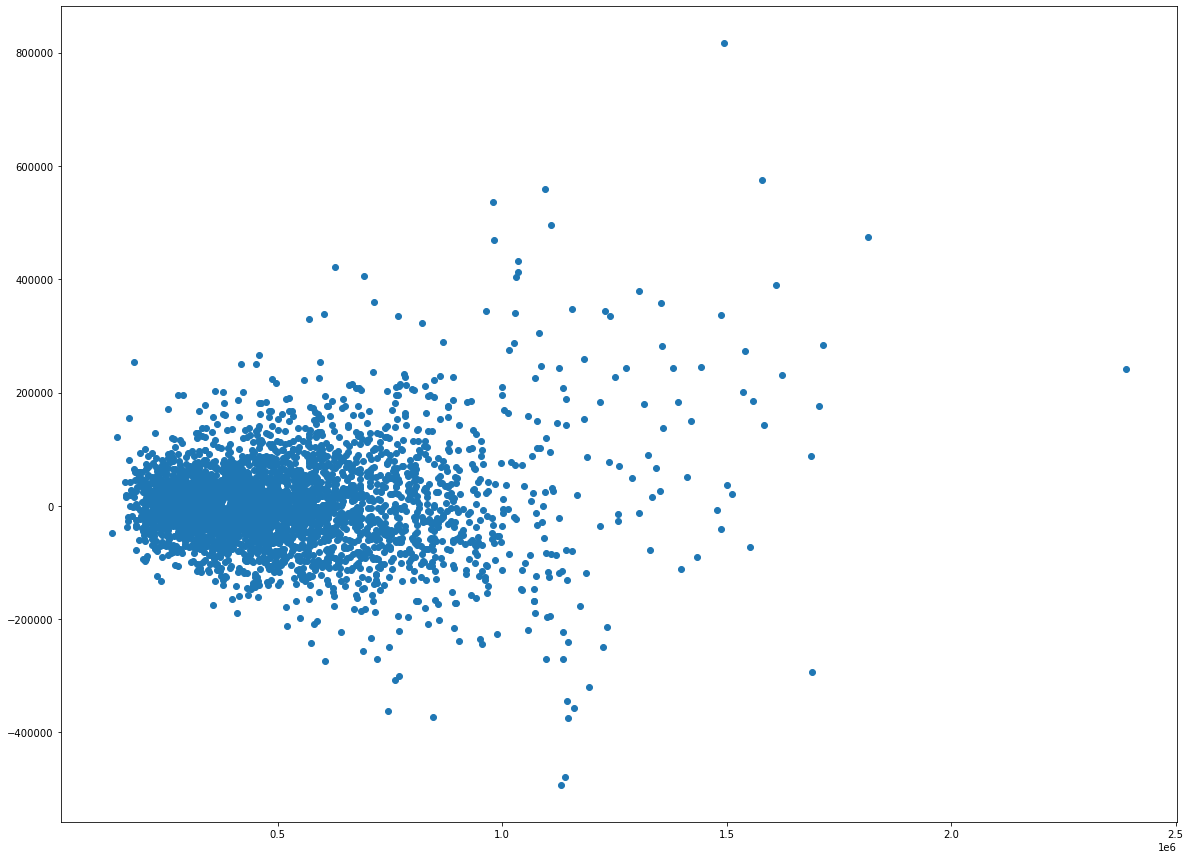

In [124]:
# apply our model to our test set and get predicted values
test_predictions_refined = model.predict(X_test_perm)

# reverse log transform our predicted values
test_predictions_refined_unscaled = np.exp(test_predictions_refined)
test_predictions_refined_unscaled=test_predictions_refined_unscaled.flatten()

# get residuals
residuals = test_actual - test_predictions_refined_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_refined_unscaled, residuals)

In [125]:
# get mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_refined_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_refined_unscaled)), 2)

# append our results to our lists
models['Models'].append('Permutation Importance Selector')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 56601.07


#### Recursive Feature Elimination with Cross Validation - Linear Regression

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [126]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression()
#cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_absolute_error')

# fit model to train set
rfecv.fit(X_train_onehot, y_train)

# print optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 180


In [127]:
dset = pd.DataFrame()
dset['attr'] = X_train_onehot.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

# Show the features that RFECV did not use
dset[dset['used']==False]

Empty DataFrame
Columns: [attr, used]
Index: []

In [128]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train_onehot[rfecv_result]
X_test_rfecv = X_test_onehot[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     643.5
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        09:43:53   Log-Likelihood:                 6426.8
No. Observations:               14052   AIC:                        -1.249e+04
Df Residuals:                   13872   BIC:                        -1.113e+04
Df Model:                         179                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.6962      0.016    772.697      0.000      12.664      12.728
sqft_living         -0.2433      0.013    -19.292      0.000      -0.268      -0.219
sqft_living15        0.0376      0.003     11.050      0.000       0.031       0.044
sqft_lot             0.0473      0.003     18.582      0.000       0.042       0.052
sqft_basement       -0.0162      0.002     -8.531      0.000      -0.020      -0.012
view                 0.0259      0.001     17.876      0.000       0.023       0.029
bedrooms            -0.0012      0.002     -0.629      0.530      -0.005       0.003
bathrooms            0.0188      0.002      7.663      0.000       0.014       0.024
grade                0.0807      0.002     34.417      0.000       0.076       0.085
condition            0.0351      0.002     22.845      0.000       0.032       0.038
sqft-zip             0.4730      0.014     33.757      0.000       0.446       0.500
grade1               0.0056      0.001      5.771      0.000       0.004       0.007
sqft_living2         0.0053      0.001      3.794      0.000       0.003       0.008
sqft_living3        -0.0020      0.001     -2.754      0.006      -0.003      -0.001
floors_1.5           0.0035      0.006      0.614      0.539      -0.008       0.015
floors_2.0          -0.0170      0.005     -3.317      0.001      -0.027      -0.007
floors_2.5          -0.0294      0.018     -1.659      0.097      -0.064       0.005
floors_3.0          -0.0782      0.011     -7.126      0.000      -0.100      -0.057
floors_3.5          -0.0929      0.078     -1.192      0.233      -0.246       0.060
waterfront_1         0.3826      0.040      9.522      0.000       0.304       0.461
renovated_1          0.0706      0.008      9.406      0.000       0.056       0.085
comparative_sf_2     0.0035      0.006      0.562      0.574      -0.009       0.016
comparative_sf_3     0.0010      0.010      0.097      0.923      -0.019       0.020
zipcode_98002       -0.0380      0.017     -2.262      0.024      -0.071      -0.005
zipcode_98003        0.0210      0.015      1.399      0.162      -0.008       0.050
zipcode_98004        0.2022      0.016     13.035      0.000       0.172       0.233
zipcode_98005        0.2346      0.016     14.401      0.000       0.203       0.267
zipcode_98006        0.0160      0.010      1.540      0.124      -0.004       0.036
zipcode_98007        0.1812      0.016     11.030      0.000       0.149       0.213
zipcode_98008        0.1613      0.012     12.957      0.000       0.137       0.186
zipcode_98010       -0.0934      0.027     -3.445      0.001      -0.147      -0.040
zipcode_98011        0.1501      0.014     10.761      0.000       0.123       0.177
zipcode_98014       -0.0046      0.030     -0.152      0.879      -0.064       0.055
zipcode_98019        0.

In [129]:
# getting the r2 score of our best feature set
r2 = model.rsquared
r2

0.8925080926168996

RFECV opted to include all the features, which I find interesting.


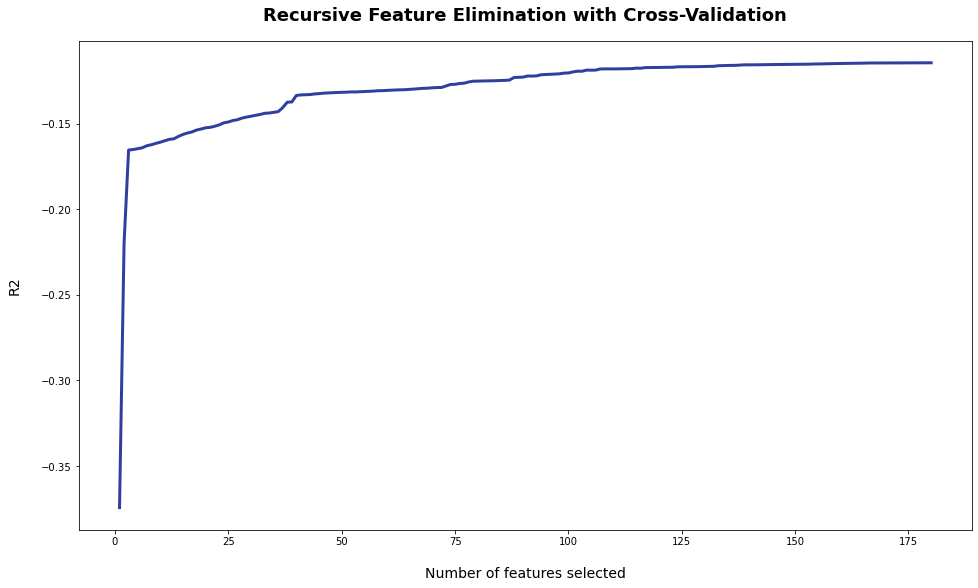

In [130]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

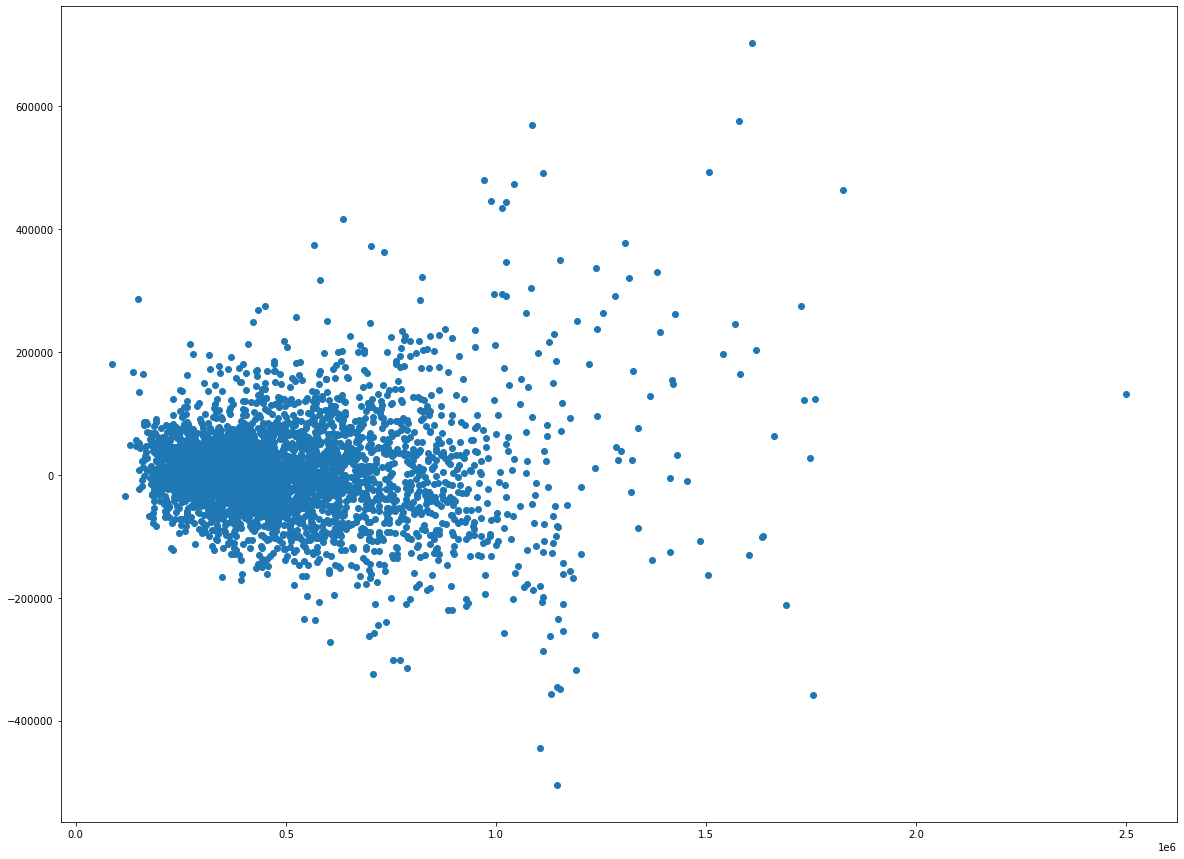

In [131]:
# predict on new data
rfecv_predictions = rfecv.predict(X_test_onehot)

rfecv_predictions_unscaled = np.exp(rfecv_predictions)
rfecv_predictions_unscaled = rfecv_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - rfecv_predictions_unscaled

#plot residuals 
fig = plt.figure(figsize=(20,15))
plt.scatter(rfecv_predictions_unscaled, residuals);

In [132]:
# get mean absolute error
mae = round(mean_absolute_error(test_actual, rfecv_predictions_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, rfecv_predictions_unscaled)), 2)

models['Models'].append('RFECV')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 56286.25


## K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

We're using our target encoded data set on this.

In [133]:
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 25
for K in range(4, 20):
    K = K+1
    
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_encoded, y_train)  #fit the model
    pred=model.predict(X_test_encoded) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate mae
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)
    
# gets optimal k-value based on score minimum
index_min = np.argmin(mae_val) + 1

# makes model and fits using optimal k
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
model.fit(X_train_encoded, y_train)  #fit the model

# Get R^2 with cv
scores = cross_val_score(model, X_train_encoded, y_train, scoring='r2', cv=5, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

MAE value for k=  5 is: 0.16605372228967338
MAE value for k=  6 is: 0.1642872413647077
MAE value for k=  7 is: 0.1628376261842613
MAE value for k=  8 is: 0.16270560093517722
MAE value for k=  9 is: 0.16150362524079823
MAE value for k=  10 is: 0.1604666756456414
MAE value for k=  11 is: 0.15967372799189564
MAE value for k=  12 is: 0.159120885848611
MAE value for k=  13 is: 0.1589257521549607
MAE value for k=  14 is: 0.15917903221524918
MAE value for k=  15 is: 0.15915267487584728
MAE value for k=  16 is: 0.1591803826074369
MAE value for k=  17 is: 0.15898172824542076
MAE value for k=  18 is: 0.15907412070499474
MAE value for k=  19 is: 0.15948841597274996
MAE value for k=  20 is: 0.15937633064908538


0.8017991785786274

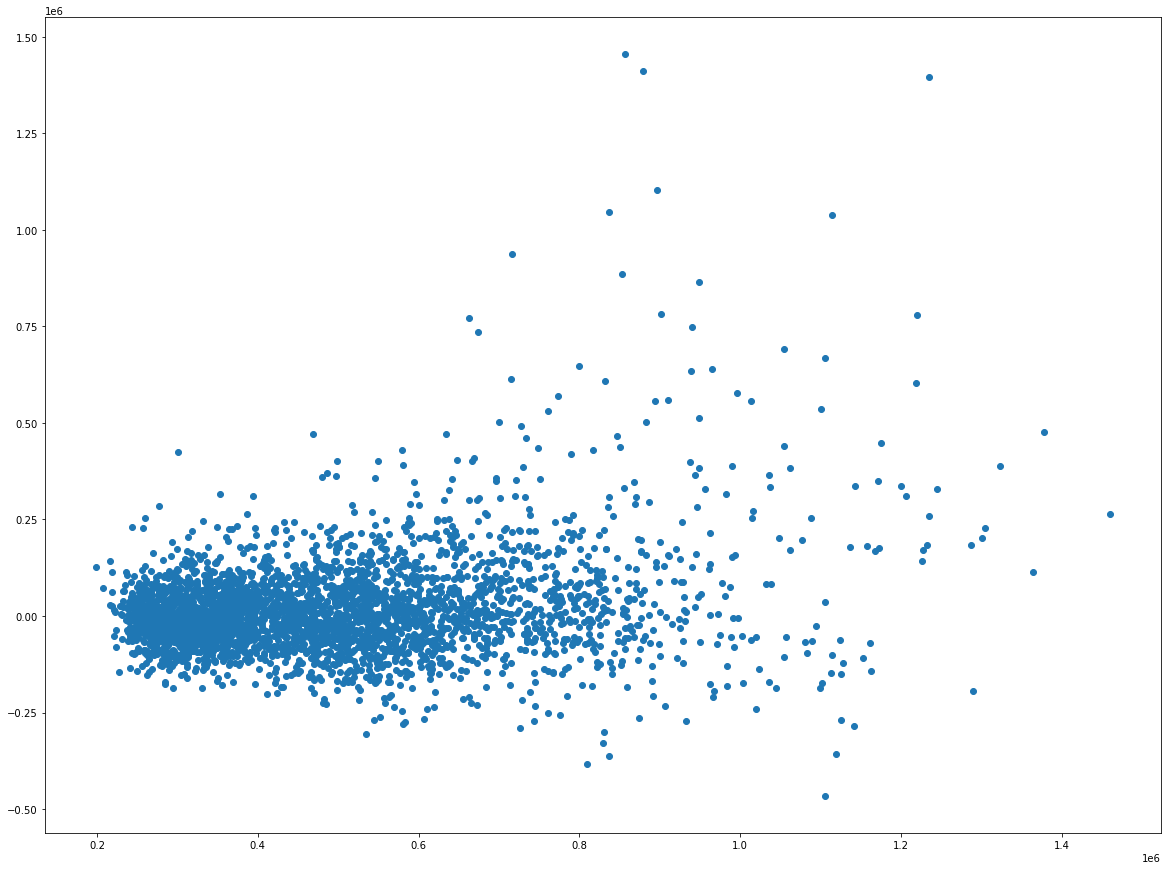

In [134]:
#make prediction on test set
pred_knn = model.predict(X_test_encoded)
pred_knn = np.exp(pred_knn).flatten().astype(int)

# get residuals
residuals = test_actual - pred_knn

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(pred_knn, residuals)

In [135]:
# get mean absolute error

mae = round(mean_absolute_error(test_actual, pred_knn), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, pred_knn)), 2)

models['Models'].append('KNN')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

MAE: 80926.54


## Support Vector Regression

Support vector regression is a form of regression that allows us to define the acceptable error in our model and then finds the line that best fits the data, according to our specifications. This is really useful with something like housing price predictions, where we are ok with our prediction being within a certain dollar amount. SVR will attempt to get all of the predictions within that dollar amount when possible. This will result in a fit line that is different than a linear regression would have produced, but should result in a lower absolute error, which is a reasonable scoring metric for housing price predictions.

We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our SVM! Here are the parameters we are trying out:

* kernel: linear is parametric, and rbf is non-parametric. One of these should perform better. Our data is not totally normal, so it might be rbf.
* epsilon: This value is how much error we're ok with accepting without assigning a penalty to the model
* C: The error that we will accept from a point outside our epsilon

Our C and epsilon need to be in scale with our output variable, which is our log-transformed price.


In order to find our best parameters, we use GridSearchCV. GridSearch takes quite a while, so these sections are commented out as we iterate through different search sets, tuning one parameter at a time. My results are copied in markdown after each section.

We COULD tune all of these at once with one huge grid search. I try to avoid this because it takes several hours, and we can get a similar result with careful iterative tuning.

The testing iterations are found in the appendix.

In [ ]:
# running our model with the optimal parameters

svr = SVR(kernel = 'rbf', gamma = 'auto', C = 10, epsilon = .01)

# fitting our estimator to train data
svr.fit(X_train_refined, y_train)

# getting R^2 with cv
cv_5 = cross_val_score(svr, X_train_refined, y_train, cv=5, n_jobs=-4)
r2 = cv_5.mean()
r2

In [ ]:
# make new predictions on test
predictions_SVR = svr.predict(X_test_refined)
predictions_SVR_unscaled = np.exp(predictions_SVR)

# get residuals
residuals = test_actual - predictions_SVR_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_SVR_unscaled, residuals)

In [ ]:
# get mean absolute error

mae = round(mean_absolute_error(test_actual, predictions_SVR_unscaled), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_SVR_unscaled)), 2)

models['Models'].append('SVR')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

## XGBoost

We're now going to work with a different model type that is entirely different from linear regression. 

There's conflicting information on whether we should use one-hot encoding, or target encoding. We'll solve this by trying both and figuring out what works best for our data set.

### One-Hot Encoding

We need to slightly redo our one-hot encodings to not drop the first entry.

In [ ]:
# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)

# continuous not transformed or standardized
boost_train_continuous = x_continuous[high_one_hot_cont]
boost_holdout_continuous = holdout_continuous[high_one_hot_cont]

# decision tree regression train and test sets
x_train_boost = pd.concat([boost_train_continuous, boost_train_cats], axis=1)
x_test_boost = pd.concat([boost_holdout_continuous, boost_test_cats], axis=1)

# redoing our y_train and y_test as non-log transformed
y = df[target] # our target variable

# creating our train/validation sets and our test sets
y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate)

# reset indices to avoid index mismatches
y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)
y_train.drop('index', axis=1, inplace=True)

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: Min sum of instance weight needed in a child
* gamma: Minimum loss reduction to make another partition on a leaf node. Higher results in more conservative algorithm.
* subsample: Ratio of training sets. .5 means that it will sample half the training data before making trees. Occurs with each boosting iteration.
* colsample_by_tree: ratio of columns when making a tree
* alpha: L1 regularization. Higher will make model more conservative.
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

XGBoost parameter tuning is located in the APPENDIX.

In [ ]:
best_xgb_model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 75,
                reg_lambda=3,
                seed=42,
                missing=0,
                eval_metric='mae' )
best_xgb_model.fit(x_train_boost, y_train)

cv_5 = cross_val_score(best_xgb_model, x_train_boost, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# make prediction
preds = best_xgb_model.predict(x_test_boost)

#log residuals
residuals = test_actual - preds

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(preds, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, preds), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, preds)), 2)

models['Models'].append('XGBoost - One Hot Encoding')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)

### Target Encoding

We're now going to run the same XGBoost regressor, but using our data set with the target encoding. Rather than try to figure out which one is better, we will just try both!

In [ ]:
# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=False)

# continuous not transformed or standardized
boost_train_continuous = x_continuous[low_one_hot_cont]
boost_holdout_continuous = holdout_continuous[low_one_hot_cont]

# decision tree regression train and test sets
x_train_boost_encoded = pd.concat([boost_train_continuous, boost_train_cats], axis=1)
x_test_boost_encoded = pd.concat([boost_holdout_continuous, boost_test_cats], axis=1)

# redoing our y_train and y_test as non-log transformed
y = df[target] # our target variable

# creating our train/validation sets and our test sets
y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate)

# reset indices to avoid index mismatches
y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)
y_train.drop('index', axis=1, inplace=True)

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

This model is entirely different than linear regression. Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: 
* gamma: 
* subsample:
* colsample_by_tree: 
* reg_alpha: 
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

XGBoost parameter tuning is located in the appendix.

In [ ]:
model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                colsample_bytree=.9,
                reg_alpha=.15,
                reg_lambda=3,
                seed=42,
                missing=0,
                eval_metric='mae' )
best_xgb_model.fit(x_train_boost_encoded, y_train)


cv_5 = cross_val_score(best_xgb_model, x_train_boost_encoded, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# make prediction
preds = best_xgb_model.predict(x_test_boost_encoded)

#log residuals
residuals = test_actual - preds

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(preds, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, preds), 2)
rmse = round(np.sqrt(mean_squared_error(test_actual, preds)), 2)

models['Models'].append('XGBoost - Encoded')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

print("MAE:", mae)


# Model Selection

We ran several different types of models, and logged the r^squared and mean absolute error for each model type. Which model performed the best for us?

In [ ]:
# make data frame from our models dictionary
model_types = pd.DataFrame(models)

# sort data frame by mae and reset index
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)
model_types.set_index('Models', inplace=True)

model_types

In [ ]:
# plot model mae

plt.figure(figsize=(15,10))
plt.plot(model_types['mae'])
plt.title("Mean Average Error")
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel("MAE");

Ultimately we will select the sklearn SVM method for our model. 

## Analysis

> Our final model utilizes a combination of continuous variables and one-hot-encoded categoricals to produce a support vector machine regression with R^2 of 89.3%, a mean absolute error of 52k, and a root mean squared error of 78k. I tried several different zip code transformations including polynomial features, mean target encoding, lower-granularity binning, and median rank as a continuous, and ALL of these efforts resulted in a lower R^2 and higher mean absolute error, leading to a final decision to one-hot encode all 70 zip codes individually. Similar efforts on other categoricals such as age and month sold also did not improve the model over one-hot encoding. This resulted in the greatest accuracy despite a model that is more "messy" with a large number of features.

### What are the primary factors influencing housing prices in the King County metro area?
> As square footage increases so does quality of materials. Most importantly you can see the upward price trend with both increased square footage and materials grade. I was intrigued that our lower bound of data points is very linear, but as our square footage increases, the upper bound gradually breaks away with higher variance. 

>I ranked the 70 zip codes in King County by median home value, and used those ranks to color our data points.  Our low median zip codes have a low price per square footage, and price per square foot increases with zip code median, which makes sense, but also shows the importance of zip code to pricing. I found it interesting that while most zip codes exhibit a clear trend of price per square foot decreasing with increased total square footage, which is entirely normal, certain very high value zip codes seem to retain their high price per square foot regardless of total square footage. Certain zip codes seem immune to the usual price per square foot decay. 

> As they say, location is everything, and it is the primary influencing factor for a home price in the King County metro area. Our darkest areas, and therefore highest value sales, are clustered in and around Seattle to the west of Lake Washington and into the eastern lake cities of Bellevue and Redmond which are the technical employer hubs of the region. As we move away from Seattle and the tech hubs into the suburbs, our prices clearly go down.

> These three features alone explain 85% of the price variance.

### Can we effectively use a regression model based system for realtors to determine a proper list price?
> Our model, while explaining over 89.3% of the price variance with our features, was nonetheless far from accurate in absolute terms. A mean average error of 52k in either direction is a huge variance to a home price - one that is so large that it renders the prediction much less meaningful and useful. Other models need to be explored, better data needs to be sourced, or easy-to-use features that an average realtor is capable of evaluating/acquiring should be added to the model to improve its predictive quality. The model is providing at best a baseline starting point.


# Additional Visualizations

## Feature Visualizations

In [ ]:
# get the columns we are going to make visualizations from
viz_df = df[['price', 'sqft_living', 'median_zip', 'zip_rank', 'grade']]
viz_df['pr_sf'] = round(viz_df['price']/viz_df['sqft_living'], 2)
viz_df

In [ ]:
# make simpler variables for our visualiation variables
viz_target = viz_df['price']/100000
viz_sqft = viz_df['sqft_living']
viz_grade = viz_df['grade']
viz_zip = viz_df['zip_rank'] 
viz_zip2 = viz_df['median_zip']
viz_pr_sf = viz_df['pr_sf']

In [ ]:
fig, ax=plt.subplots(figsize=(20,15)) # prepare our figure

sns.set(font_scale = 1.5) # set our font scale bigger for this vis

# scatter our data
scatter2 = sns.scatterplot(x="sqft_living", y=viz_target, data=viz_df, hue='grade', palette='magma_r')

# label axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price to Total Square Footage\nby Grade of Materials", fontsize=20)

# label and position our legend
plt.legend(title='Grade', loc='upper left', title_fontsize=20);

# save visualization to png
#plt.savefig('images/pr_grade.png')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

#ax.scatter(viz_sqft, viz_pr_sf, c=viz_zip, cmap='magma_r')
scatter2 = sns.scatterplot(x="sqft_living", y="pr_sf", data=viz_df, hue='grade', palette='magma_r')

# label axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per Square Foot to Total Square Footage\nby Grade of Materials", fontsize=20)

# label and position our legend
plt.legend(title='Grade', loc='upper right', title_fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_grade.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x="sqft_living", y="price", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price per Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/sqft.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x="sqft_living", y="pr_sf", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per per Square Foot to Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_zip.png');

In [ ]:
viz_y = viz_df['price']
viz_x = viz_df.drop('price', axis=1)

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(viz_sqft, viz_grade, viz_target, c=viz_zip, cmap='magma_r')
#ax.scatter(viz_sqft, viz_grade, viz_target, c='red', label="Predictions")
#ax.scatter(viz_sqft, viz_grade, end_z/100000, c='green', label="Actuals")

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Grade of Materials', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

ax.set_title("Price per Square Footage and Grade of Materials, by Zip Median Rank", fontsize=20)

# first num is tilt angle, second num is turn angle
# default is about 30,305
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(30, 305)


# save visualization to png
#plt.savefig('images/3d_feats.png');

# APPENDIX

In [ ]:
break

## SVM Parameter Tuning

In [ ]:
# Parameter Tuning

param_grid = {'kernel' : ['linear', 'rbf', 'poly'],
              'gamma' : ['scale', 'auto']            
              }

svr = SVR(C=5, epsilon=.05, tol=.01, verbose=True)
grid_search = GridSearchCV(svr, param_grid, verbose=10, scoring='neg_mean_absolute_error', cv=3, n_jobs=-4)

grid_search.fit(X_train_refined, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

*** FINAL TEST ***
Best parameters set found on train set: 

    {'gamma': 'auto', 'kernel': 'rbf'}

    Grid scores on train set:

    -0.115 (+/-0.002) for {'gamma': 'scale', 'kernel': 'linear'}
    -0.120 (+/-0.002) for {'gamma': 'scale', 'kernel': 'rbf'}
    -0.167 (+/-0.007) for {'gamma': 'scale', 'kernel': 'poly'}
    -0.115 (+/-0.002) for {'gamma': 'auto', 'kernel': 'linear'}
    -0.111 (+/-0.002) for {'gamma': 'auto', 'kernel': 'rbf'}
    -0.239 (+/-0.008) for {'gamma': 'auto', 'kernel': 'poly'}

In [ ]:
# Parameter Tuning

param_grid = {'C' : [3, 5, 7, 10]            
              }

svr = SVR(epsilon=.05, tol=.01, verbose=True, kernel='rbf', gamma='auto')
grid_search = GridSearchCV(svr, param_grid, verbose=10, scoring='neg_mean_absolute_error', cv=3, n_jobs=-4)

grid_search.fit(X_train_refined, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

*** FINAL TEST ***

Best parameters set found on train set: 

    {'C': 10}

    Grid scores on train set:

    -0.111 (+/-0.003) for {'C': 3}
    -0.110 (+/-0.004) for {'C': 5}
    -0.109 (+/-0.003) for {'C': 7}
    -0.109 (+/-0.003) for {'C': 10}

In [ ]:
# Parameter Tuning

param_grid = {'epsilon' : [.01, .05, .1, .5]            
              }

svr = SVR(C=10, tol=.01, verbose=True, kernel='rbf', gamma='auto')
grid_search = GridSearchCV(svr, param_grid, verbose=10, scoring='neg_mean_absolute_error', cv=3, n_jobs=-4)

grid_search.fit(X_train_refined, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

*** FINAL TEST ***

Best parameters set found on train set: 

    {'epsilon': 0.01}

    Grid scores on train set:

    -0.109 (+/-0.003) for {'epsilon': 0.01}
    -0.109 (+/-0.003) for {'epsilon': 0.05}
    -0.110 (+/-0.004) for {'epsilon': 0.1}
    -0.153 (+/-0.004) for {'epsilon': 0.5}

## XGBoost One-Hot Parameter Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,33,3), 
                                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,33,3), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,33,3), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('MAE')
    plt.title("Mean Absolute Error for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [5, 6, 7, 8],
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae')

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 5}

    Grid scores on train set:

    0.881 (+/-0.016) for {'max_depth': 5}
    0.878 (+/-0.020) for {'max_depth': 6}
    0.878 (+/-0.013) for {'max_depth': 7}
    0.872 (+/-0.016) for {'max_depth': 8}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=5,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:

    0.885 (+/-0.014) for {'min_child_weight': 6}
    0.885 (+/-0.014) for {'min_child_weight': 8}
    0.884 (+/-0.014) for {'min_child_weight': 10}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [7, 8, 9]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=5,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:

    0.884 (+/-0.012) for {'min_child_weight': 7}
    0.885 (+/-0.014) for {'min_child_weight': 8}
    0.884 (+/-0.018) for {'min_child_weight': 9}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.1, .3, .5, .7, .9],           
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.1}

    Grid scores on train set:

    0.885 (+/-0.014) for {'gamma': 0.1}
    0.885 (+/-0.014) for {'gamma': 0.3}
    0.885 (+/-0.014) for {'gamma': 0.5}
    0.885 (+/-0.014) for {'gamma': 0.7}
    0.885 (+/-0.014) for {'gamma': 0.9}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'subsample': 1}

    Grid scores on train set:

    0.843 (+/-0.022) for {'subsample': 0.2}
    0.869 (+/-0.019) for {'subsample': 0.4}
    0.876 (+/-0.015) for {'subsample': 0.6}
    0.882 (+/-0.019) for {'subsample': 0.8}
    0.885 (+/-0.014) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.8}

    Grid scores on train set:

    0.879 (+/-0.019) for {'colsample_bytree': 0.2}
    0.883 (+/-0.016) for {'colsample_bytree': 0.4}
    0.886 (+/-0.014) for {'colsample_bytree': 0.6}
    0.886 (+/-0.014) for {'colsample_bytree': 0.8}
    0.886 (+/-0.015) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 100}

    Grid scores on train set:

    0.885 (+/-0.014) for {'reg_alpha': 1e-05}
    0.885 (+/-0.014) for {'reg_alpha': 0.01}
    0.885 (+/-0.014) for {'reg_alpha': 0.1}
    0.885 (+/-0.014) for {'reg_alpha': 1}
    0.886 (+/-0.013) for {'reg_alpha': 100}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[75, 100, 125, 150]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 75}

    Grid scores on train set:

    0.887 (+/-0.014) for {'reg_alpha': 75}
    0.887 (+/-0.014) for {'reg_alpha': 100}
    0.887 (+/-0.014) for {'reg_alpha': 125}
    0.887 (+/-0.014) for {'reg_alpha': 150}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 75,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 10}

    Grid scores on train set:

    0.883 (+/-0.017) for {'lambda': 0.1}
    0.887 (+/-0.014) for {'lambda': 1}
    0.887 (+/-0.017) for {'lambda': 10}
    0.885 (+/-0.014) for {'lambda': 100}
    0.874 (+/-0.016) for {'lambda': 500}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[3, 5, 7, 10, 15]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 5,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 75,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 3}

    Grid scores on train set:

    0.890 (+/-0.012) for {'lambda': 3}
    0.889 (+/-0.013) for {'lambda': 5}
    0.888 (+/-0.018) for {'lambda': 7}
    0.887 (+/-0.017) for {'lambda': 10}
    0.889 (+/-0.018) for {'lambda': 15}

## XGBoost Encoded Parameter Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,33,3), 
                                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,33,3), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,33,3), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('MAE')
    plt.title("Mean Absolute Error for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost_encoded, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
param_grid = {"max_depth": [2, 4, 6],       
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 4}

    Grid scores on train set:

    0.881 (+/-0.008) for {'max_depth': 2}
    0.885 (+/-0.007) for {'max_depth': 4}
    0.876 (+/-0.012) for {'max_depth': 6}

In [ ]:
# Parameter Tuning

param_grid = {"max_depth": [3, 4, 5],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 3}

    Grid scores on train set:

    0.885 (+/-0.010) for {'max_depth': 3}
    0.885 (+/-0.007) for {'max_depth': 4}
    0.881 (+/-0.007) for {'max_depth': 5}

In [ ]:
# Parameter Tuning

param_grid = {"min_child_weight" : [6, 8, 10, 20],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 20}

    Grid scores on train set:

    0.885 (+/-0.008) for {'min_child_weight': 6}
    0.887 (+/-0.009) for {'min_child_weight': 8}
    0.886 (+/-0.008) for {'min_child_weight': 10}
    0.887 (+/-0.009) for {'min_child_weight': 20}}

In [ ]:
# Parameter Tuning

param_grid = {'gamma': [.2, .4, .5, .6, .8, 1],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.2}

    Grid scores on train set:

    0.887 (+/-0.009) for {'gamma': 0.2}
    0.887 (+/-0.009) for {'gamma': 0.4}
    0.887 (+/-0.009) for {'gamma': 0.5}
    0.887 (+/-0.009) for {'gamma': 0.6}
    0.887 (+/-0.009) for {'gamma': 0.8}
    0.887 (+/-0.009) for {'gamma': 1}

In [ ]:
# Parameter Tuning

param_grid = {'gamma': [.1, .2, .3],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.1}

    Grid scores on train set:

    0.887 (+/-0.009) for {'gamma': 0.1}
    0.887 (+/-0.009) for {'gamma': 0.2}
    0.887 (+/-0.009) for {'gamma': 0.3}

In [ ]:
# Parameter Tuning

param_grid = {'subsample':[.6, .7, .8, .9, 1],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'subsample': 1}

    Grid scores on train set:

    0.879 (+/-0.008) for {'subsample': 0.6}
    0.882 (+/-0.007) for {'subsample': 0.7}
    0.883 (+/-0.009) for {'subsample': 0.8}
    0.886 (+/-0.008) for {'subsample': 0.9}
    0.887 (+/-0.009) for {'subsample': 1}

In [ ]:
# Parameter Tuning

param_grid = {'colsample_bytree':[.6, .7, .8, .9, 1],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.9}

    Grid scores on train set:

    0.887 (+/-0.009) for {'colsample_bytree': 0.6}
    0.887 (+/-0.008) for {'colsample_bytree': 0.7}
    0.887 (+/-0.008) for {'colsample_bytree': 0.8}
    0.888 (+/-0.008) for {'colsample_bytree': 0.9}
    0.887 (+/-0.010) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning

param_grid = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                colsample_bytree=.9,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 0.1}

    Grid scores on train set:

    0.888 (+/-0.008) for {'reg_alpha': 1e-05}
    0.888 (+/-0.008) for {'reg_alpha': 0.01}
    0.888 (+/-0.008) for {'reg_alpha': 0.1}
    0.888 (+/-0.008) for {'reg_alpha': 1}
    0.888 (+/-0.008) for {'reg_alpha': 10}
    0.888 (+/-0.008) for {'reg_alpha': 100}

In [ ]:
# Parameter Tuning

param_grid = {'reg_alpha':[.05, .1, .15,  .3, .5],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                colsample_bytree=.9,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 0.15}

    Grid scores on train set:

    0.888 (+/-0.008) for {'reg_alpha': 0.05}
    0.888 (+/-0.008) for {'reg_alpha': 0.1}
    0.888 (+/-0.008) for {'reg_alpha': 0.15}
    0.888 (+/-0.008) for {'reg_alpha': 0.3}
    0.888 (+/-0.008) for {'reg_alpha': 0.5}

In [ ]:
# Parameter Tuning

param_grid = {'reg_lambda':[1e-5, 1e-2, 0.1, 1, 10, 100],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                colsample_bytree=.9,
                reg_alpha=.15,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_lambda': 1}

    Grid scores on train set:

    0.887 (+/-0.006) for {'reg_lambda': 1e-05}
    0.887 (+/-0.006) for {'reg_lambda': 0.01}
    0.887 (+/-0.006) for {'reg_lambda': 0.1}
    0.888 (+/-0.008) for {'reg_lambda': 1}
    0.888 (+/-0.010) for {'reg_lambda': 10}
    0.885 (+/-0.010) for {'reg_lambda': 100}

In [ ]:
# Parameter Tuning

param_grid = {'reg_lambda':[.5, 1, 1.5, 3],        
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight=20,
                gamma = .1,
                colsample_bytree=.9,
                reg_alpha=.15,
                seed=42,
                missing=0,
                eval_metric='mae' )
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_lambda': 3}

    Grid scores on train set:

    0.888 (+/-0.008) for {'reg_lambda': 0.5}
    0.887 (+/-0.008) for {'reg_lambda': 1}
    0.886 (+/-0.010) for {'reg_lambda': 1.5}
    0.888 (+/-0.009) for {'reg_lambda': 3}